In [1]:
using Revise
using Kinetic
using DifferentialEquations, Flux
using DiffEqFlux, Optim
using Plots

In [7]:
function boltzmann!(df, f::Array{<:Real,3}, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

function bgk!(df, f::Array{<:Real,3}, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [27]:
function reduce_distribution(f::AbstractArray{<:Real,3}, w::AbstractArray{<:Real,3})
    h = zeros(axes(f, 1))
    for i in eachindex(h)
        h[i] = sum(@. w[i,:,:] * f[i,:,:])
    end
    
    return h
end

reduce_distribution (generic function with 1 method)

In [4]:
maxTime = 8.
tlen = 9
u0 = -5.
u1 = 5.
nu = 24
nug = 0
v0 = -5.
v1 = 5.
nv = 24
nvg = 0
w0 = -5.
w1 = 5.
nw = 24
nwg = 0
vMeshType = "rectangle"
nm = 5
knudsen = 1.
inK = 0
alpha = 1.0
omega = 0.5
nh = 5

5

In [23]:
tspan = (0.0, maxTime)
tRange = range(tspan[1], tspan[2], length=tlen)
γ = heat_capacity_ratio(inK, 3)
vSpace = VSpace3D(u0, u1, nu, v0, v1, nv, w0, w1, nw, vMeshType)
mu_ref = ref_vhs_vis(knudsen, alpha, omega)
kn_bzm = hs_boltz_kn(mu_ref, 1.0);

In [25]:
phi, psi, phipsi = kernel_mode( nm, vSpace.u1, vSpace.v1, vSpace.w1, vSpace.du[1,1,1], vSpace.dv[1,1,1], vSpace.dw[1,1,1],
                                vSpace.nu, vSpace.nv, vSpace.nw, alpha );

In [30]:
f1 = Float32.(0.5 * (1/π)^1.5 .* (exp.(-(vSpace.u .- 0.99).^2) .+ exp.(-(vSpace.u .+ 0.99).^2)) .* 
     exp.(-vSpace.v.^2) .* exp.(-vSpace.w.^2)) |> Array
prim1 = conserve_prim(moments_conserve(f1, vSpace.u, vSpace.v, vSpace.w, vSpace.weights), γ)
M1 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim1)) |> Array
τ1 = mu_ref * 2. * prim1[end]^(0.5) / prim1[1];

f2 = Float32.(0.25 * (1/π)^1.5 .* (exp.(-(vSpace.u .- 0.99).^2) .+ exp.(-(vSpace.u .+ 0.99).^2)) .* 
     exp.(-vSpace.v.^2) .* exp.(-vSpace.w.^2)) |> Array
prim2 = conserve_prim(moments_conserve(f2, vSpace.u, vSpace.v, vSpace.w, vSpace.weights), γ)
M2 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim2)) |> Array
τ2 = mu_ref * 2. * prim2[end]^(0.5) / prim2[1];

In [31]:
#--- Boltzmann ---#
prob = ODEProblem(boltzmann!, f1, tspan, [kn_bzm, nm, phi, psi, phipsi])
data_boltz1 = solve(prob, Tsit5(), saveat=tRange) |> Array;

prob = ODEProblem(boltzmann!, f2, tspan, [kn_bzm, nm, phi, psi, phipsi])
data_boltz2 = solve(prob, Tsit5(), saveat=tRange) |> Array;

In [32]:
#--- BGK ---#
prob = ODEProblem(bgk!, f1, tspan, [M0, τ])
data_bgk1 = solve(prob, Tsit5(), saveat=tRange) |> Array;

prob = ODEProblem(bgk!, f2, tspan, [M0, τ])
data_bgk2 = solve(prob, Tsit5(), saveat=tRange) |> Array;

In [33]:
data_boltz_1D1 = zeros(Float32, axes(data_boltz1, 1), axes(data_boltz1, 4))
data_bgk_1D1 = zeros(Float32, axes(data_bgk1, 1), axes(data_bgk1, 4))
for j in axes(data_boltz_1D1, 2)
    data_boltz_1D1[:,j] .= reduce_distribution(data_boltz1[:,:,:,j], vSpace.weights)
    data_bgk_1D1[:,j] .= reduce_distribution(data_bgk1[:,:,:,j], vSpace.weights)
end
f0_1D1 = reduce_distribution(f1, vSpace.weights)
M0_1D1 = reduce_distribution(M1, vSpace.weights);

data_boltz_1D2 = zeros(Float32, axes(data_boltz2, 1), axes(data_boltz2, 4))
data_bgk_1D2 = zeros(Float32, axes(data_bgk2, 1), axes(data_bgk2, 4))
for j in axes(data_boltz_1D2, 2)
    data_boltz_1D2[:,j] .= reduce_distribution(data_boltz2[:,:,:,j], vSpace.weights)
    data_bgk_1D2[:,j] .= reduce_distribution(data_bgk2[:,:,:,j], vSpace.weights)
end
f0_1D2 = reduce_distribution(f2, vSpace.weights)
M0_1D2 = reduce_distribution(M2, vSpace.weights);

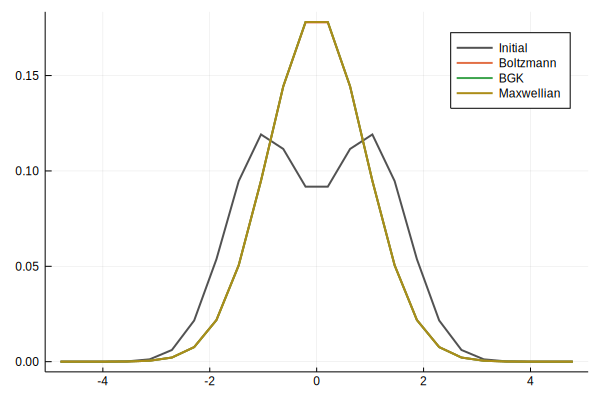

In [34]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D1[:,1], lw=2, label="Initial", color=:gray32)
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D1[:,end], lw=2, label="Boltzmann")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_bgk_1D1[:,end], lw=2, label="BGK")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D1[:], lw=2, label="Maxwellian", color=5)

In [16]:
#--- neural ode ---#
dudt = FastChain( (x, p) -> x.^2, 
                   FastDense(vSpace.nu, vSpace.nu*nh, tanh), 
                   FastDense(vSpace.nu*nh, vSpace.nu*nh, tanh), 
                   FastDense(vSpace.nu*nh, vSpace.nu) )
n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat=tRange)

function loss_n_ode(p)
    pred = n_ode(f0_1D, p)
    loss = sum(abs2, pred .- data_boltz_1D)
    return loss, pred
end

cb = function (p, l, pred; doplot=true)
    display(l)
    # plot current prediction against dataset
    if doplot
        pl = plot(tRange, data_boltz_1D[vSpace.nu÷2,:], lw=2, label="Exact")
        scatter!(pl, tRange, pred[vSpace.nu÷2,:], lw=2, label="NN prediction")
        display(plot(pl))
    end
    return false
end

#10 (generic function with 1 method)

0.37131026f0

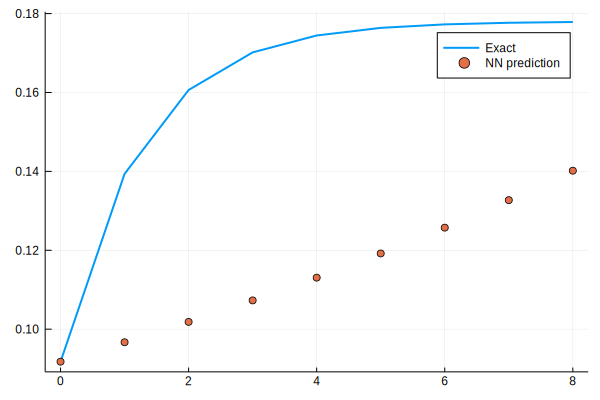

loss: 0.371:   0%|▏                                        |  ETA: 0:48:09

0.19196531f0

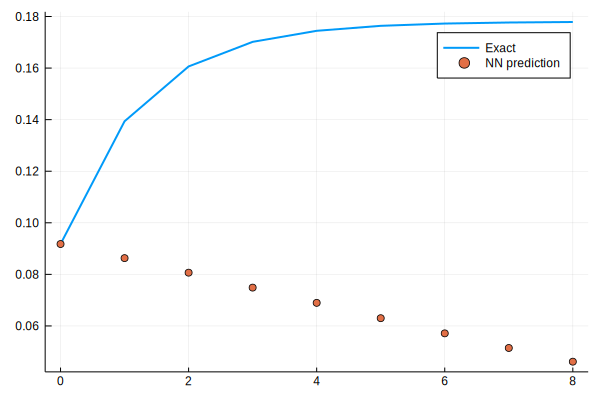

0.1767268f0

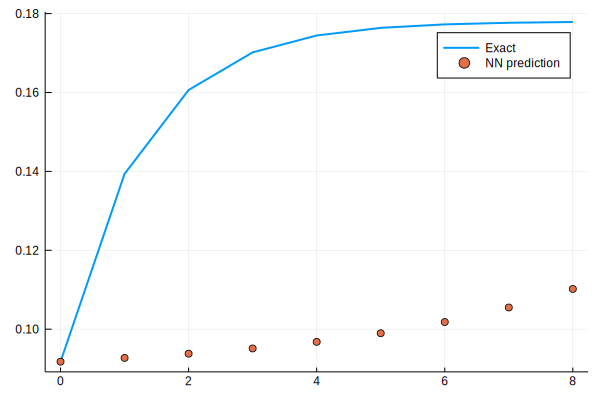

0.14032233f0

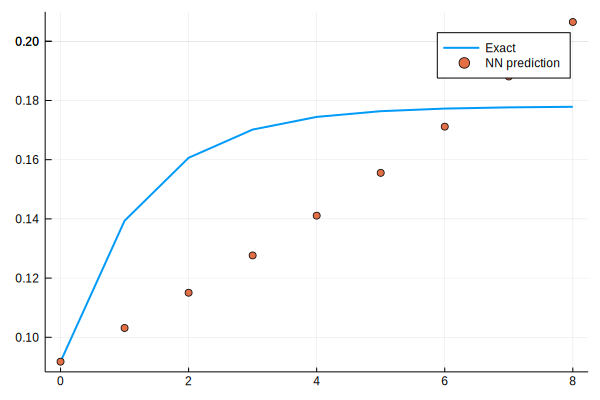

loss: 0.14:   1%|▌                                        |  ETA: 0:11:23

0.12071818f0

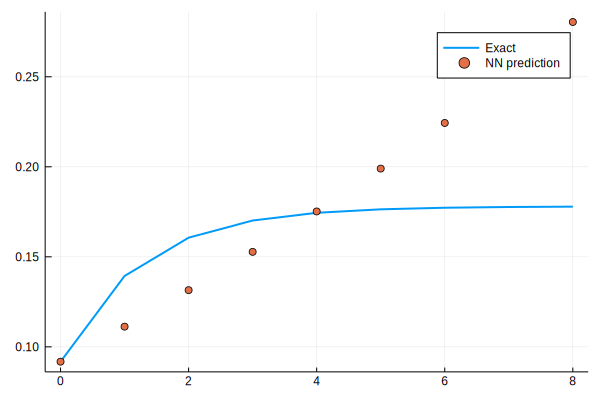

0.10248258f0

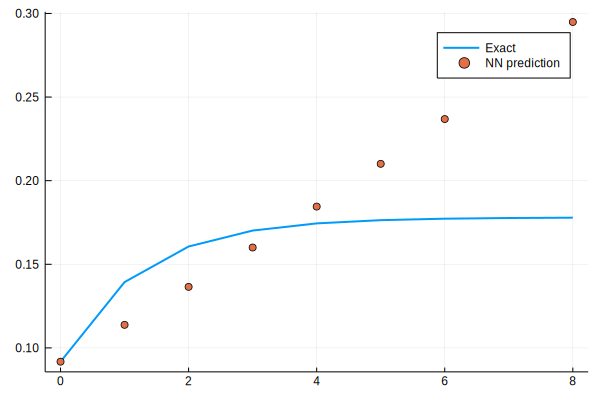

loss: 0.102:   2%|▉                                        |  ETA: 0:07:28

0.08932657f0

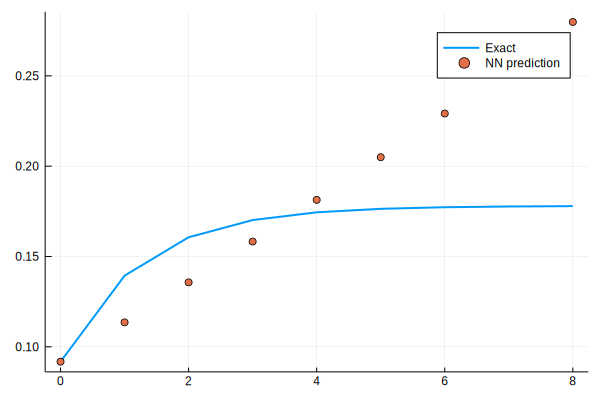

0.08472077f0

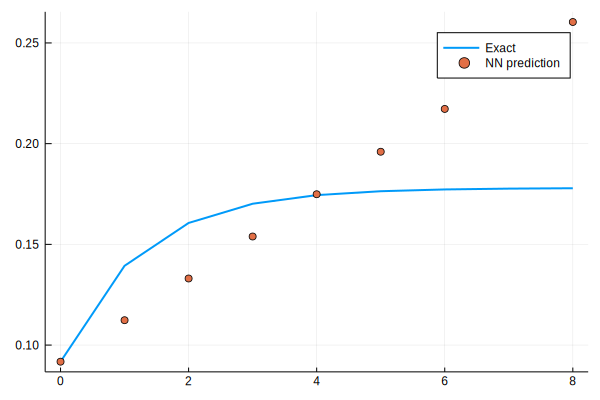

loss: 0.0847:   3%|█▏                                       |  ETA: 0:05:48

0.07143873f0

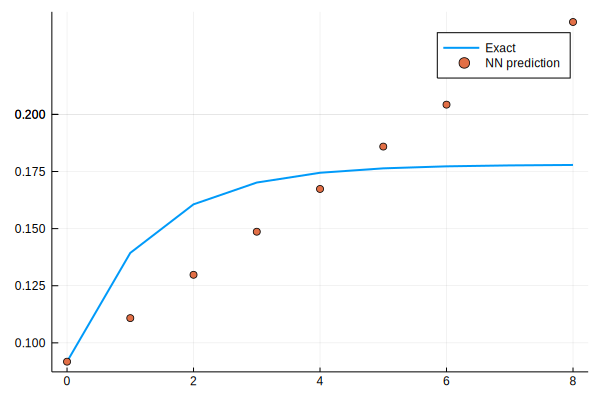

0.056889817f0

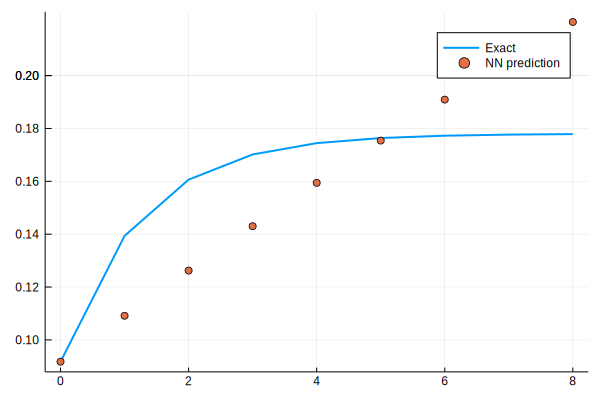

loss: 0.0569:   3%|█▍                                       |  ETA: 0:04:37

0.05046245f0

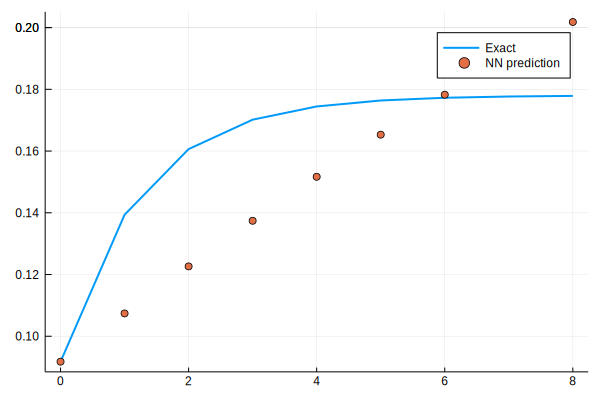

0.04477043f0

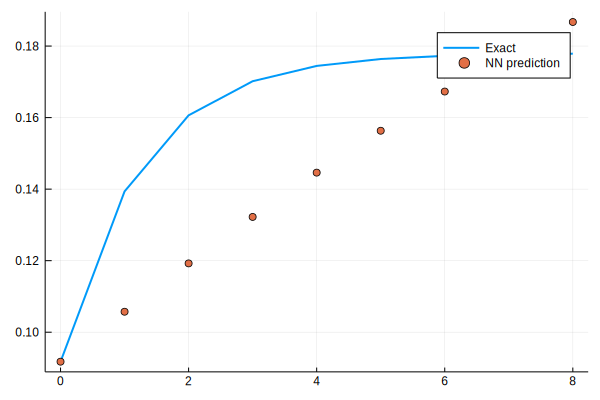

loss: 0.0448:   4%|█▋                                       |  ETA: 0:03:51

0.03973163f0

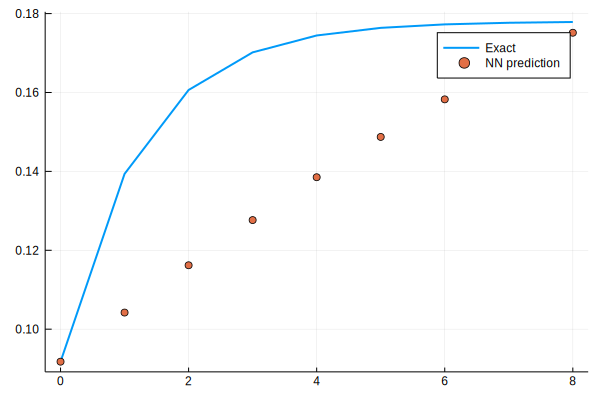

0.04092405f0

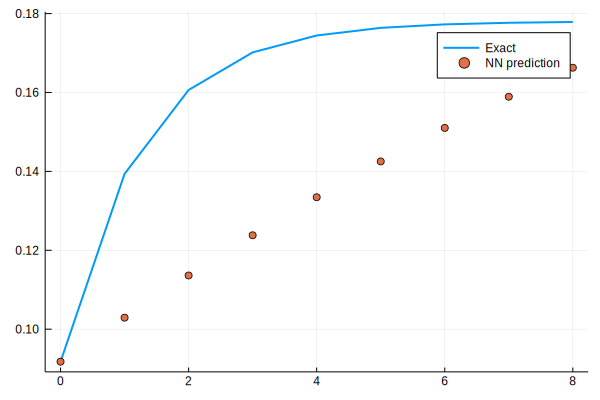

loss: 0.0409:   5%|█▉                                       |  ETA: 0:03:23

0.04584012f0

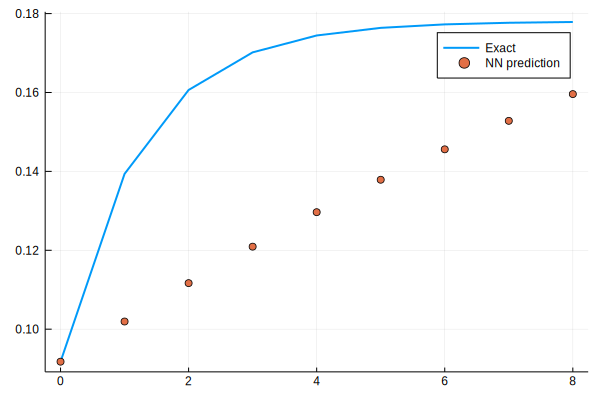

0.047395576f0

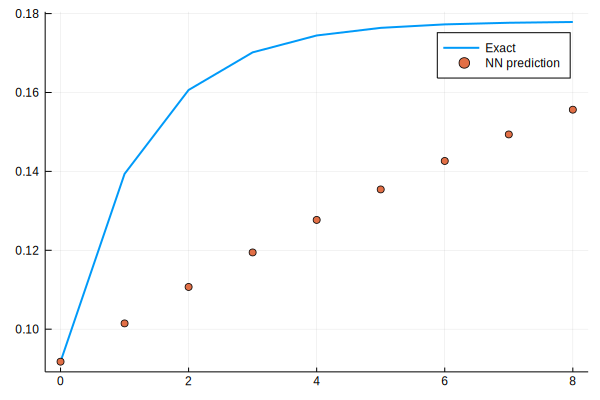

loss: 0.0474:   5%|██▏                                      |  ETA: 0:02:57

0.043668184f0

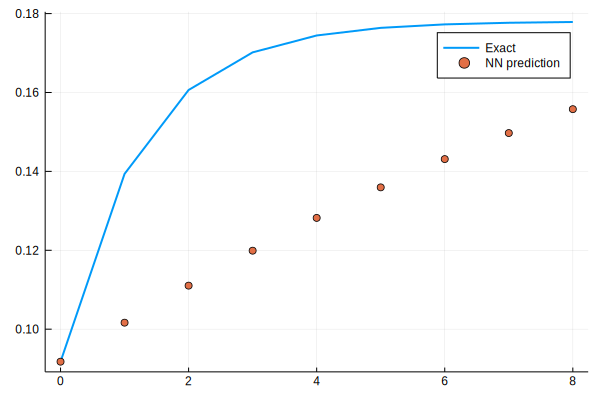

0.03737685f0

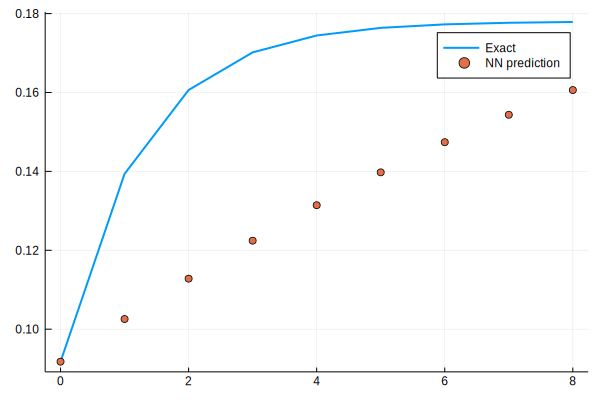

loss: 0.0374:   6%|██▌                                      |  ETA: 0:02:37

0.031500358f0

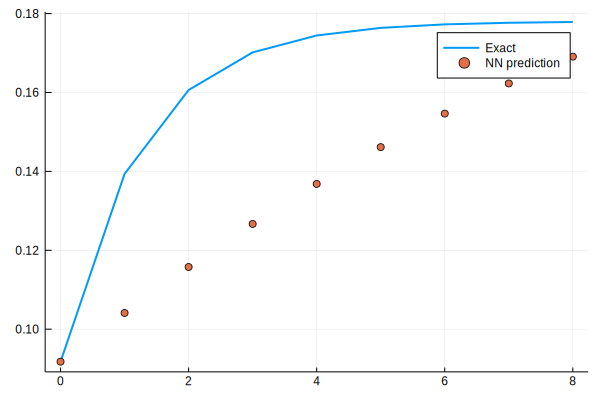

0.027170282f0

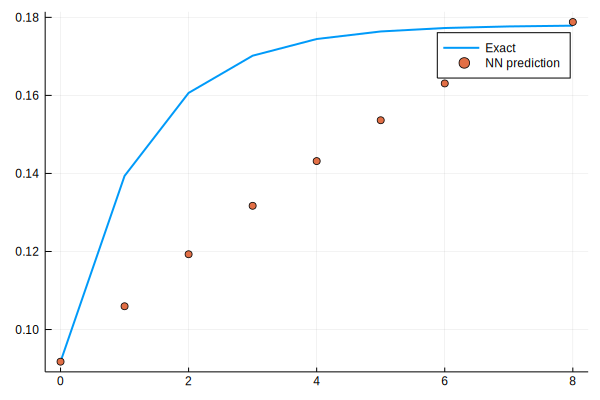

loss: 0.0272:   7%|██▊                                      |  ETA: 0:02:24

0.023800347f0

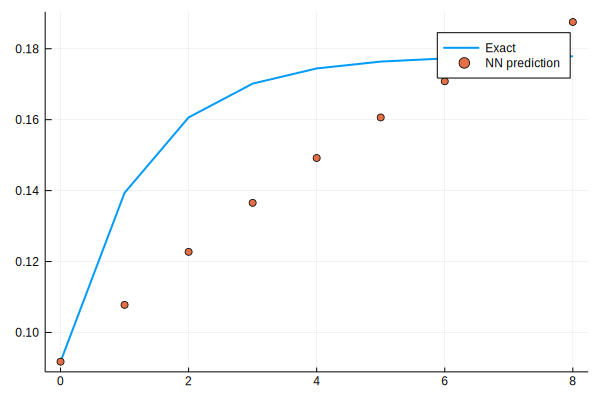

0.021092454f0

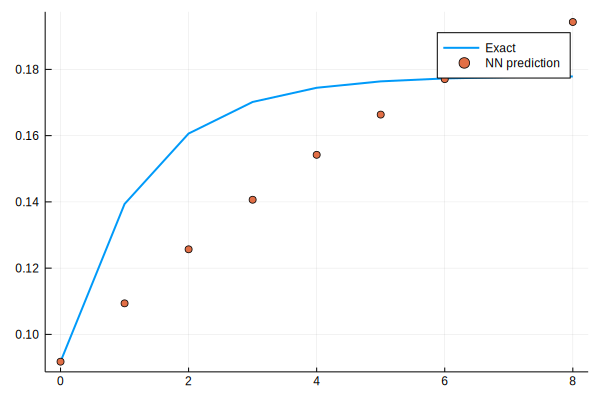

loss: 0.0211:   7%|███                                      |  ETA: 0:02:11

0.020099899f0

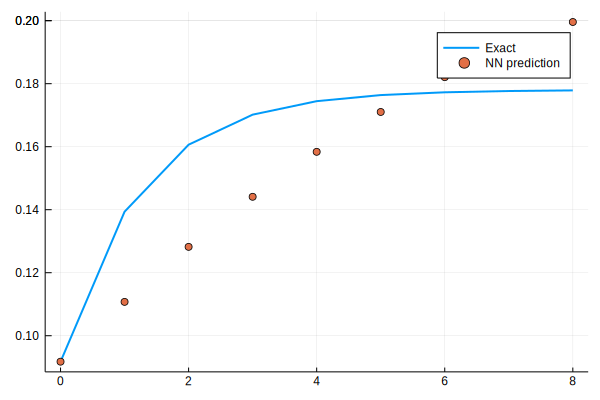

0.02118152f0

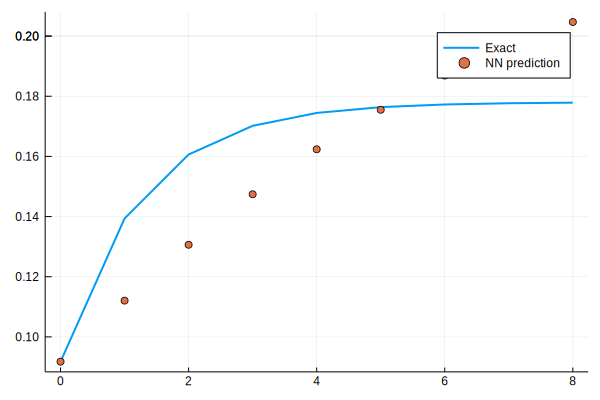

loss: 0.0212:   8%|███▎                                     |  ETA: 0:02:00

0.022513248f0

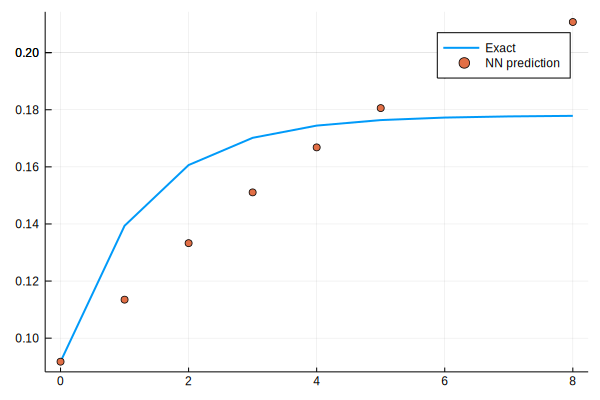

0.022474255f0

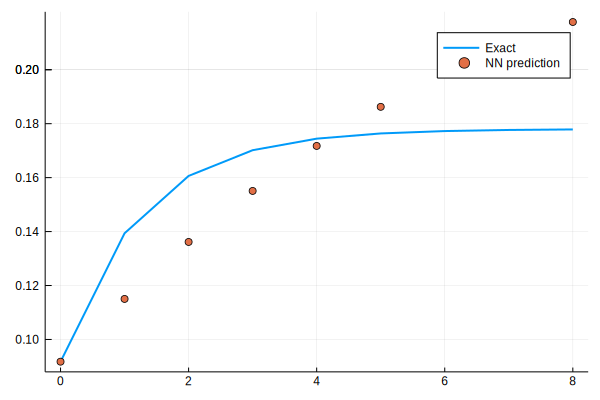

loss: 0.0225:   9%|███▌                                     |  ETA: 0:01:52

0.021638038f0

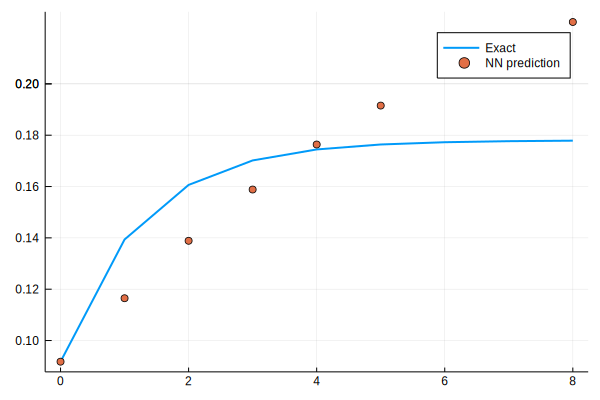

0.020782331f0

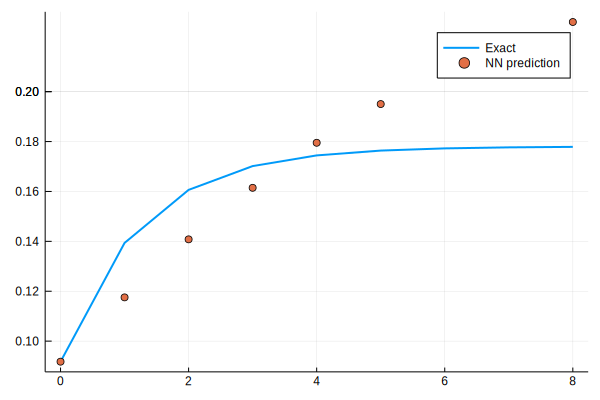

loss: 0.0208:   9%|███▉                                     |  ETA: 0:01:44

0.019493734f0

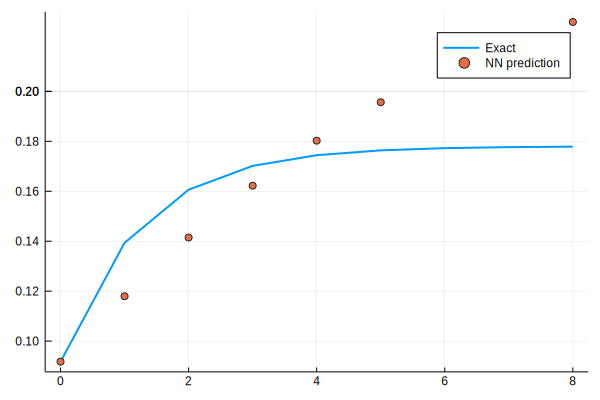

0.017599864f0

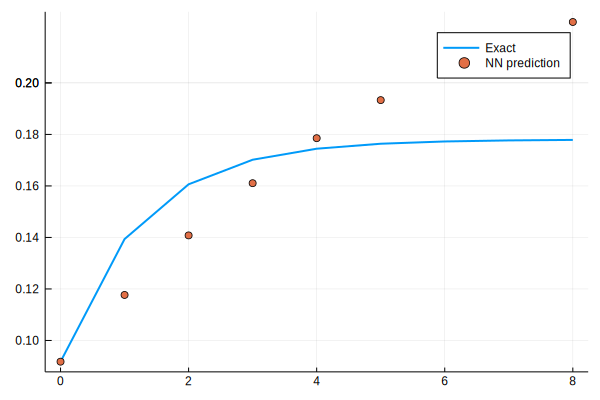

loss: 0.0176:  10%|████▏                                    |  ETA: 0:01:37

0.015681205f0

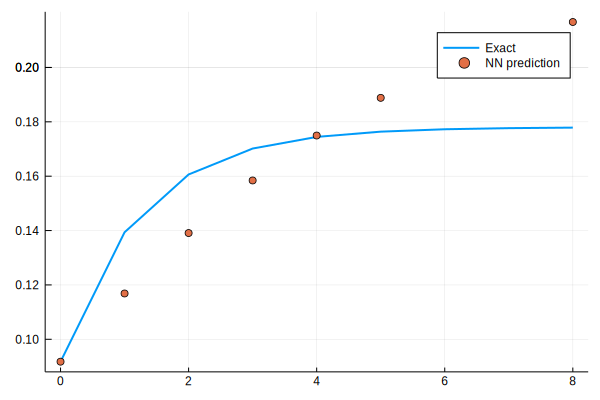

0.014101086f0

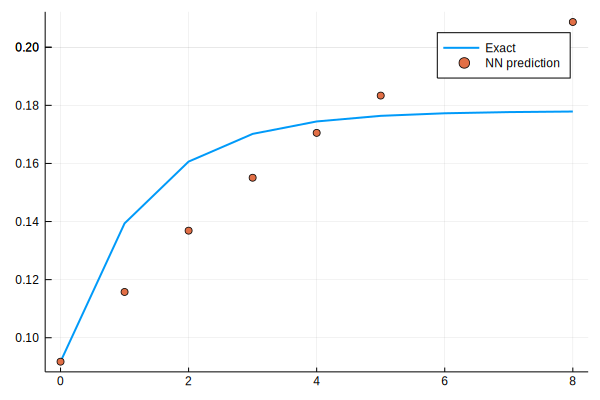

loss: 0.0141:  11%|████▍                                    |  ETA: 0:01:32

0.012907843f0

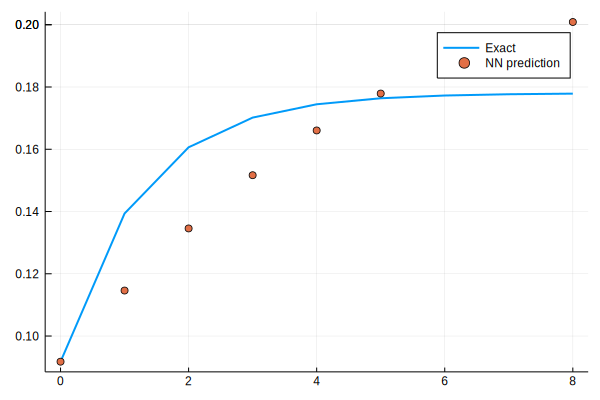

0.0122290775f0

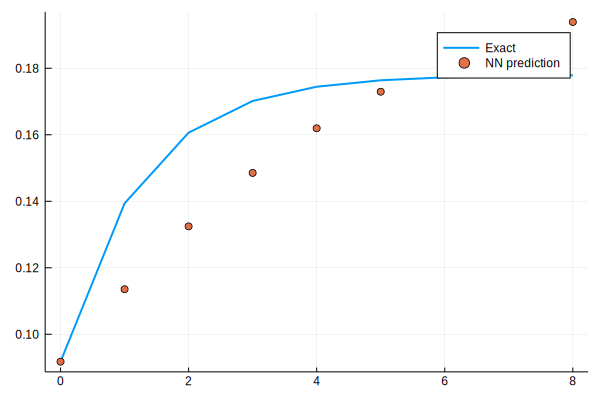

loss: 0.0122:  11%|████▋                                    |  ETA: 0:01:27

0.01210616f0

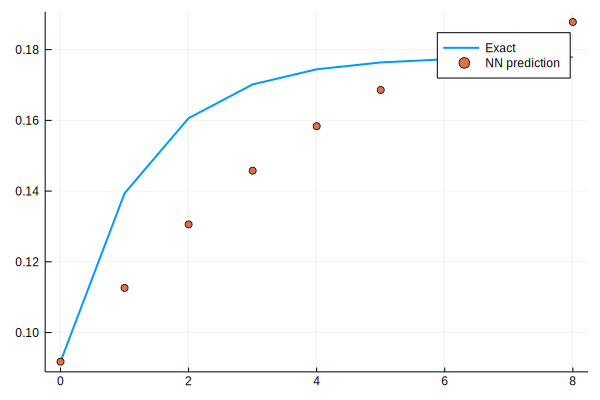

0.012320855f0

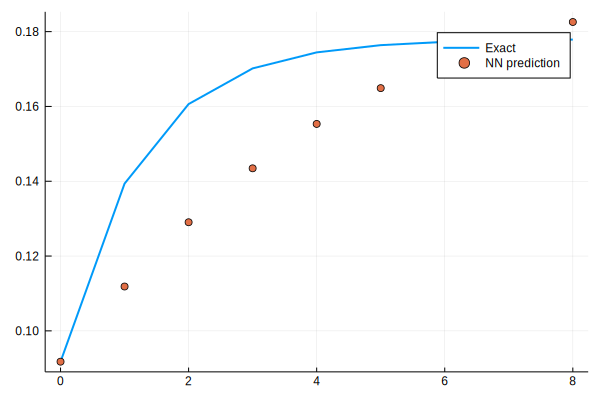

loss: 0.0123:  12%|████▉                                    |  ETA: 0:01:22

0.012477608f0

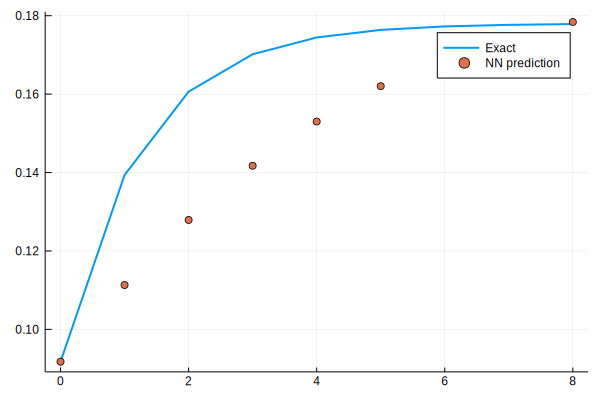

0.012220182f0

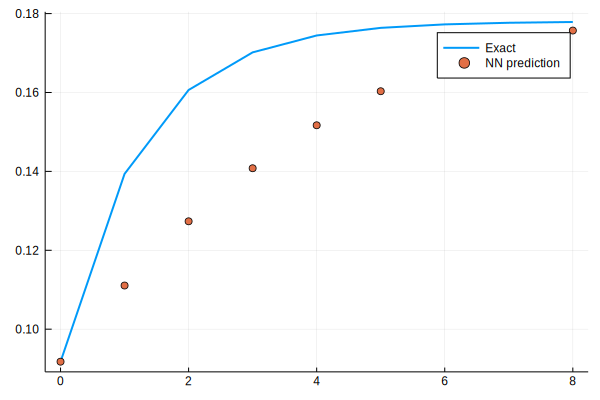

loss: 0.0122:  13%|█████▏                                   |  ETA: 0:01:19

0.01162278f0

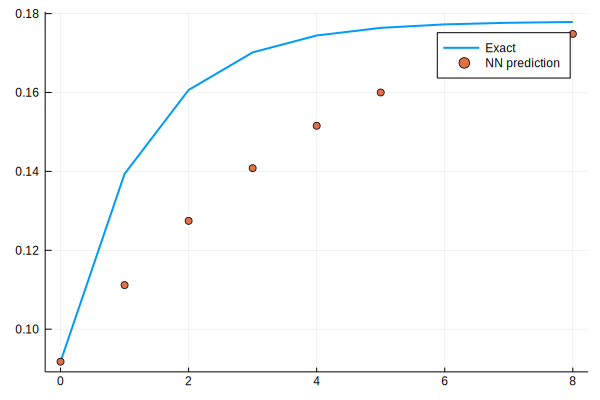

0.011058185f0

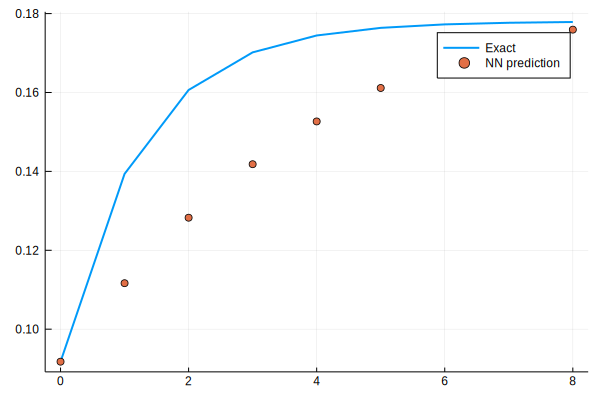

loss: 0.0111:  13%|█████▌                                   |  ETA: 0:01:15

0.010523988f0

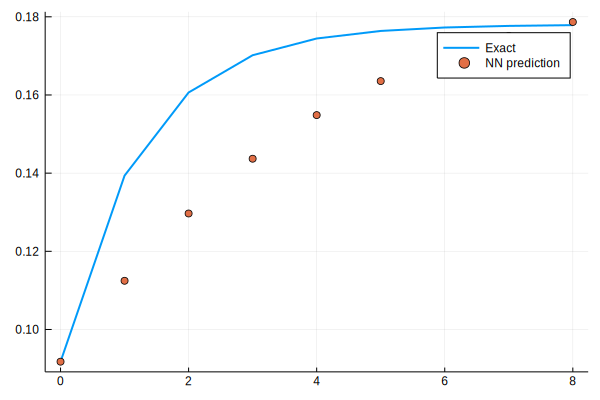

0.009763408f0

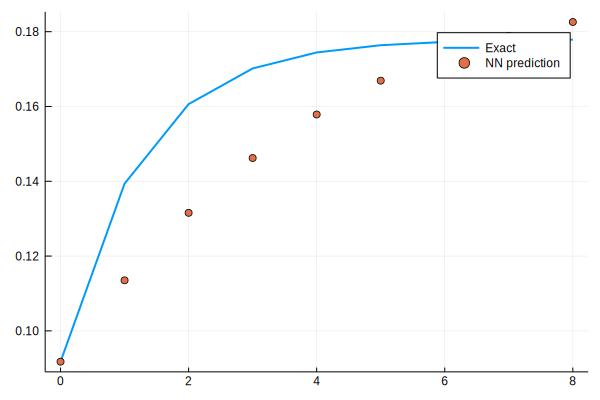

loss: 0.00976:  14%|█████▊                                   |  ETA: 0:01:11

0.008941588f0

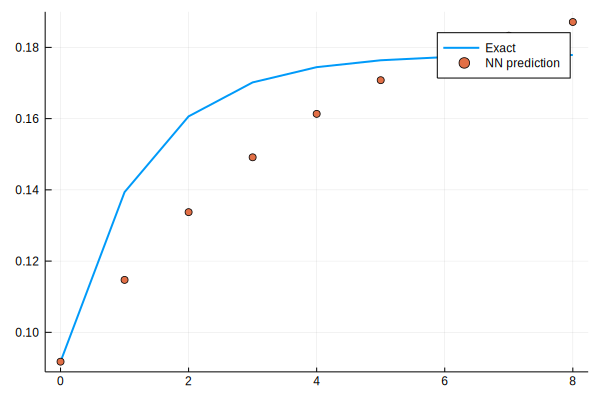

0.008408971f0

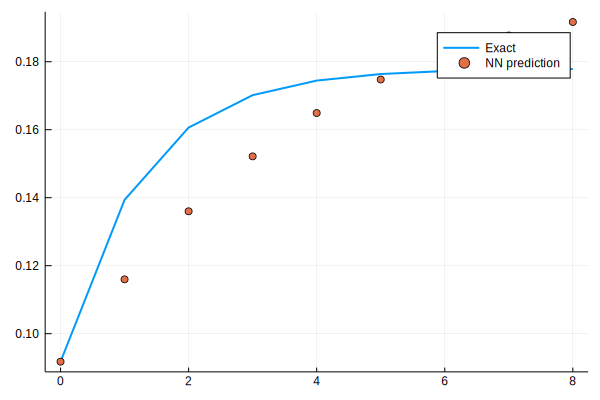

loss: 0.00841:  15%|██████                                   |  ETA: 0:01:09

0.008151851f0

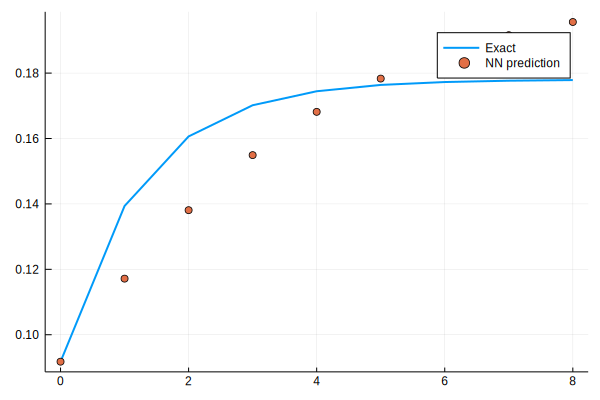

0.007963221f0

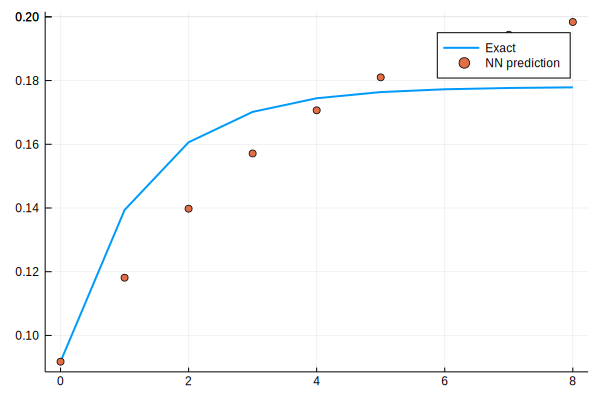

loss: 0.00796:  15%|██████▎                                  |  ETA: 0:01:06

0.007745839f0

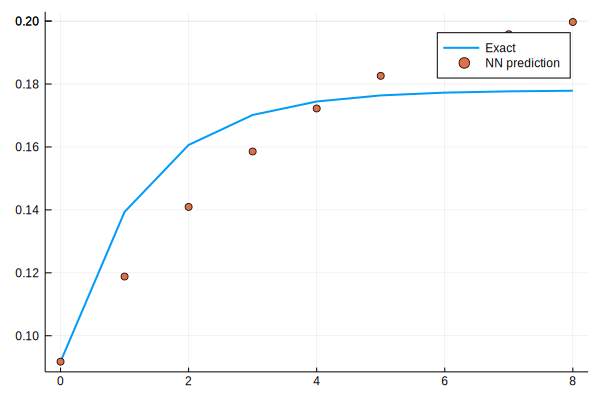

0.007511813f0

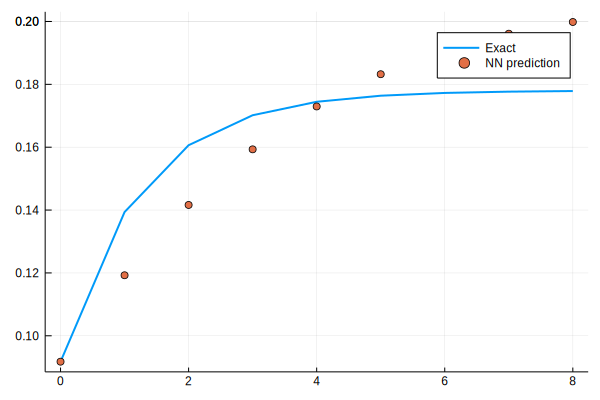

loss: 0.00751:  16%|██████▌                                  |  ETA: 0:01:03

0.0072871f0

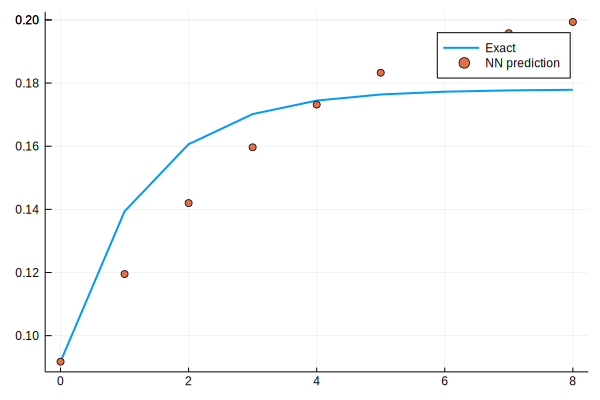

0.007045538f0

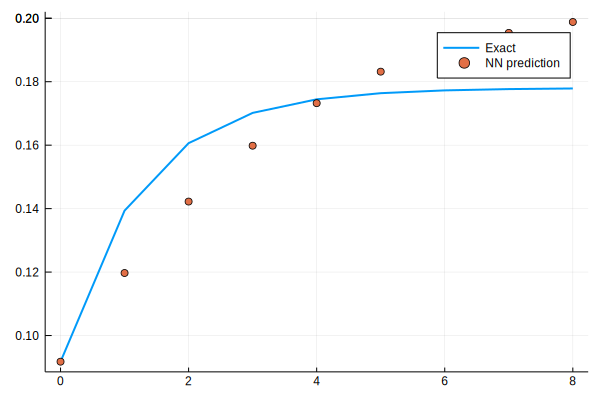

loss: 0.00705:  17%|██████▊                                  |  ETA: 0:01:01

0.006797398f0

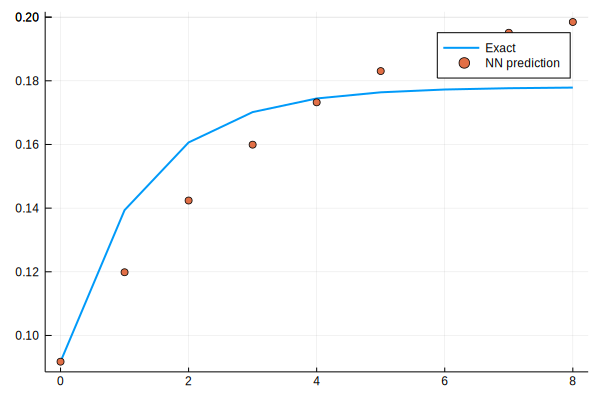

0.006591153f0

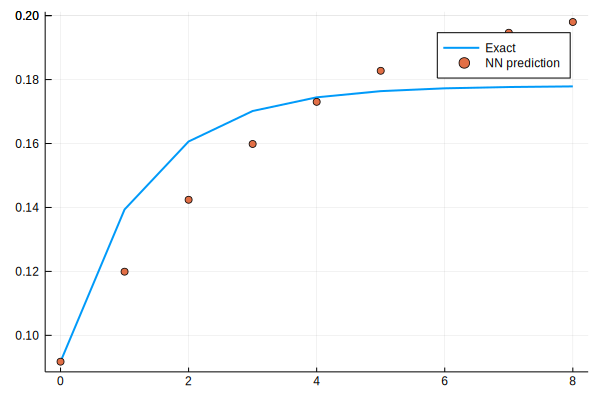

loss: 0.00659:  17%|███████▏                                 |  ETA: 0:00:59

0.006363689f0

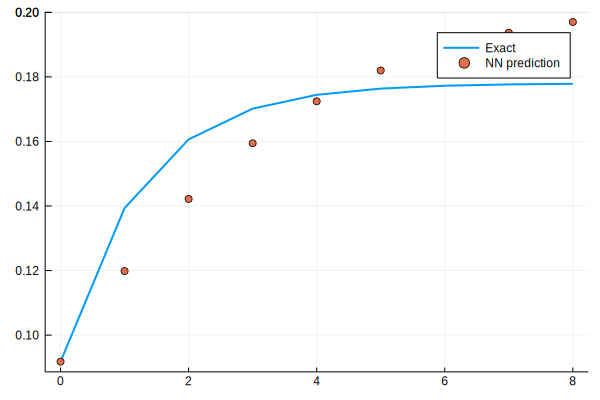

0.0060716816f0

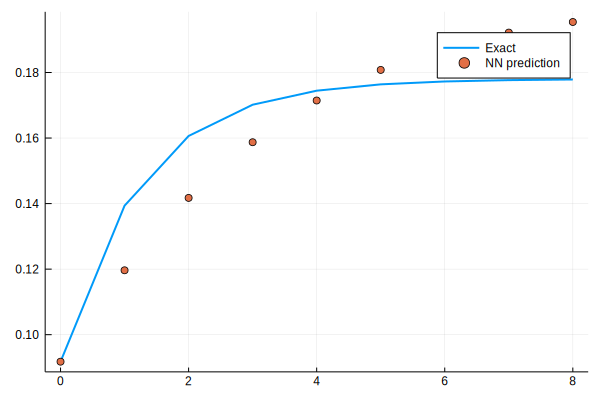

loss: 0.00607:  18%|███████▍                                 |  ETA: 0:00:57

0.0057929694f0

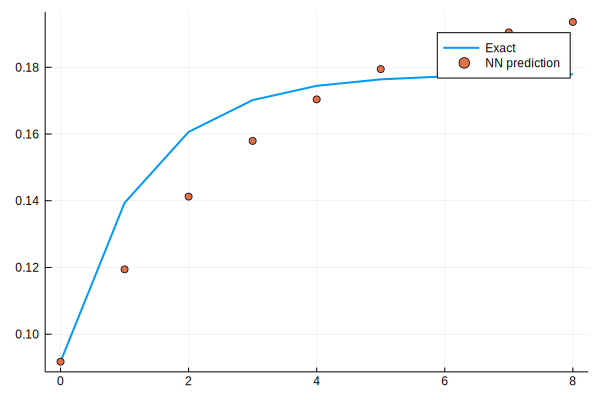

0.005525201f0

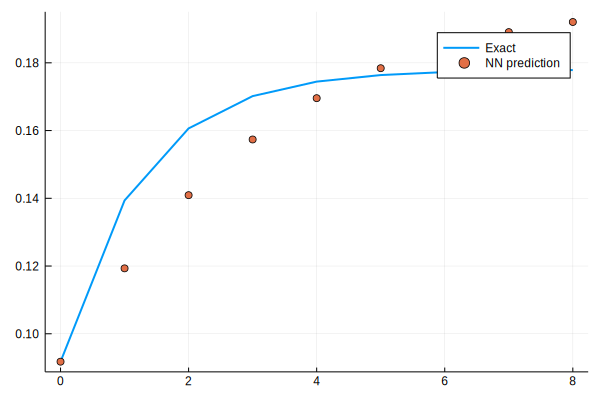

loss: 0.00553:  19%|███████▋                                 |  ETA: 0:00:55

0.0052323285f0

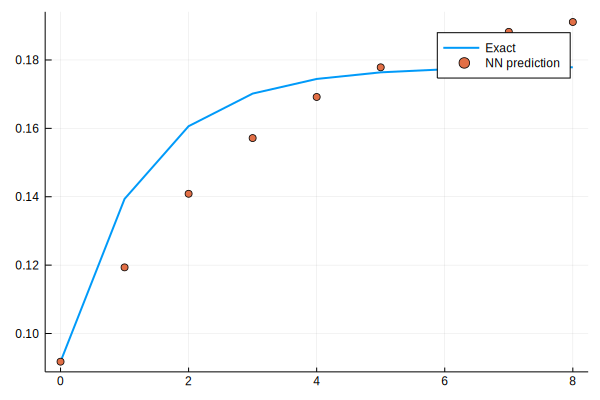

0.0049987924f0

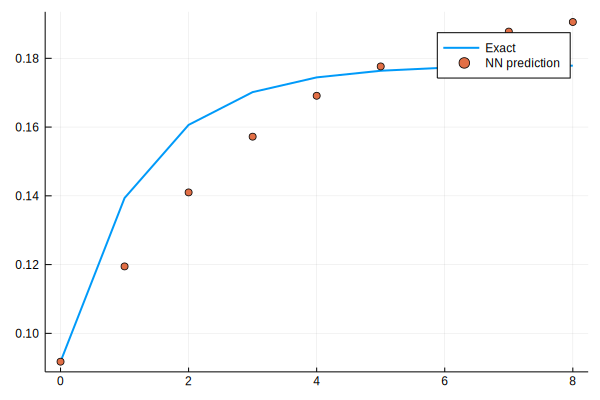

loss: 0.005:  19%|███████▉                                 |  ETA: 0:00:54

0.004878675f0

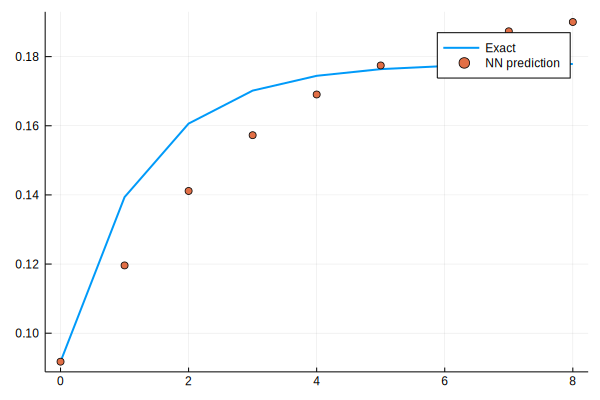

0.004803309f0

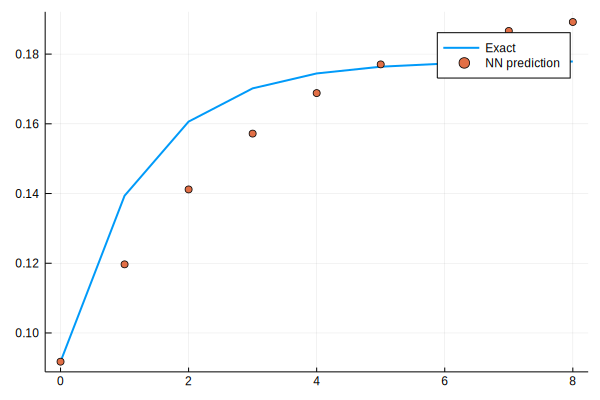

loss: 0.0048:  20%|████████▎                                |  ETA: 0:00:52

0.0046926825f0

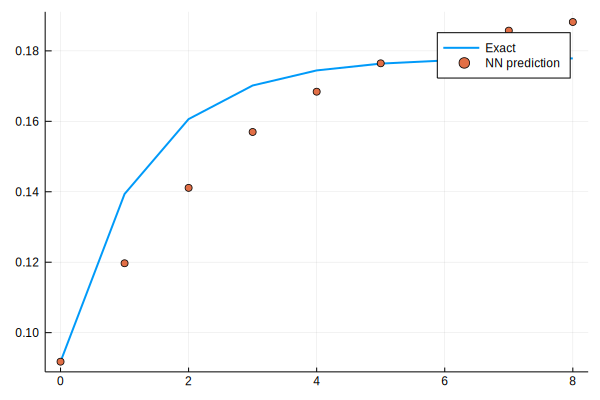

0.0045408346f0

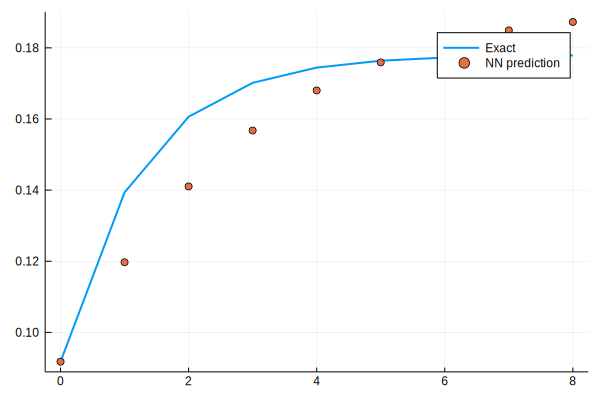

loss: 0.00454:  21%|████████▌                                |  ETA: 0:00:50

0.004389148f0

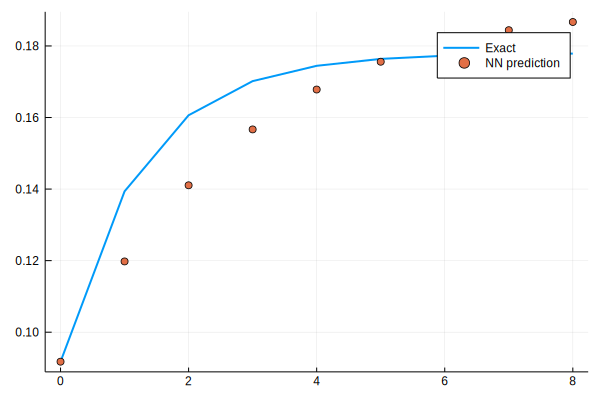

0.0042340728f0

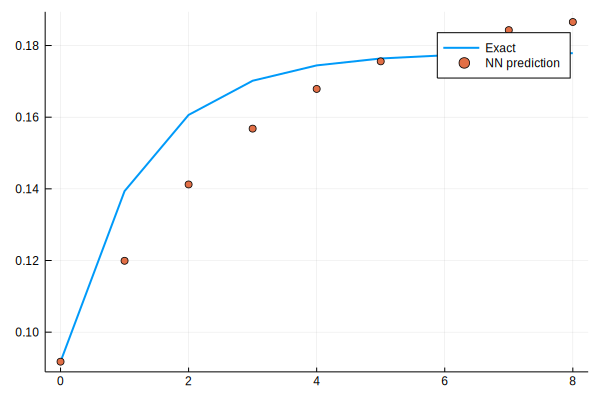

loss: 0.00423:  21%|████████▊                                |  ETA: 0:00:49

0.0040575326f0

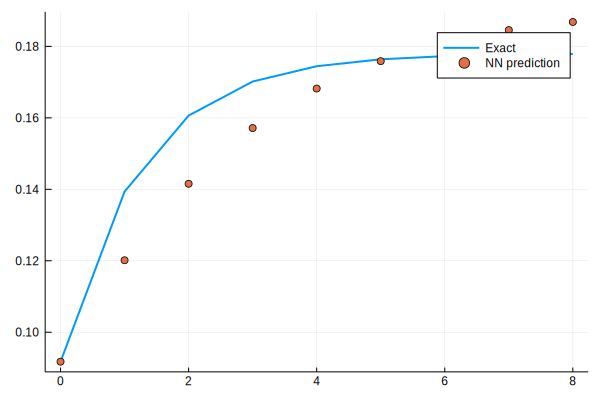

0.0038972741f0

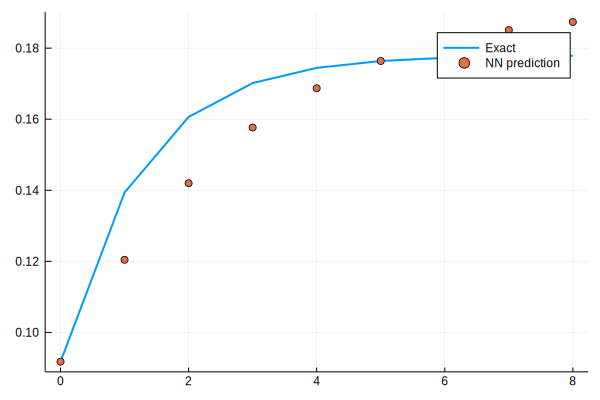

loss: 0.0039:  22%|█████████                                |  ETA: 0:00:47

0.0037660091f0

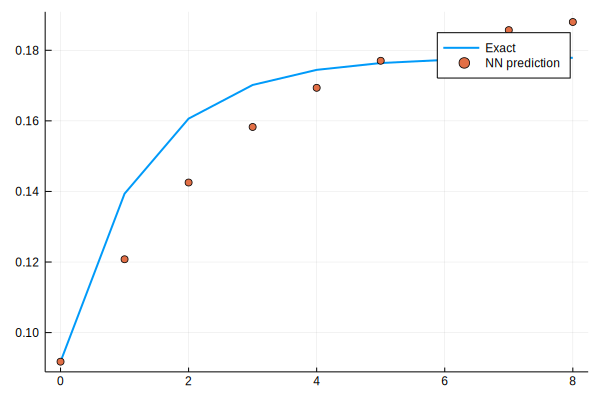

0.0036347534f0

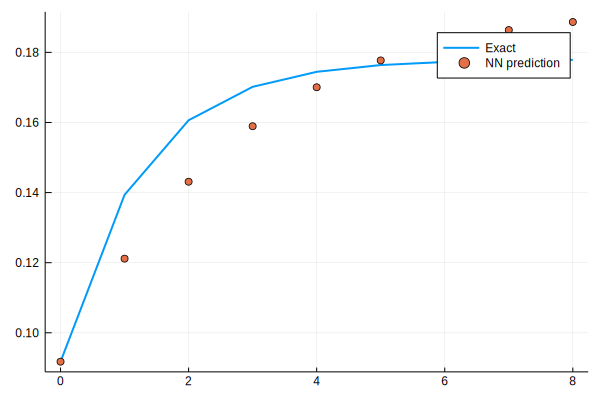

loss: 0.00363:  23%|█████████▎                               |  ETA: 0:00:46

0.0035033661f0

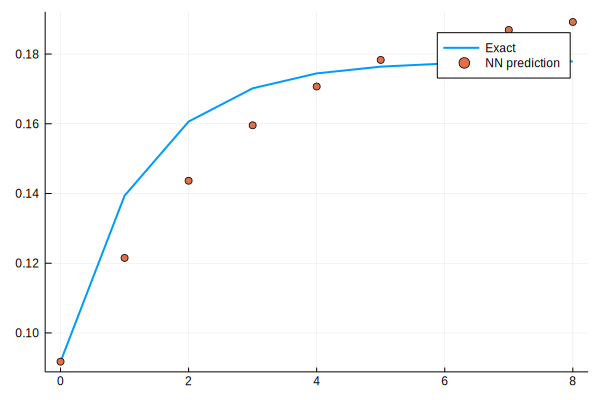

0.0033848344f0

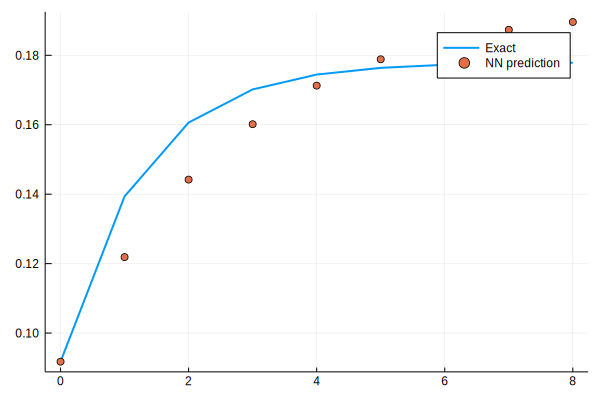

loss: 0.00338:  23%|█████████▌                               |  ETA: 0:00:45

0.0032838196f0

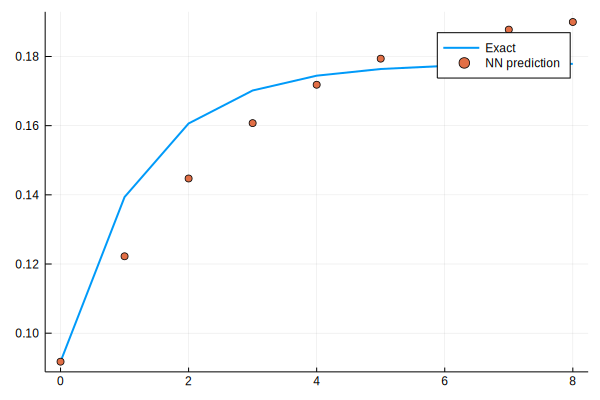

0.0031952043f0

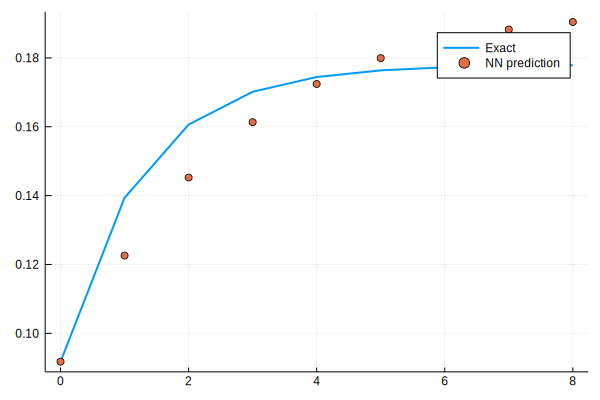

loss: 0.0032:  24%|█████████▉                               |  ETA: 0:00:44

0.0031079797f0

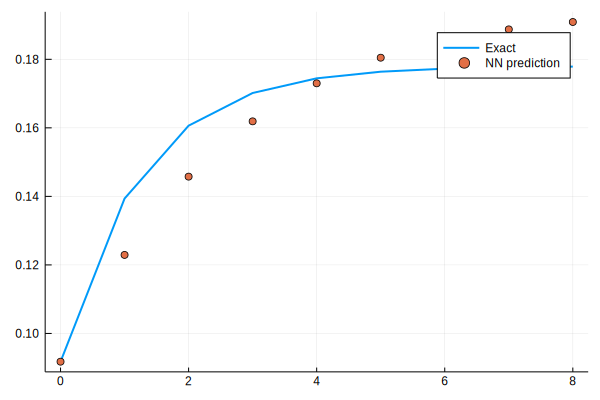

0.0030168134f0

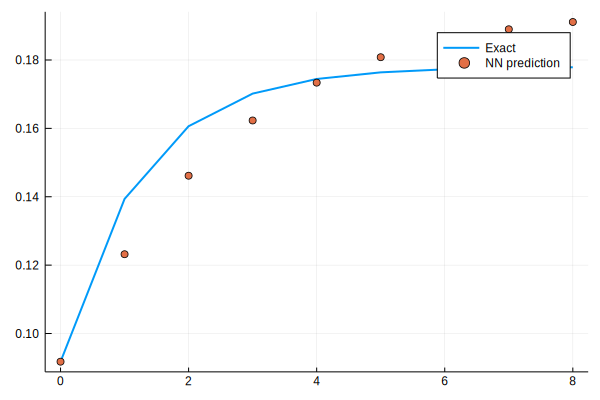

loss: 0.00302:  25%|██████████▏                              |  ETA: 0:00:43

0.0029169994f0

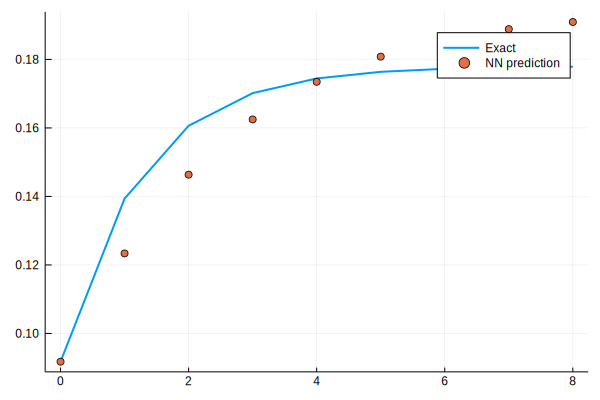

0.0028191237f0

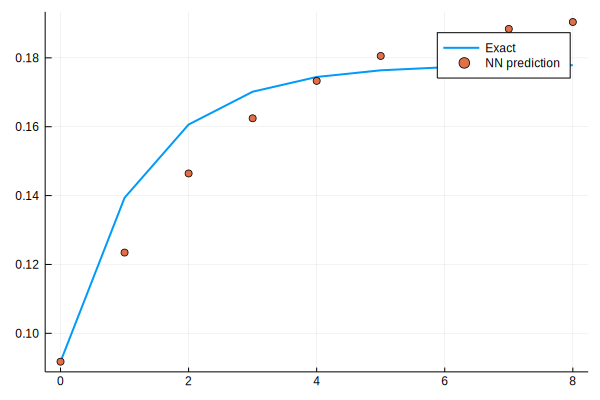

loss: 0.00282:  25%|██████████▍                              |  ETA: 0:00:42

0.0027324588f0

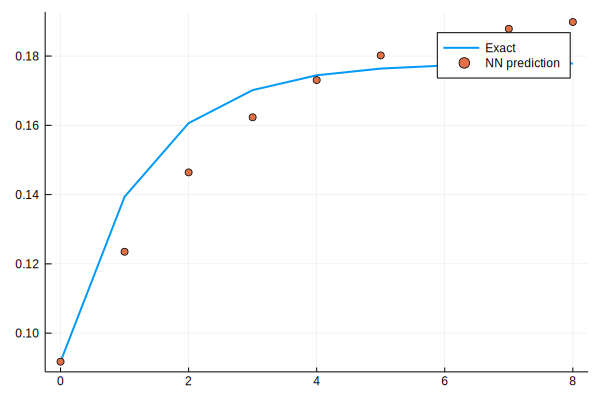

0.0026443372f0

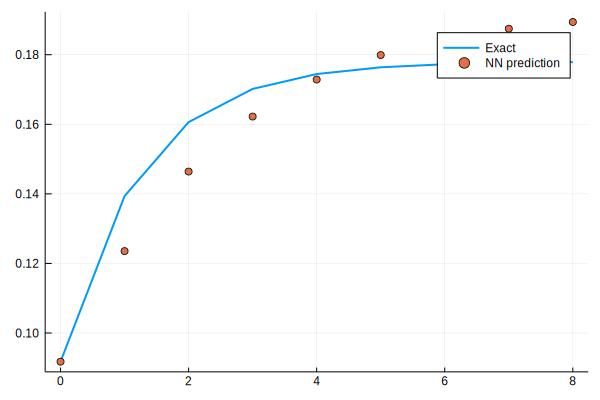

loss: 0.00264:  26%|██████████▋                              |  ETA: 0:00:41

0.002554324f0

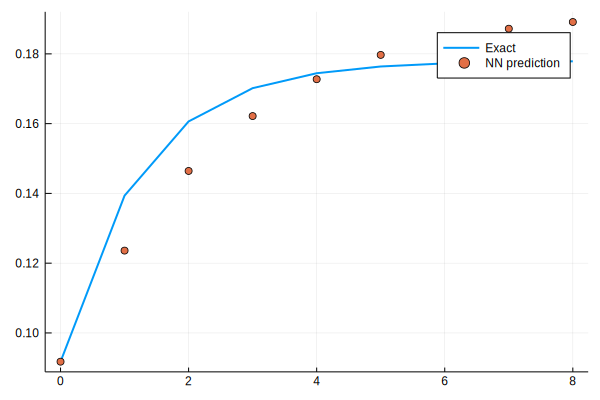

0.0024715068f0

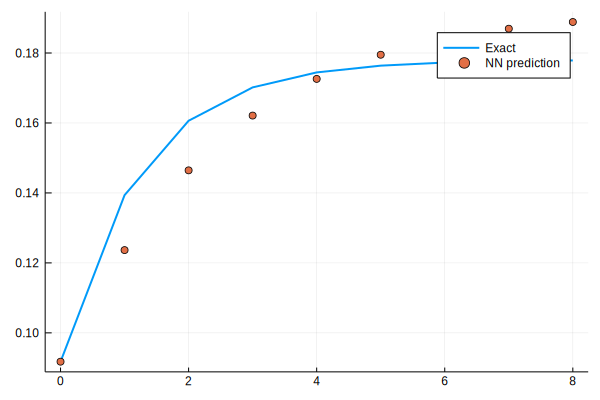

loss: 0.00247:  27%|██████████▉                              |  ETA: 0:00:40

0.002395062f0

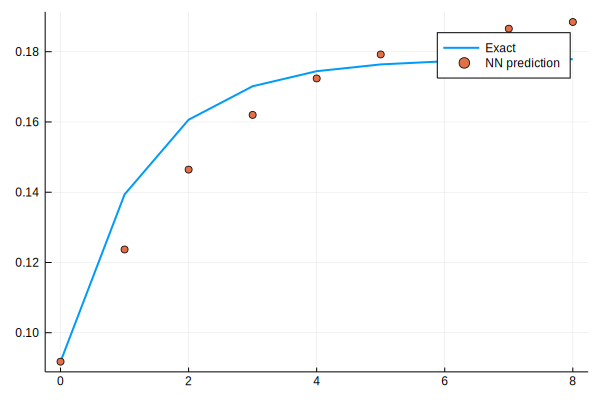

0.0023225008f0

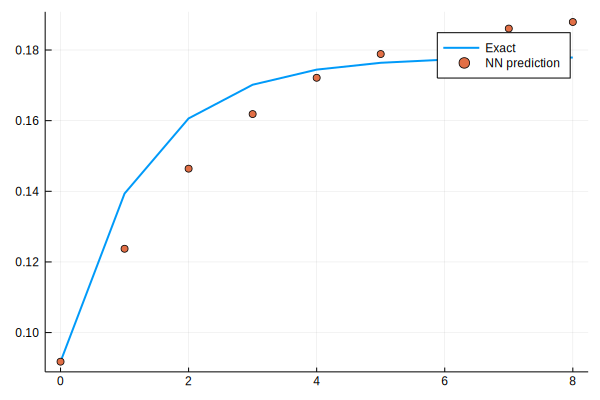

loss: 0.00232:  27%|███████████▎                             |  ETA: 0:00:39

0.0022545753f0

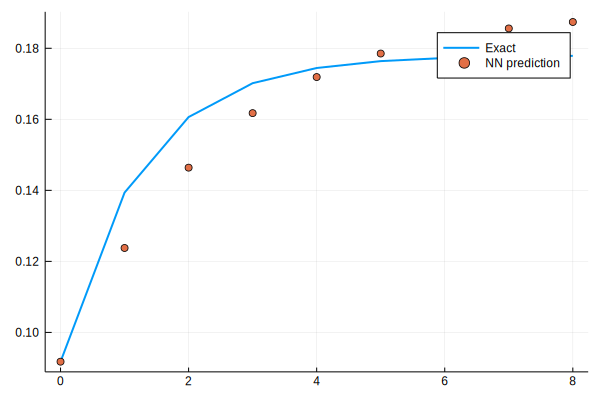

0.0021918274f0

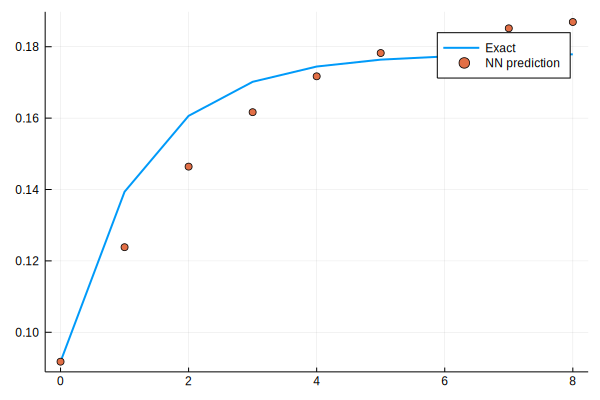

loss: 0.00219:  28%|███████████▌                             |  ETA: 0:00:38

0.0021293291f0

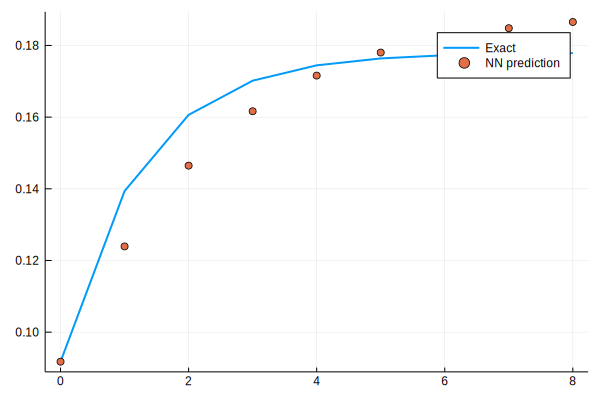

0.002067292f0

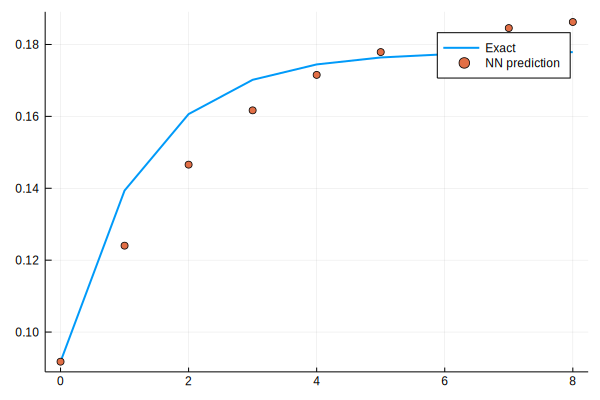

loss: 0.00207:  29%|███████████▊                             |  ETA: 0:00:37

0.0020079575f0

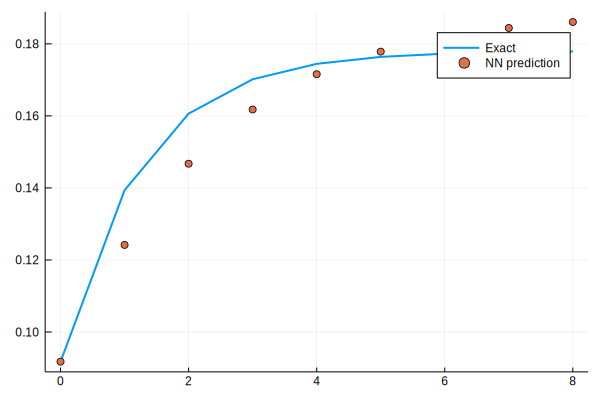

0.001947323f0

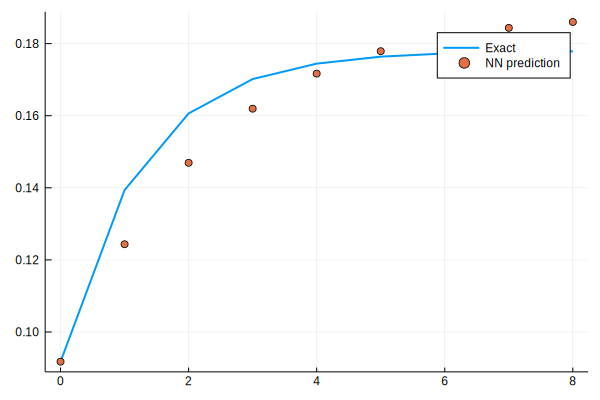

loss: 0.00195:  29%|████████████                             |  ETA: 0:00:36

0.0018869704f0

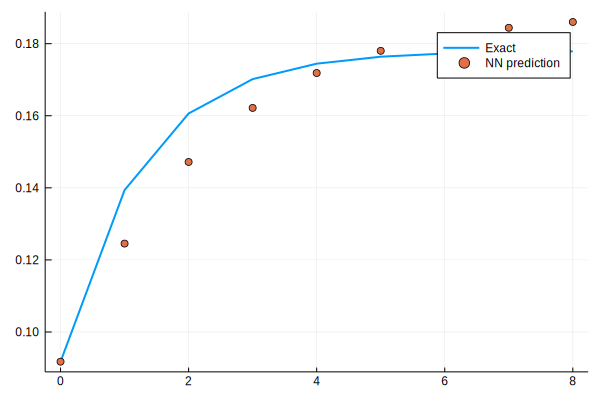

0.0018295835f0

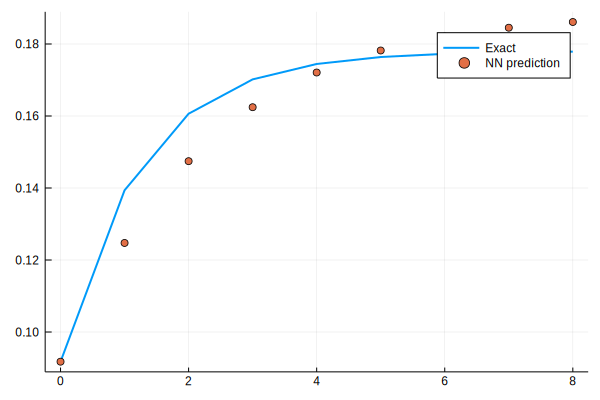

loss: 0.00183:  30%|████████████▎                            |  ETA: 0:00:35

0.0017746892f0

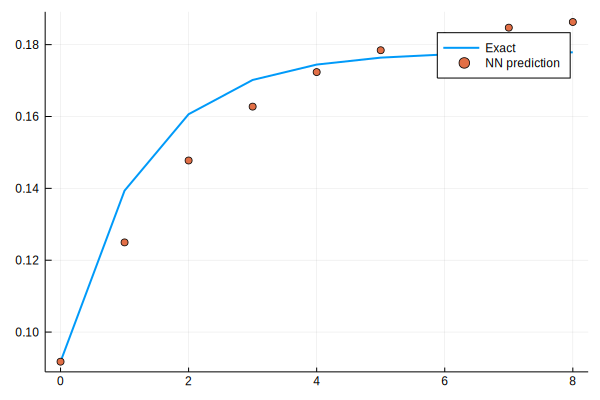

0.0017225792f0

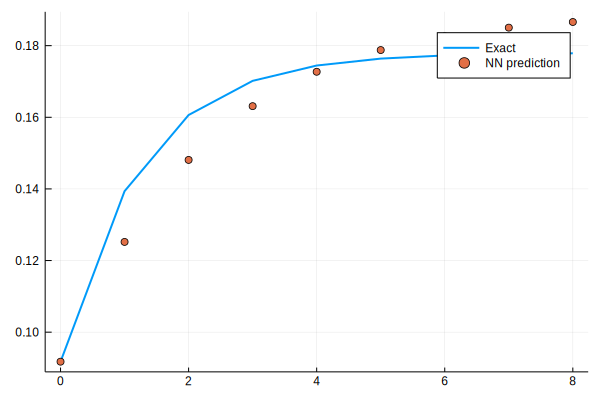

loss: 0.00172:  31%|████████████▌                            |  ETA: 0:00:35

0.0016737445f0

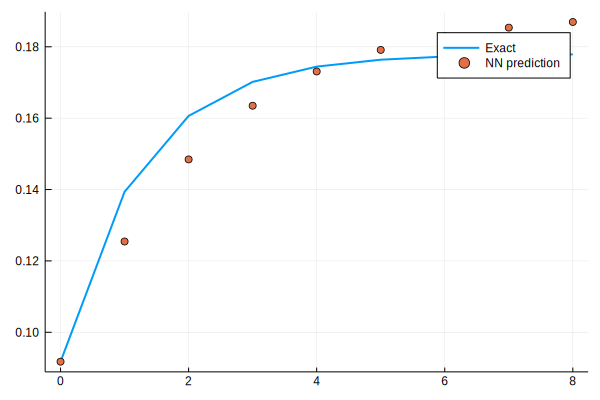

0.0016273936f0

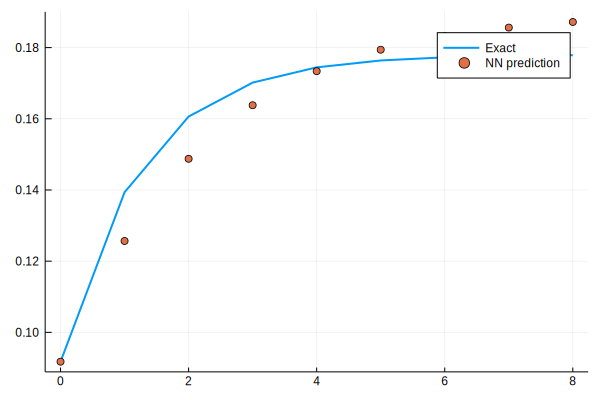

loss: 0.00163:  31%|████████████▉                            |  ETA: 0:00:34

0.0015814787f0

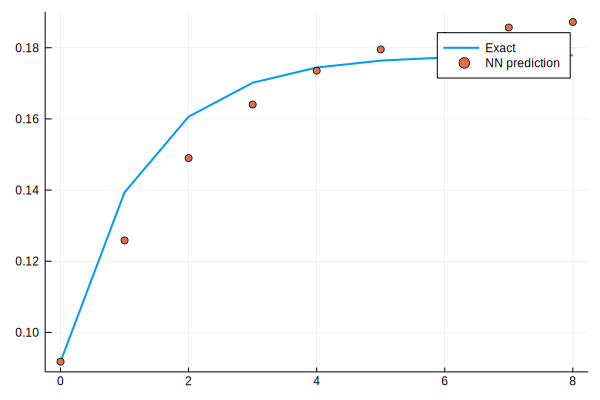

0.0015371239f0

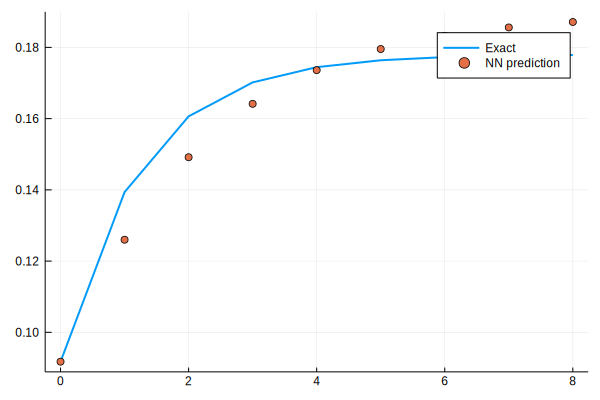

loss: 0.00154:  32%|█████████████▏                           |  ETA: 0:00:33

0.0014945044f0

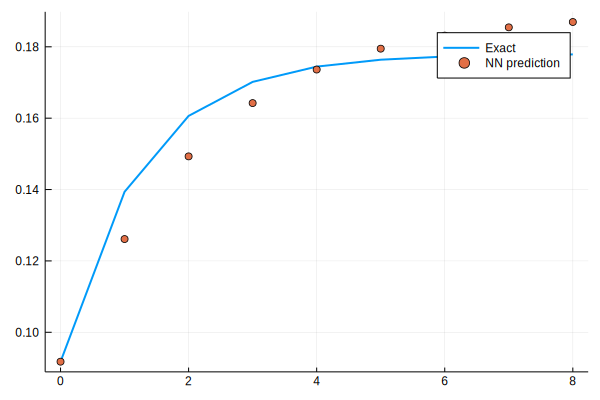

0.0014521981f0

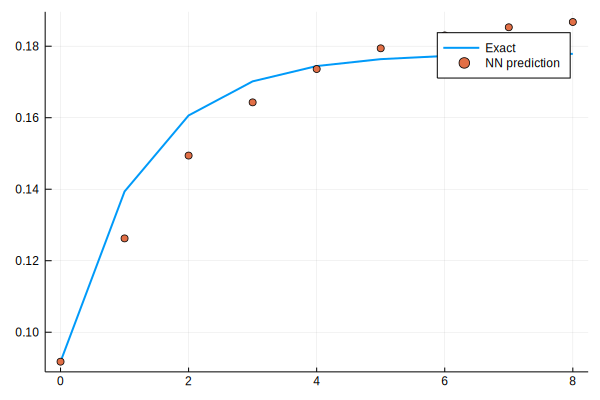

loss: 0.00145:  33%|█████████████▍                           |  ETA: 0:00:33

0.0014108999f0

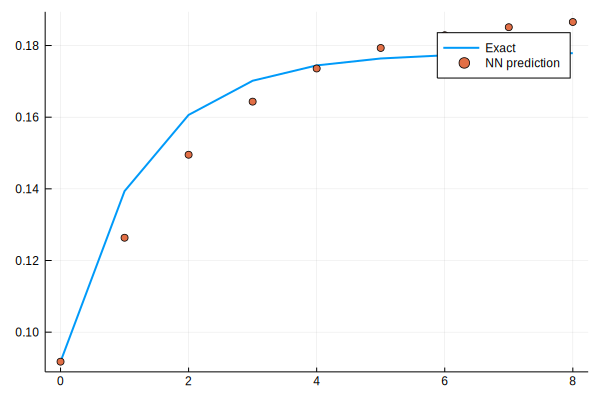

0.0013712419f0

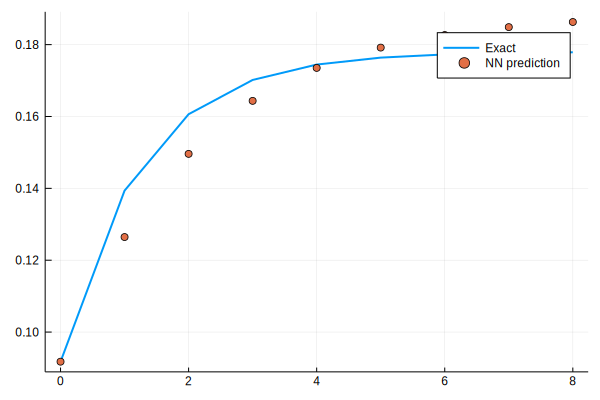

loss: 0.00137:  33%|█████████████▋                           |  ETA: 0:00:32

0.0013330176f0

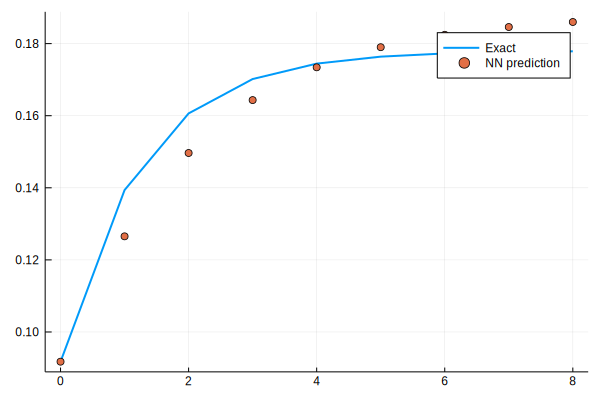

0.0012954862f0

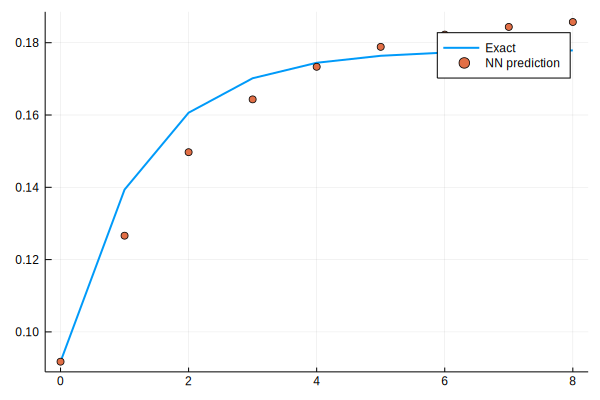

loss: 0.0013:  34%|██████████████                           |  ETA: 0:00:31

0.0012590333f0

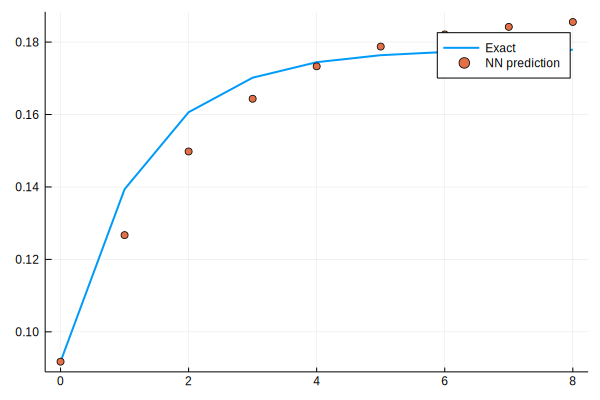

0.0012238013f0

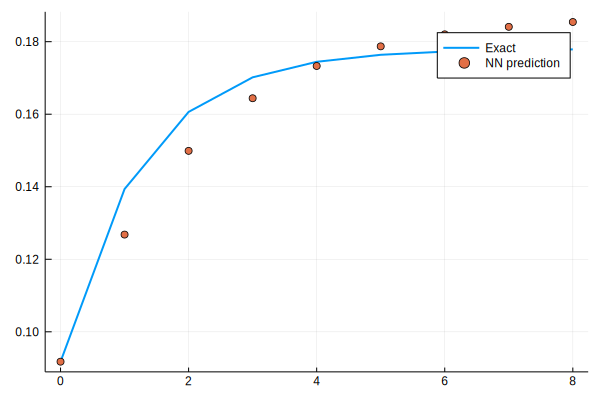

loss: 0.00122:  35%|██████████████▏                          |  ETA: 0:00:31

0.0011900618f0

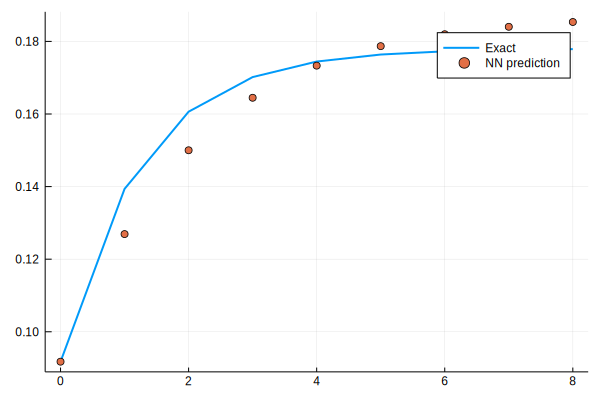

0.0011580181f0

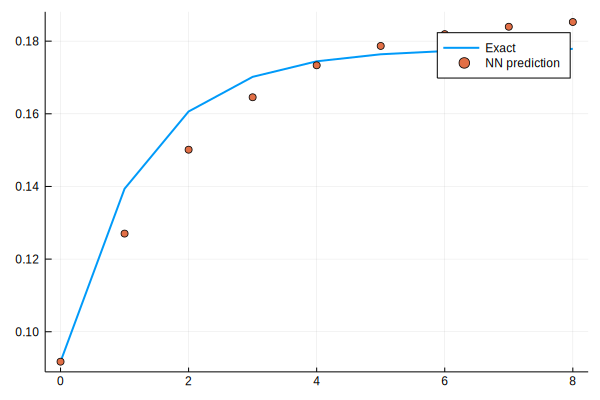

loss: 0.00116:  35%|██████████████▌                          |  ETA: 0:00:30

0.0011269366f0

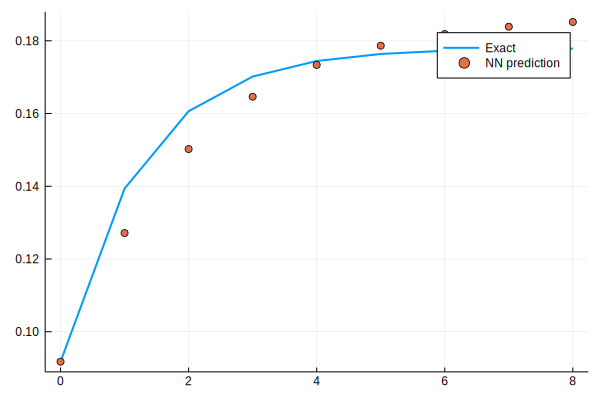

0.001096691f0

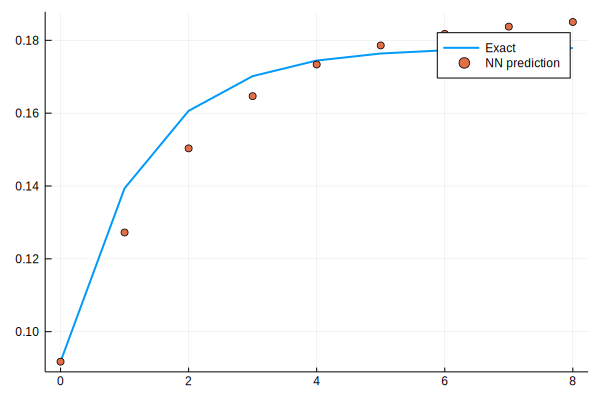

loss: 0.0011:  36%|██████████████▊                          |  ETA: 0:00:29

0.0010670793f0

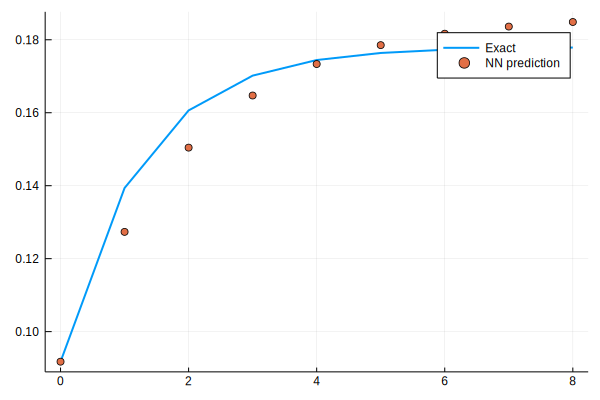

0.0010380802f0

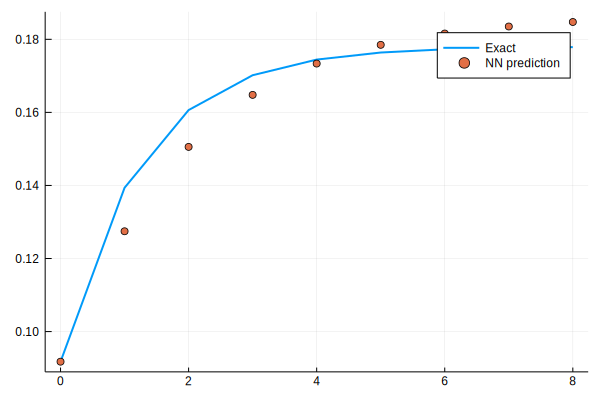

loss: 0.00104:  37%|███████████████                          |  ETA: 0:00:29

0.0010098845f0

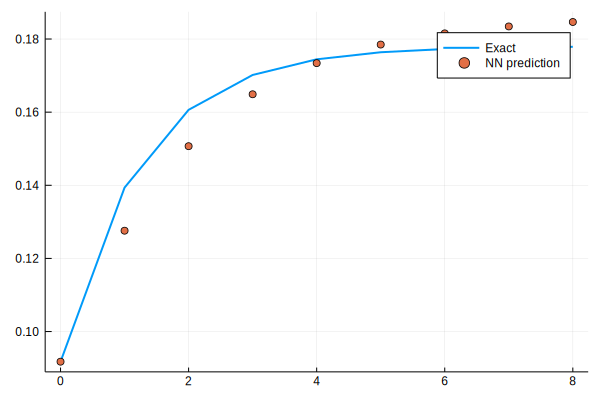

0.0009826501f0

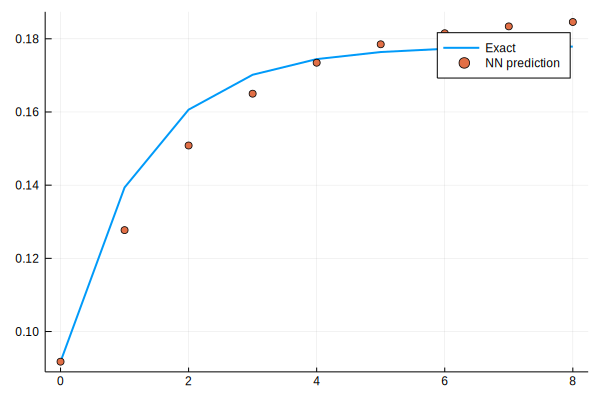

loss: 0.000983:  37%|███████████████▎                         |  ETA: 0:00:28

0.0009561889f0

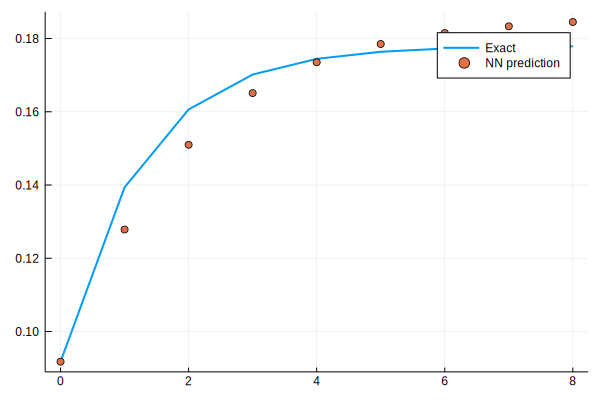

0.0009305634f0

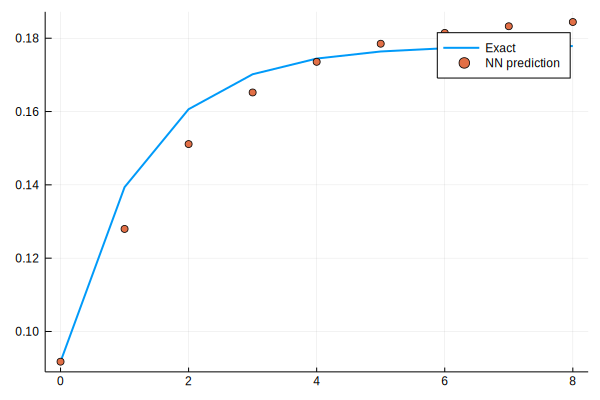

loss: 0.000931:  38%|███████████████▋                         |  ETA: 0:00:28

0.00090589275f0

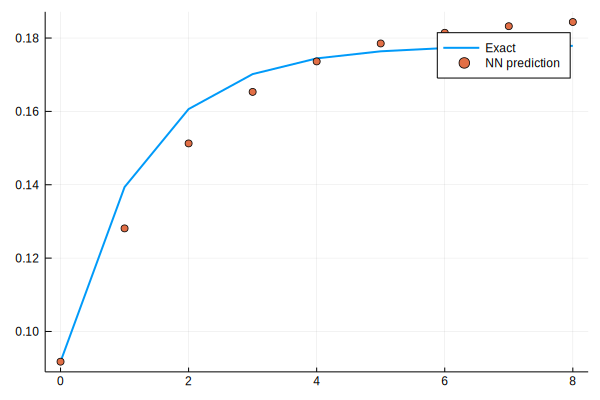

0.00088190706f0

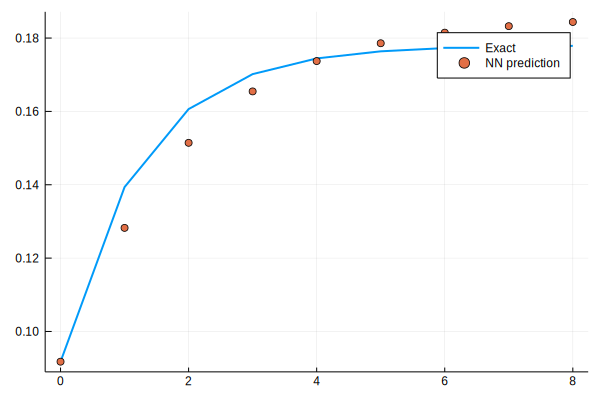

loss: 0.000882:  39%|███████████████▉                         |  ETA: 0:00:27

0.00085863343f0

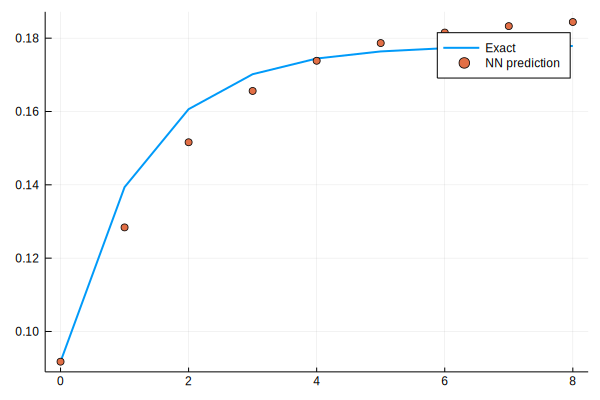

0.0008360674f0

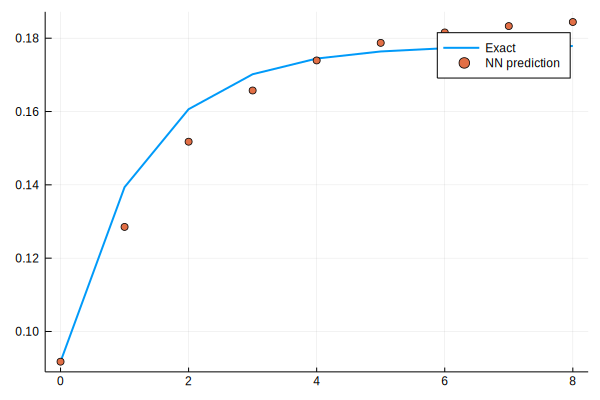

loss: 0.000836:  39%|████████████████▏                        |  ETA: 0:00:27

0.00081418554f0

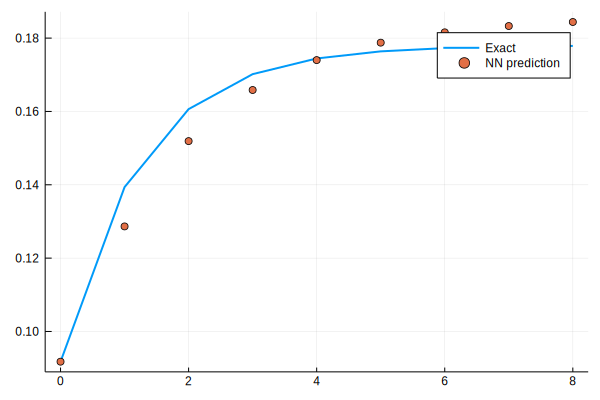

0.00079287577f0

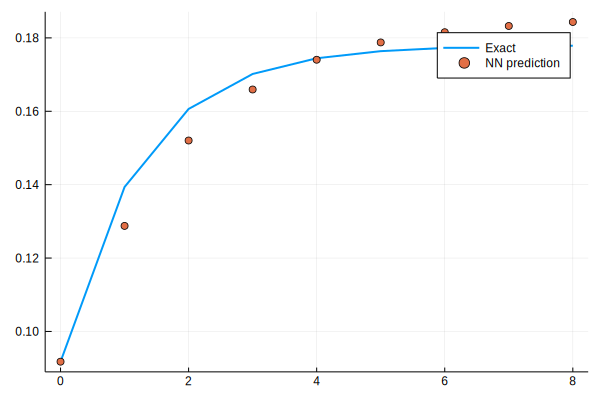

loss: 0.000793:  40%|████████████████▍                        |  ETA: 0:00:26

0.0007722354f0

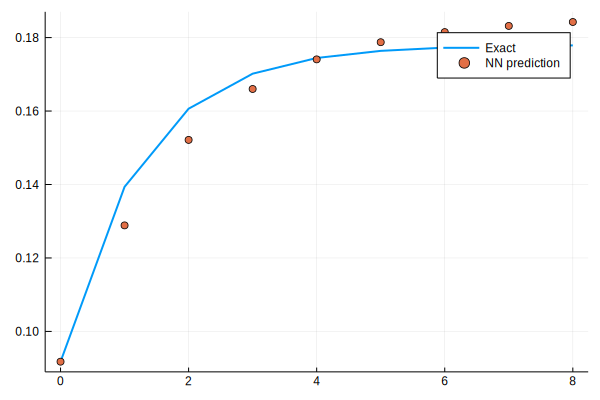

0.0007521611f0

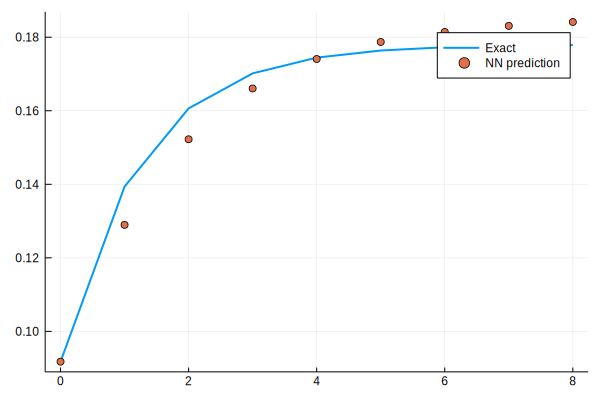

loss: 0.000752:  41%|████████████████▋                        |  ETA: 0:00:26

0.0007325559f0

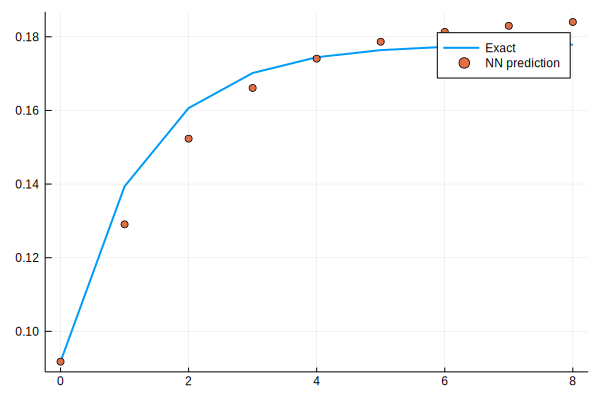

0.0007134465f0

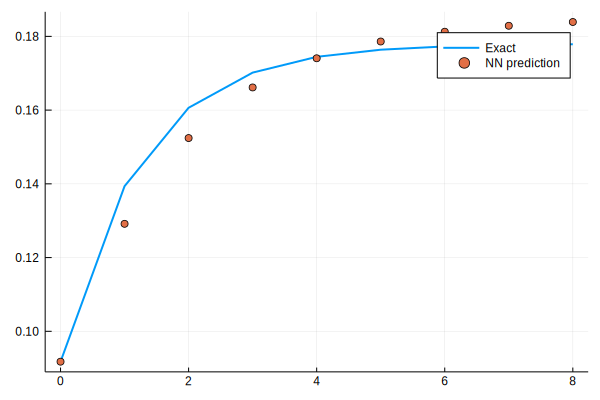

loss: 0.000713:  41%|████████████████▉                        |  ETA: 0:00:25

0.00069490215f0

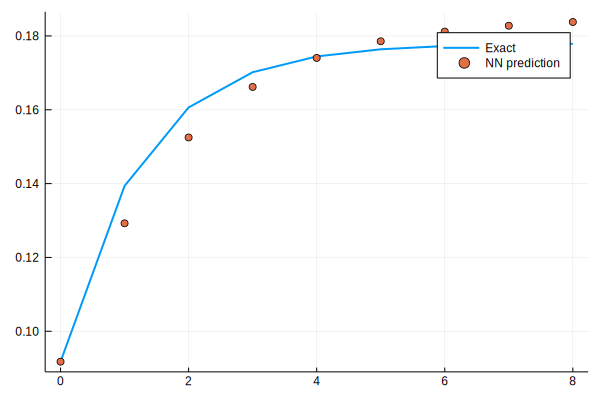

0.00067696674f0

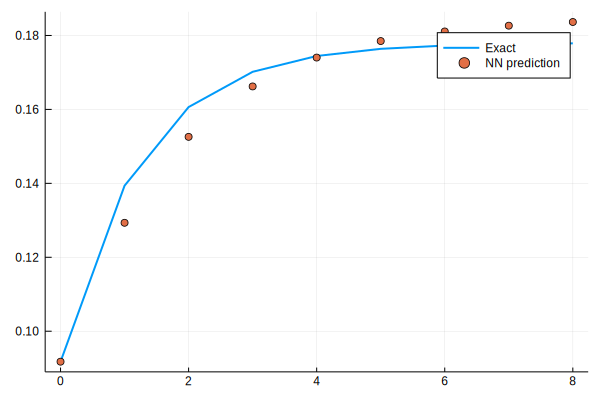

loss: 0.000677:  42%|█████████████████▎                       |  ETA: 0:00:25

0.00065961265f0

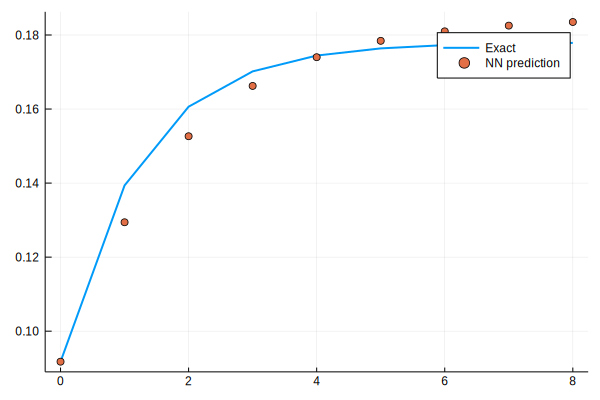

0.0006427612f0

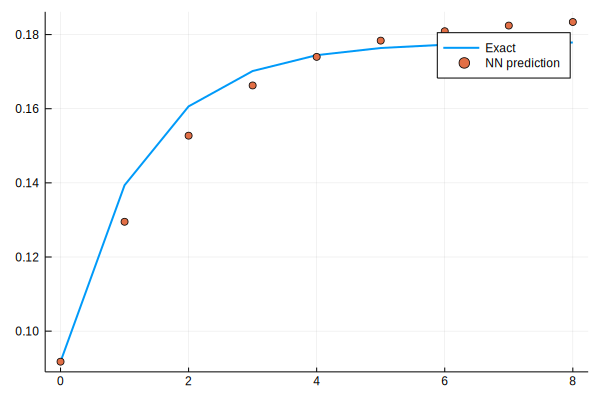

loss: 0.000643:  43%|█████████████████▌                       |  ETA: 0:00:24

0.00062632735f0

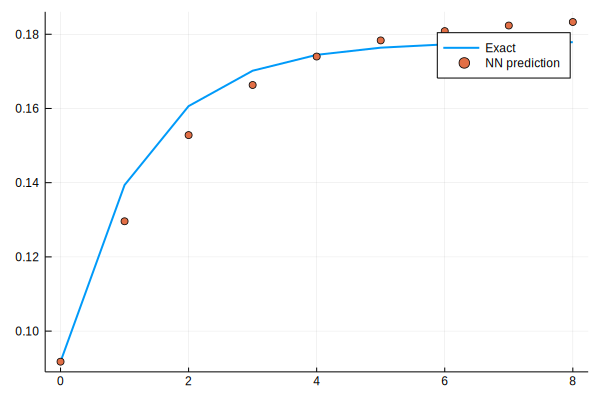

0.0006103328f0

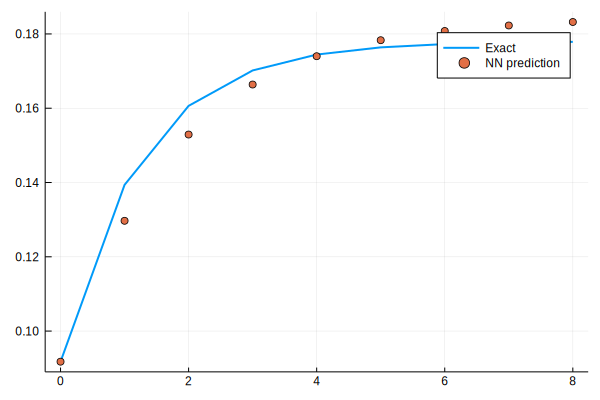

loss: 0.00061:  43%|█████████████████▊                       |  ETA: 0:00:24

0.000594783f0

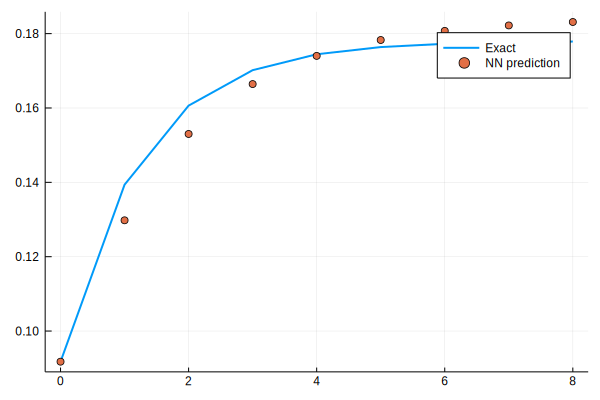

0.0005796897f0

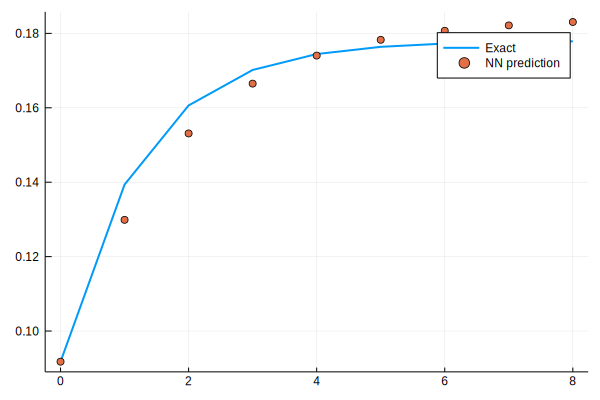

loss: 0.00058:  44%|██████████████████                       |  ETA: 0:00:23

0.00056500995f0

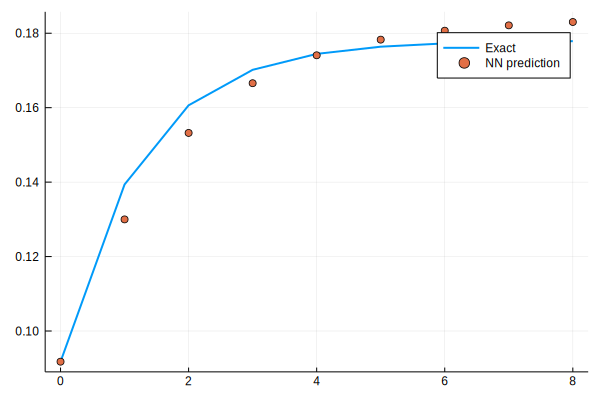

0.00055070716f0

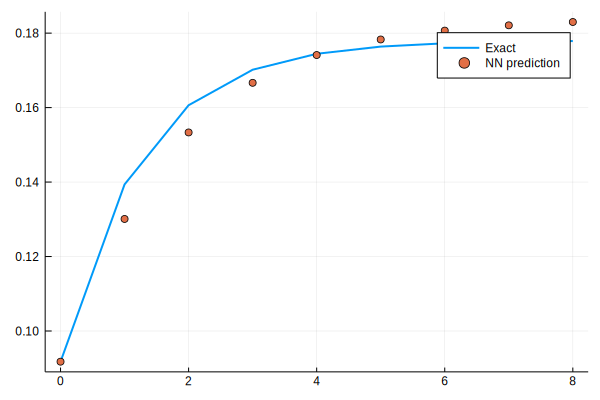

loss: 0.000551:  45%|██████████████████▎                      |  ETA: 0:00:23

0.00053677795f0

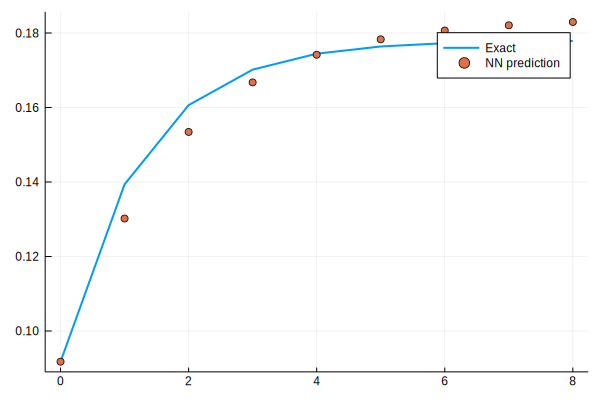

0.0005232432f0

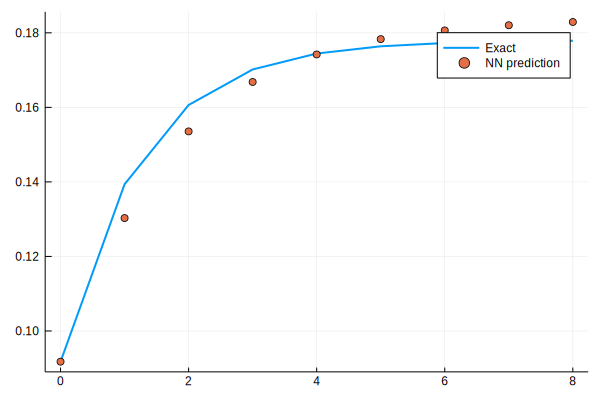

loss: 0.000523:  45%|██████████████████▋                      |  ETA: 0:00:23

0.0005100907f0

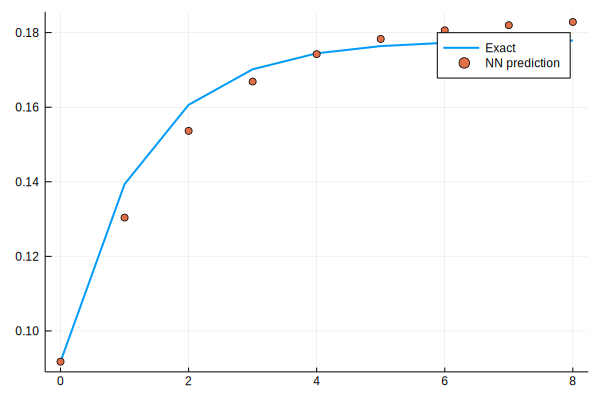

0.0004973016f0

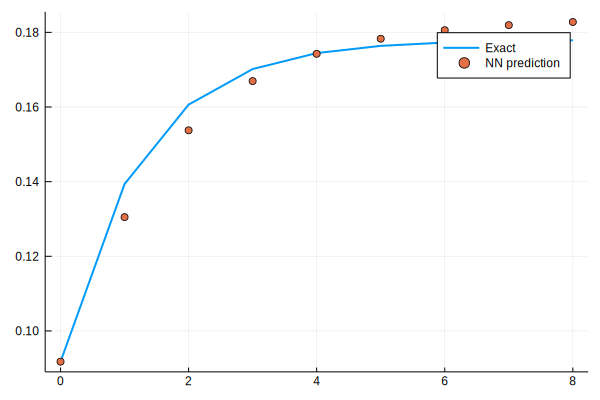

loss: 0.000497:  46%|██████████████████▉                      |  ETA: 0:00:22

0.00048486068f0

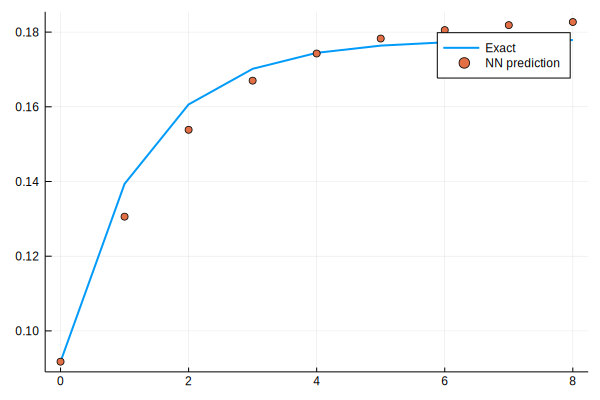

0.00047276303f0

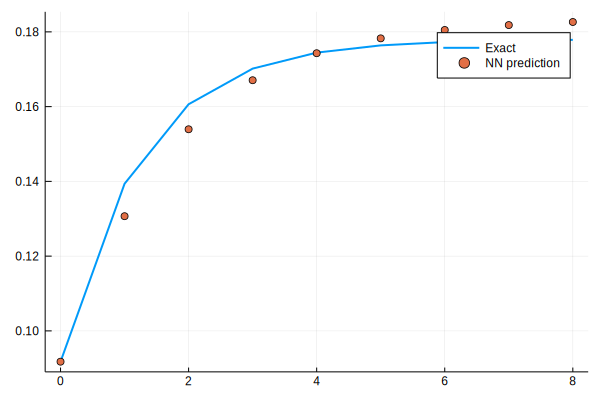

loss: 0.000473:  47%|███████████████████▏                     |  ETA: 0:00:22

0.0004609921f0

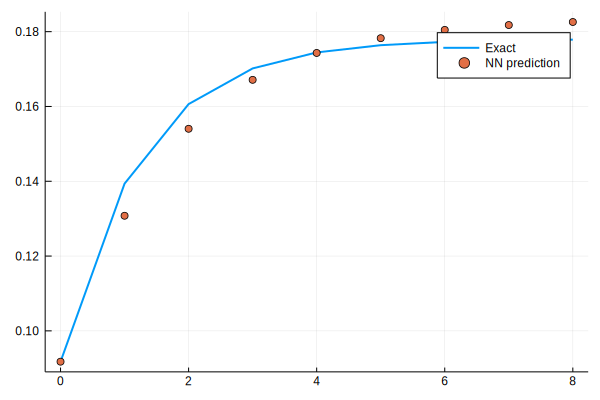

0.00044953375f0

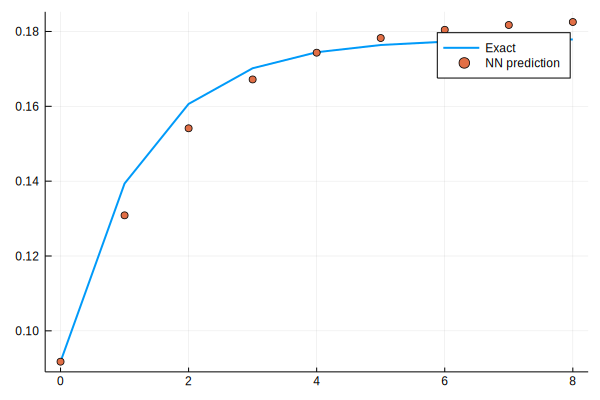

loss: 0.00045:  47%|███████████████████▍                     |  ETA: 0:00:21

0.0004383784f0

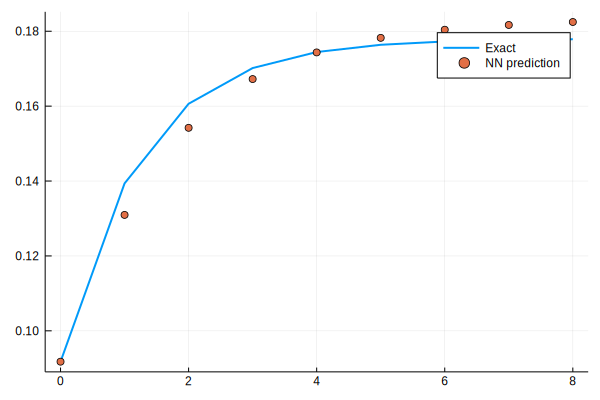

0.0004275105f0

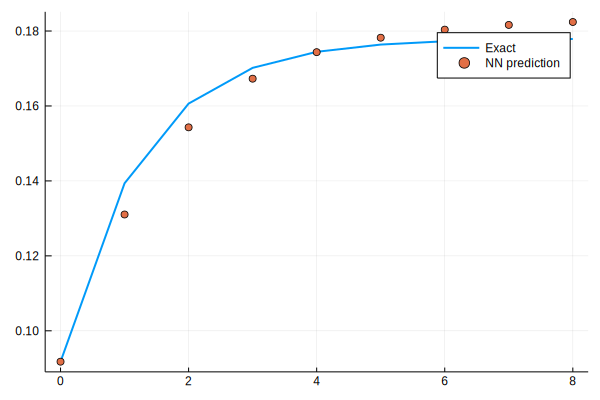

loss: 0.000428:  48%|███████████████████▋                     |  ETA: 0:00:21

0.00041692954f0

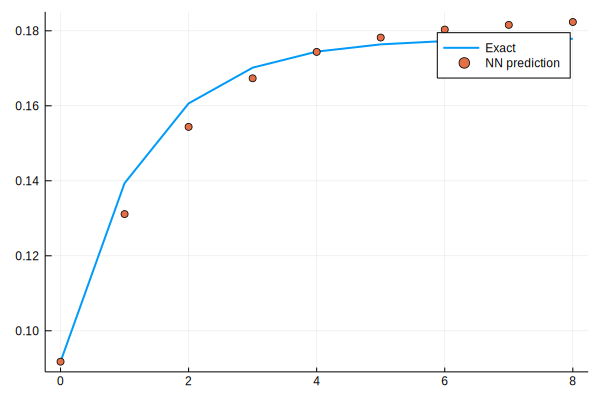

0.000406624f0

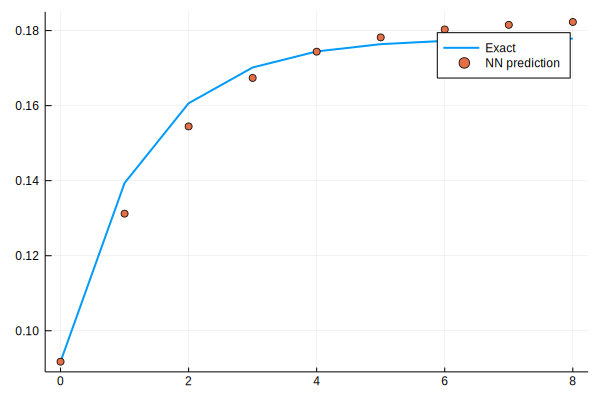

loss: 0.000407:  49%|███████████████████▉                     |  ETA: 0:00:21

0.00039659964f0

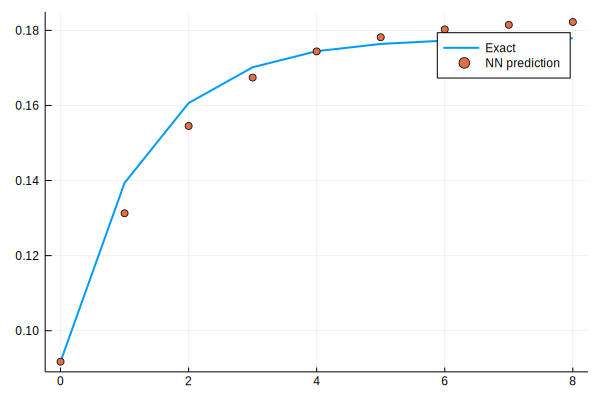

0.00038685356f0

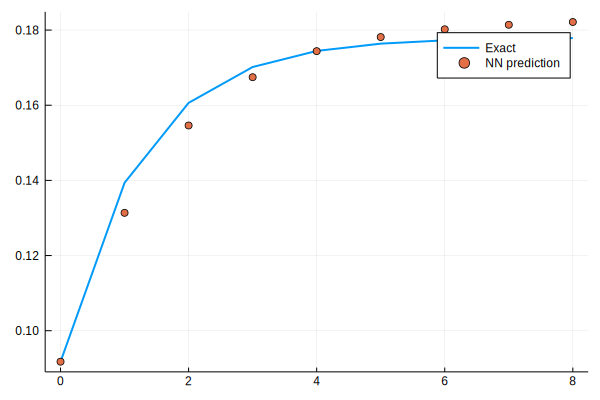

loss: 0.000387:  49%|████████████████████▎                    |  ETA: 0:00:20

0.00037734836f0

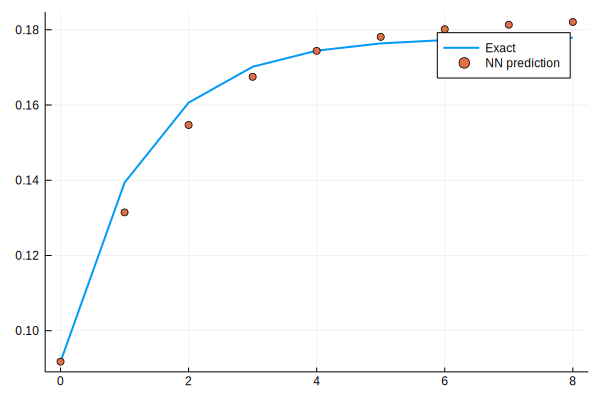

0.00036809006f0

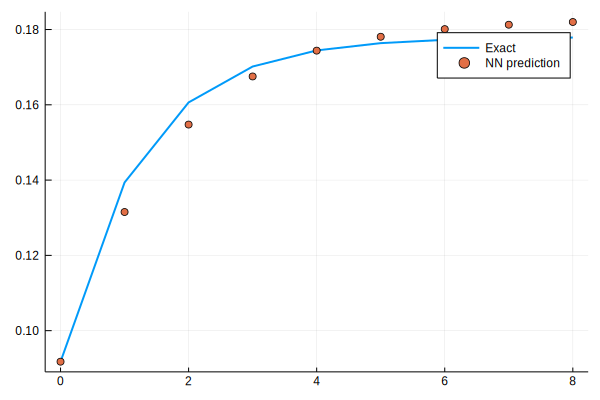

loss: 0.000368:  50%|████████████████████▌                    |  ETA: 0:00:20

0.0003590809f0

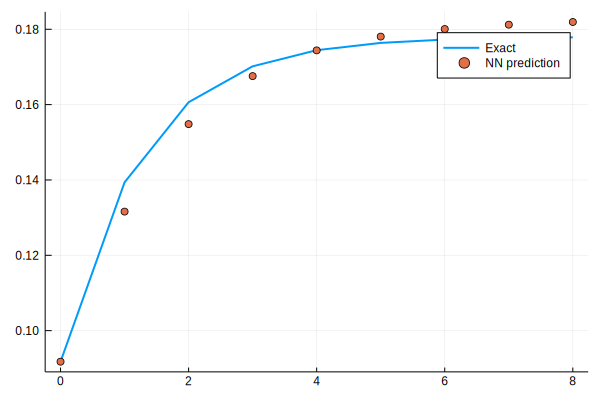

0.00035031117f0

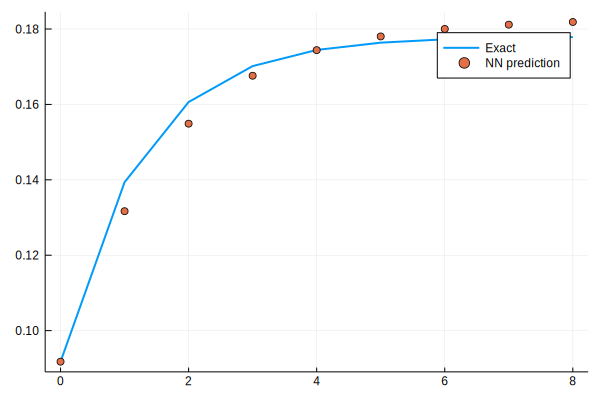

loss: 0.00035:  51%|████████████████████▊                    |  ETA: 0:00:19

0.00034177065f0

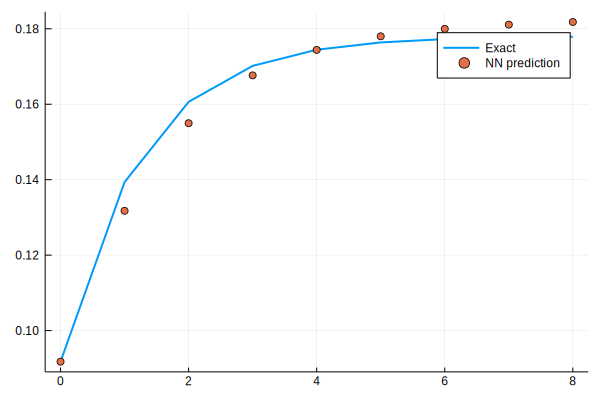

0.00033344614f0

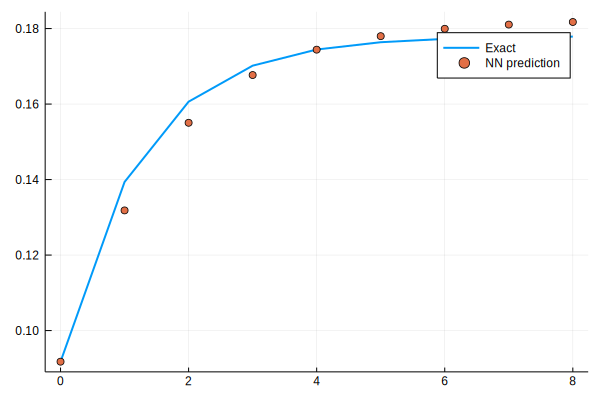

loss: 0.000333:  51%|█████████████████████                    |  ETA: 0:00:19

0.00032533455f0

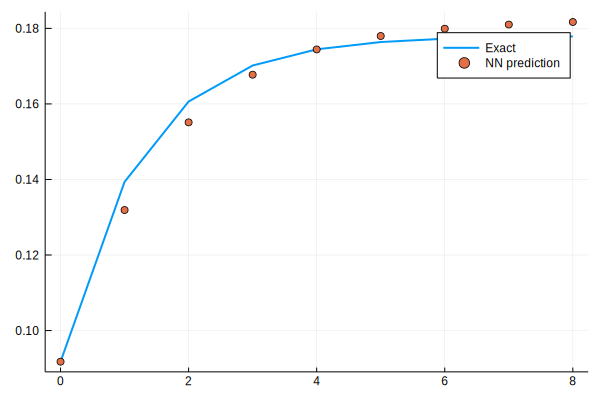

0.00031742972f0

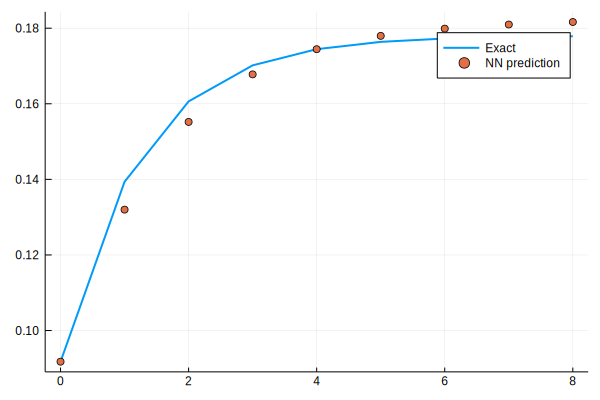

loss: 0.000317:  52%|█████████████████████▍                   |  ETA: 0:00:19

0.00030973423f0

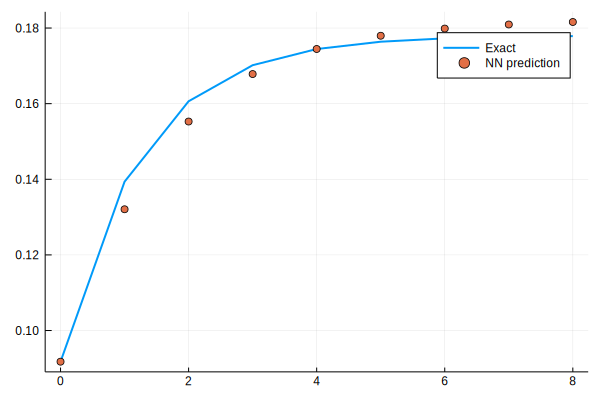

0.00030223376f0

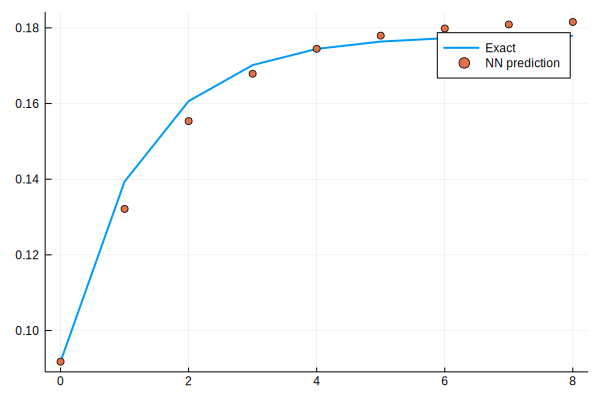

loss: 0.000302:  53%|█████████████████████▋                   |  ETA: 0:00:18

0.0002949267f0

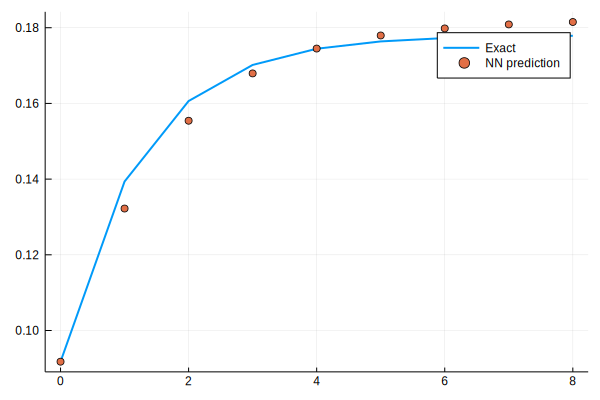

0.00028780277f0

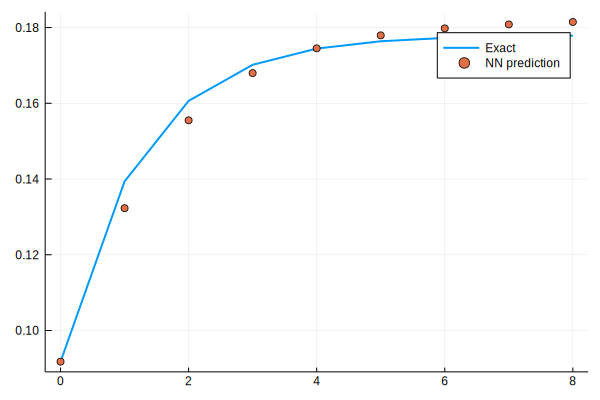

loss: 0.000288:  53%|█████████████████████▉                   |  ETA: 0:00:18

0.00028086815f0

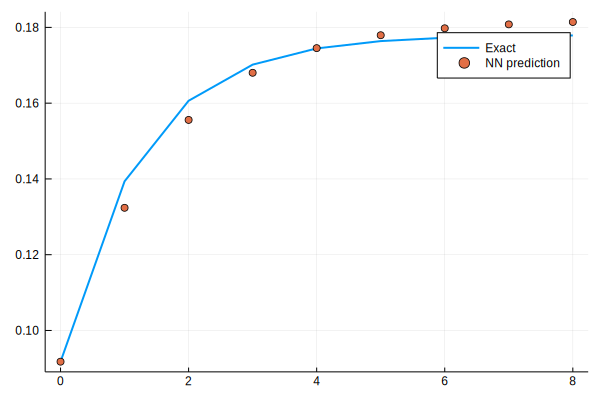

0.00027410957f0

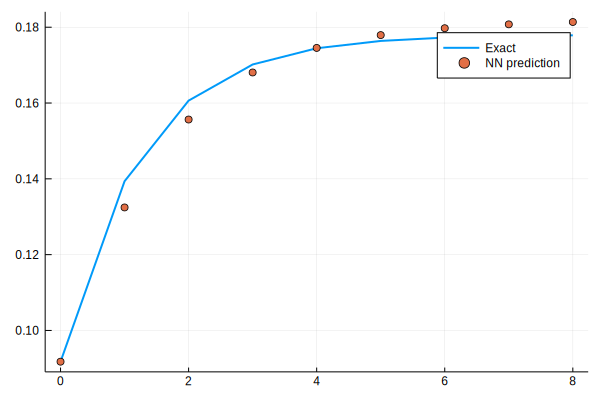

loss: 0.000274:  54%|██████████████████████▏                  |  ETA: 0:00:18

0.0002675204f0

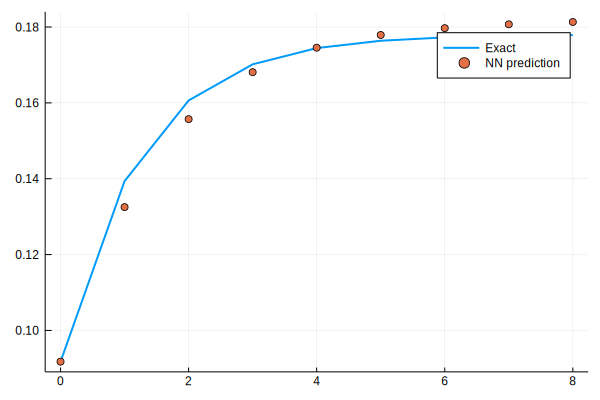

loss: 0.000268:  54%|██████████████████████▎                  |  ETA: 0:00:18

0.00026109815f0

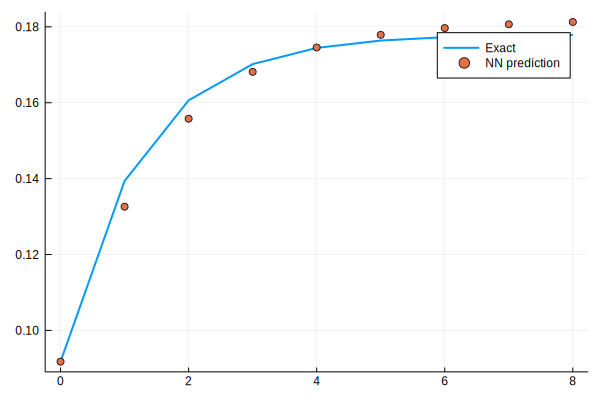

0.0002548376f0

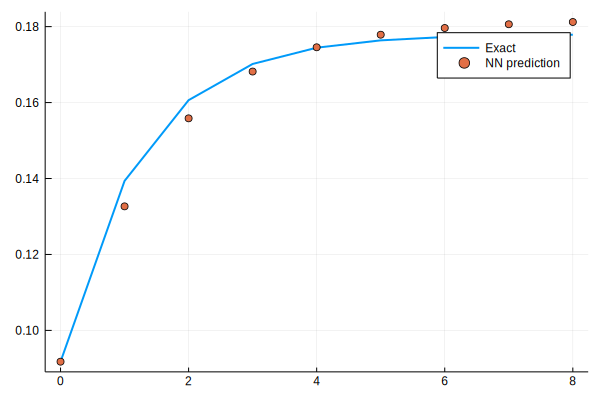

loss: 0.000255:  55%|██████████████████████▌                  |  ETA: 0:00:17

0.00024873533f0

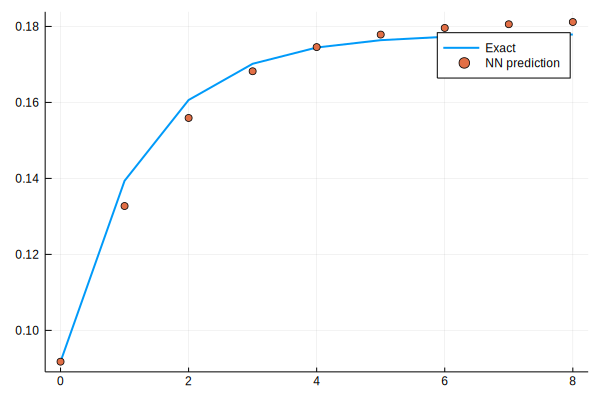

0.00024278827f0

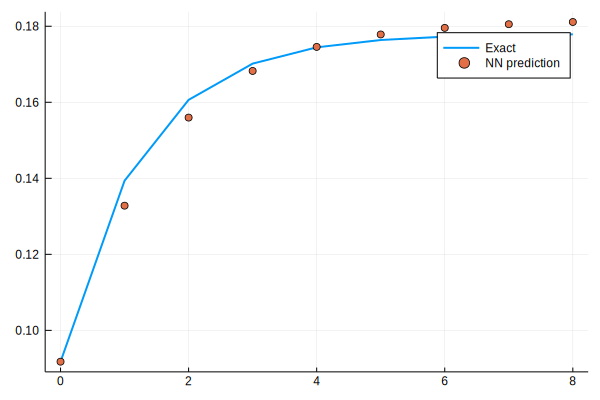

loss: 0.000243:  56%|██████████████████████▊                  |  ETA: 0:00:17

0.00023699024f0

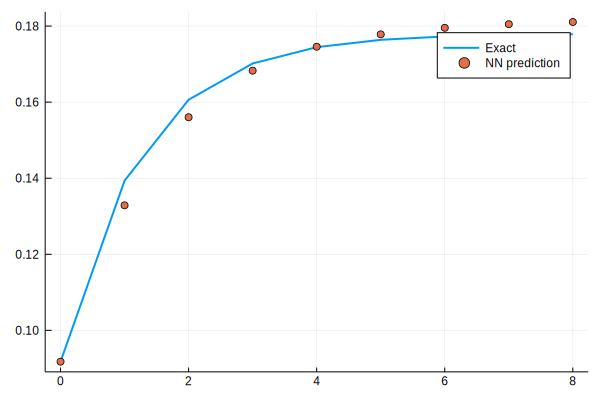

0.00023133852f0

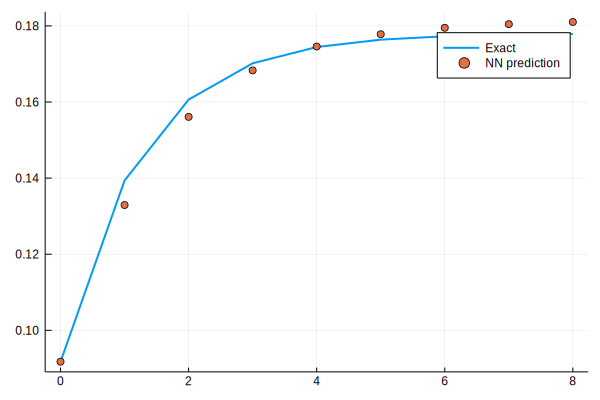

loss: 0.000231:  56%|███████████████████████▏                 |  ETA: 0:00:17

0.00022582736f0

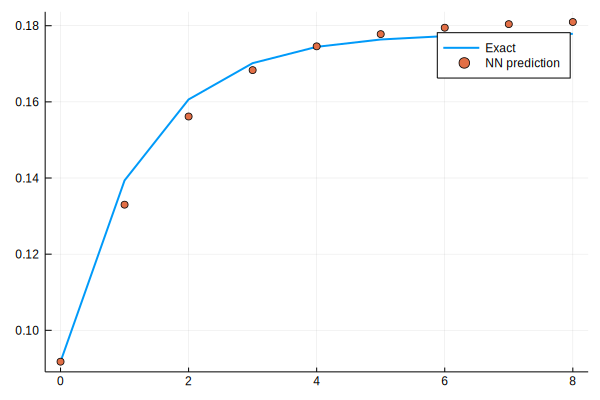

0.00022045492f0

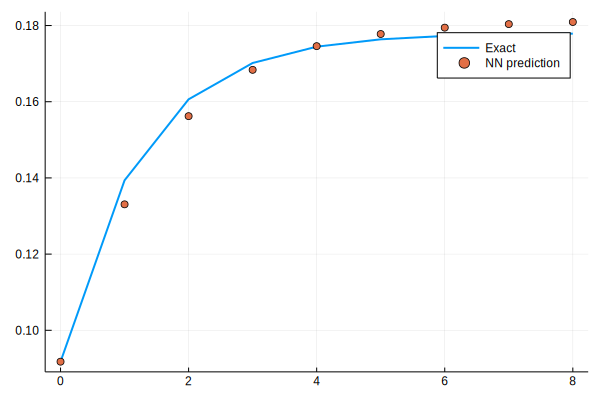

loss: 0.00022:  57%|███████████████████████▍                 |  ETA: 0:00:16

0.0002152179f0

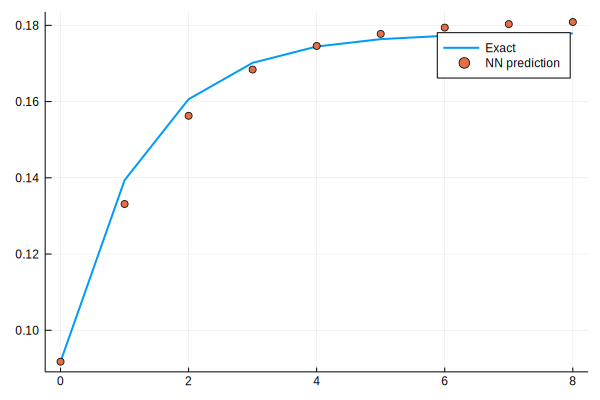

0.00021011231f0

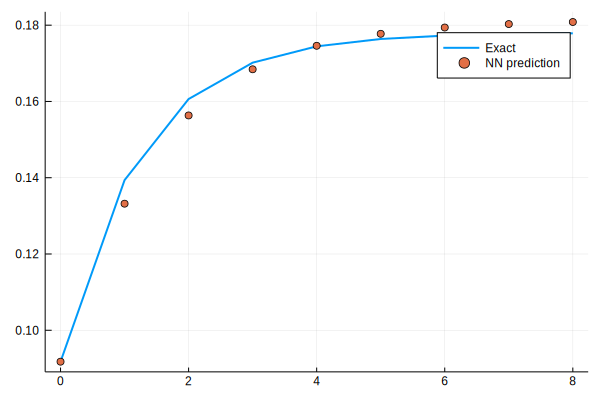

loss: 0.00021:  58%|███████████████████████▋                 |  ETA: 0:00:16

0.00020513264f0

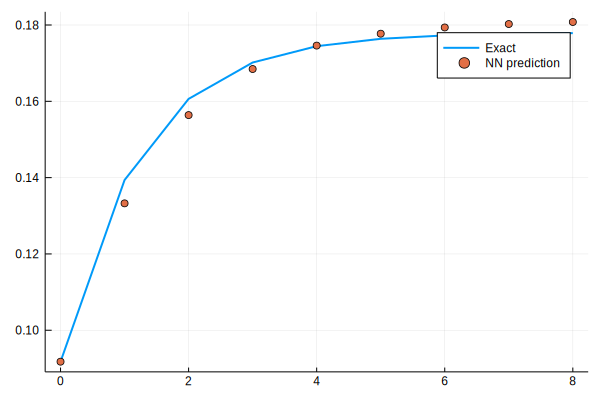

0.000200277f0

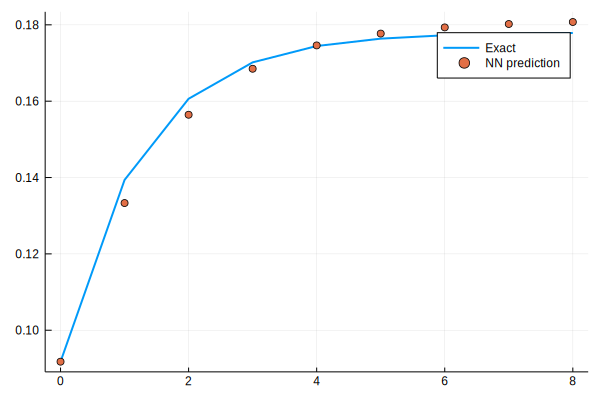

loss: 0.0002:  58%|███████████████████████▉                 |  ETA: 0:00:16

0.00019554219f0

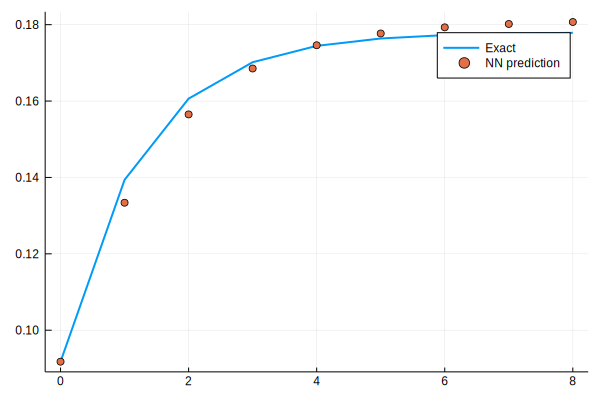

0.00019092488f0

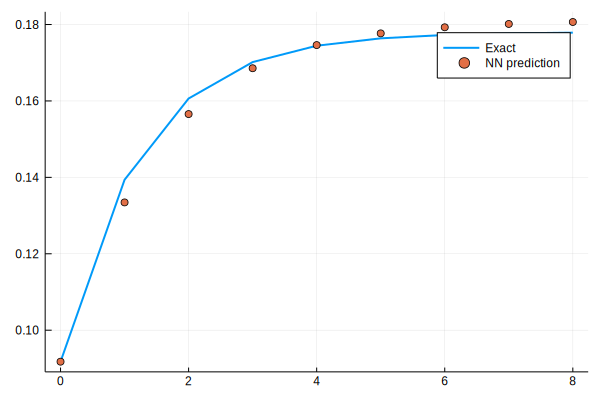

loss: 0.000191:  59%|████████████████████████▎                |  ETA: 0:00:15

0.00018642149f0

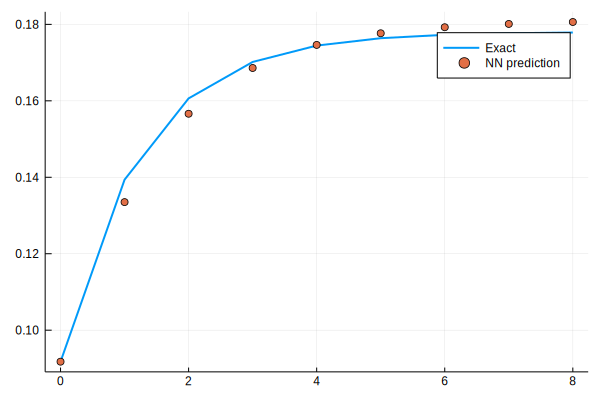

0.00018203107f0

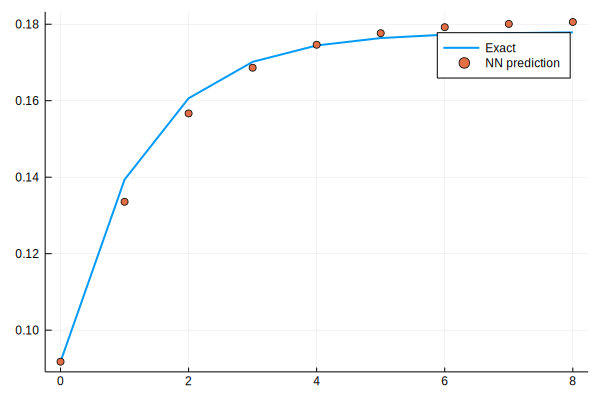

loss: 0.000182:  60%|████████████████████████▍                |  ETA: 0:00:15

0.00017774924f0

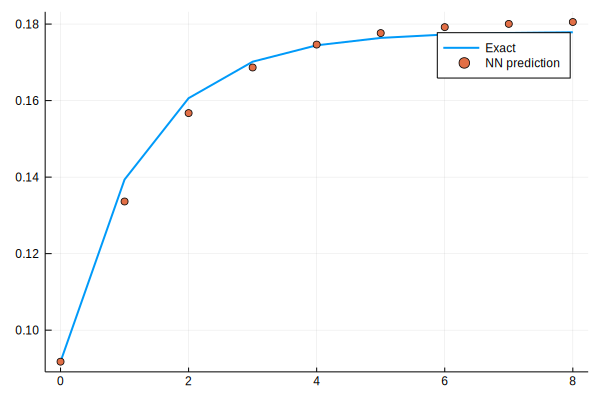

0.00017357264f0

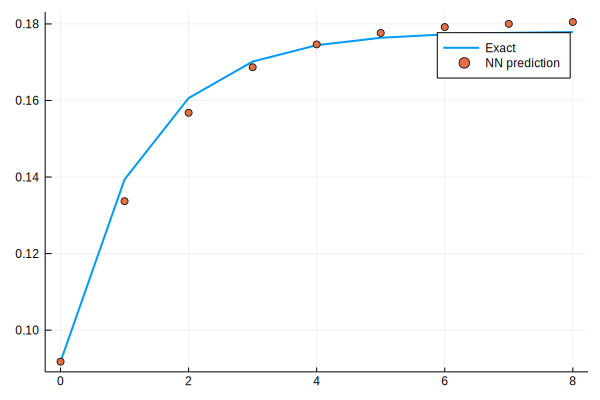

loss: 0.000174:  60%|████████████████████████▊                |  ETA: 0:00:15

0.00016949975f0

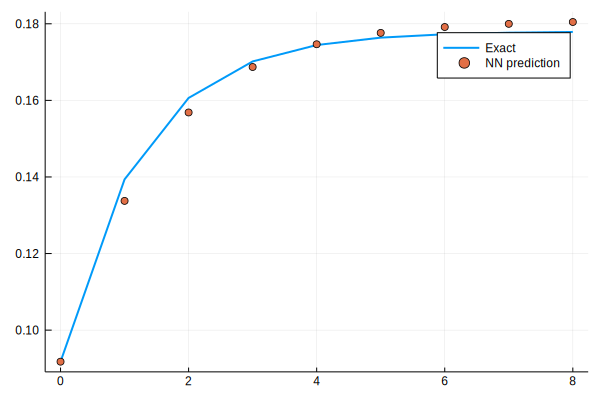

0.00016552678f0

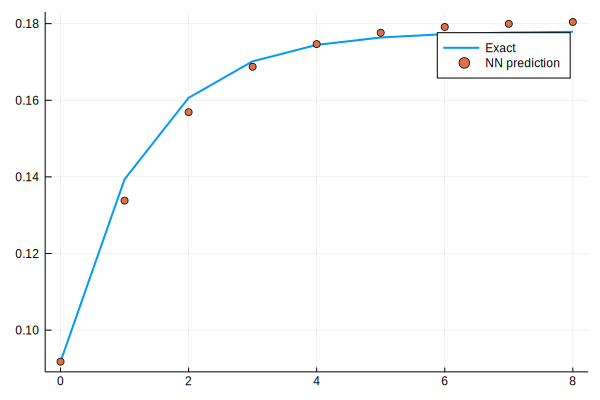

loss: 0.000166:  61%|█████████████████████████                |  ETA: 0:00:14

0.00016165257f0

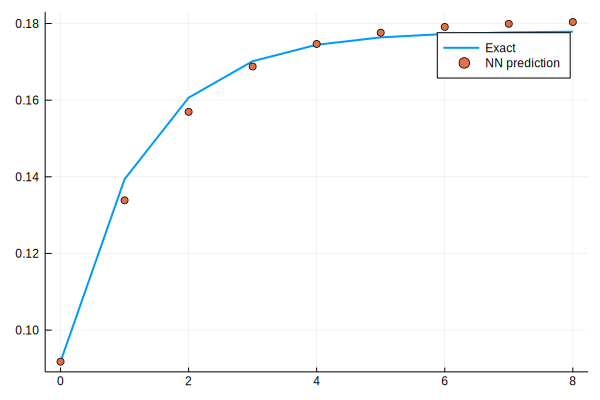

0.00015787235f0

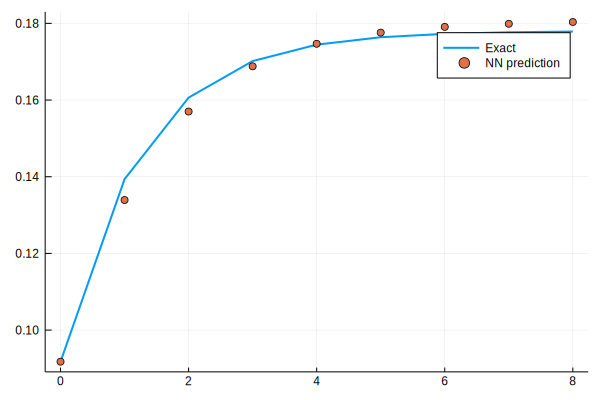

loss: 0.000158:  62%|█████████████████████████▎               |  ETA: 0:00:14

0.00015418549f0

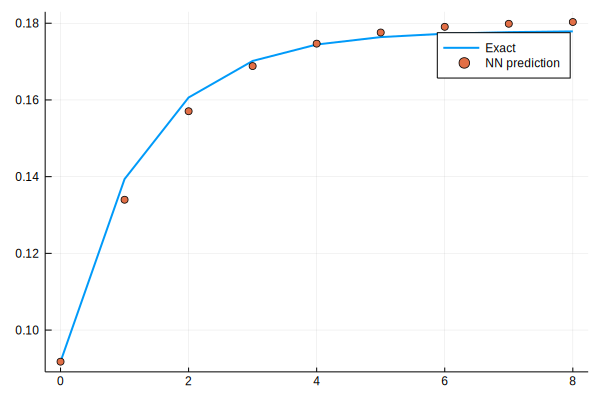

0.00015058953f0

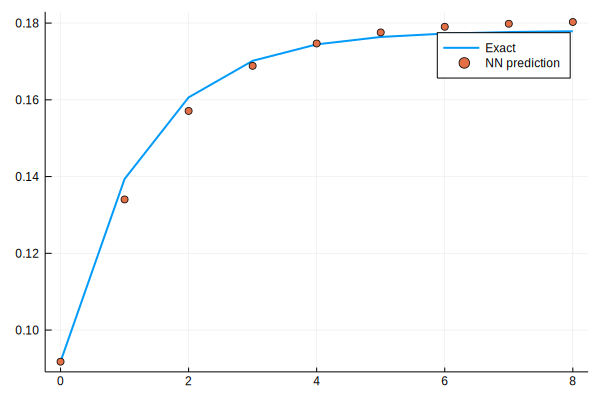

loss: 0.000151:  62%|█████████████████████████▌               |  ETA: 0:00:14

0.00014708181f0

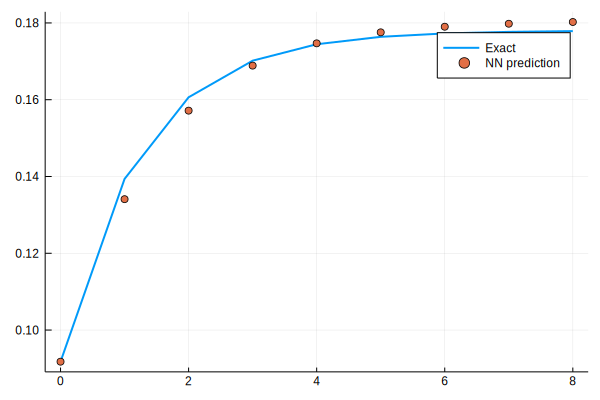

0.00014365984f0

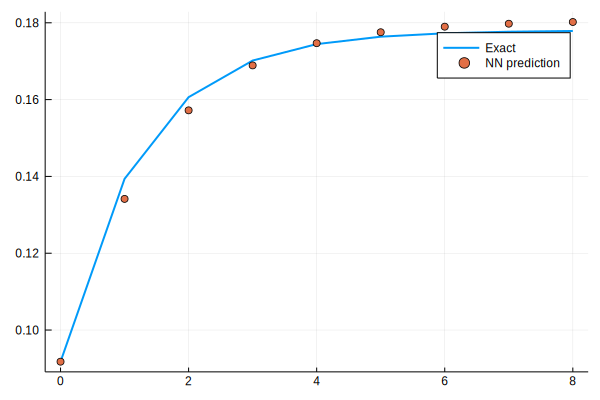

loss: 0.000144:  63%|█████████████████████████▉               |  ETA: 0:00:13

0.00014032148f0

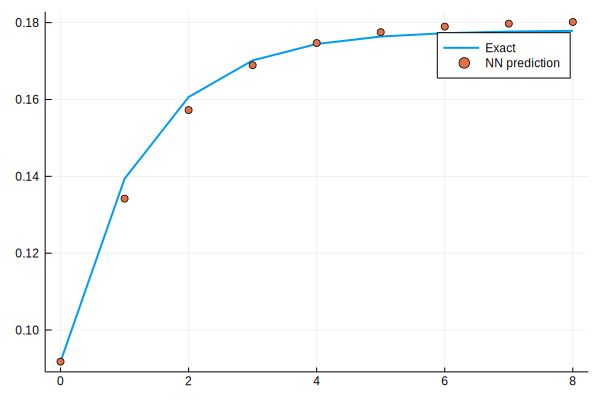

0.00013706517f0

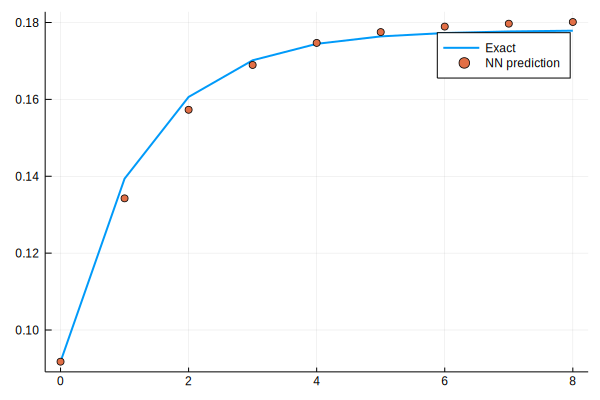

loss: 0.000137:  64%|██████████████████████████▏              |  ETA: 0:00:13

0.00013388842f0

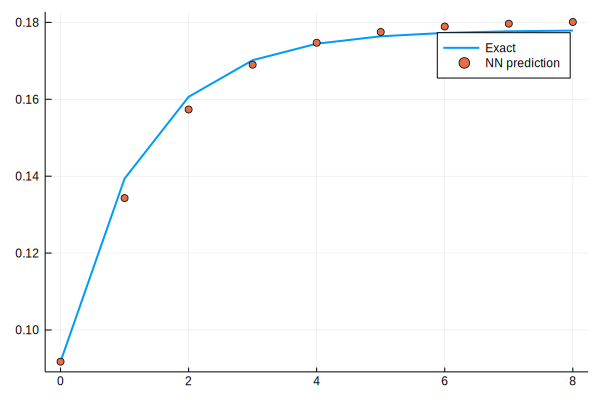

0.00013078957f0

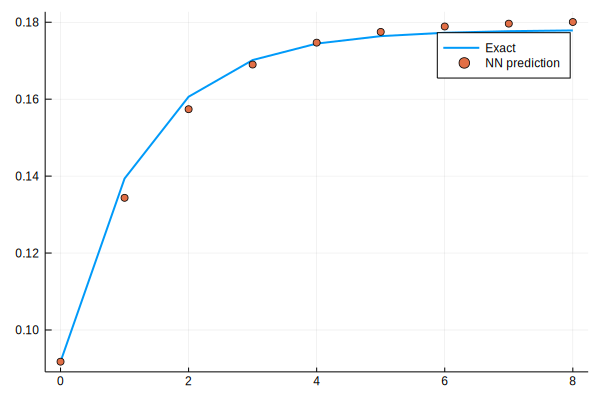

loss: 0.000131:  64%|██████████████████████████▍              |  ETA: 0:00:13

0.00012776566f0

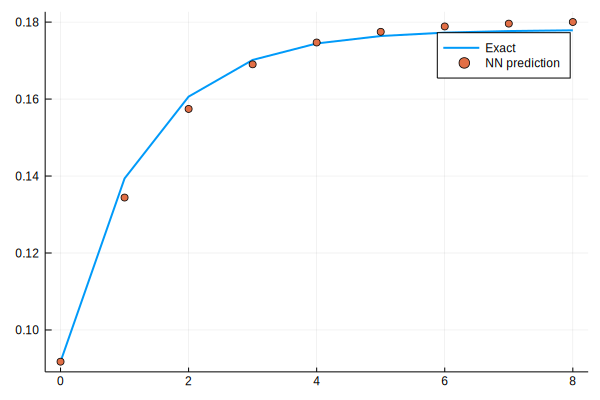

0.00012481683f0

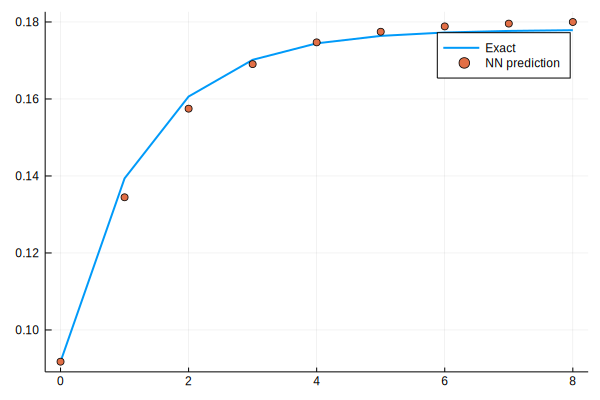

loss: 0.000125:  65%|██████████████████████████▋              |  ETA: 0:00:13

0.000121939214f0

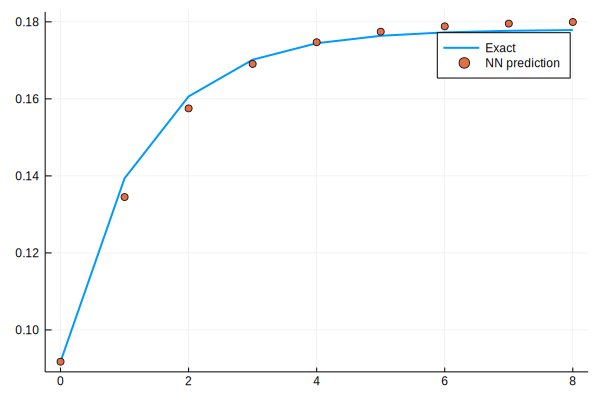

0.00011913143f0

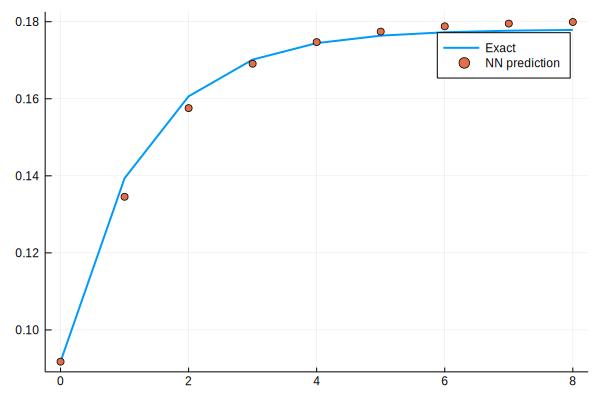

loss: 0.000119:  66%|██████████████████████████▉              |  ETA: 0:00:12

0.00011639281f0

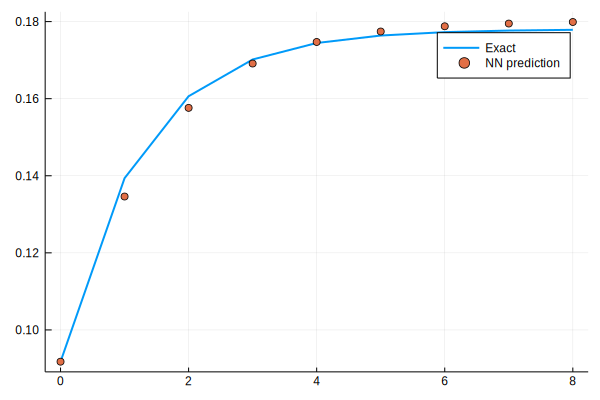

0.00011371957f0

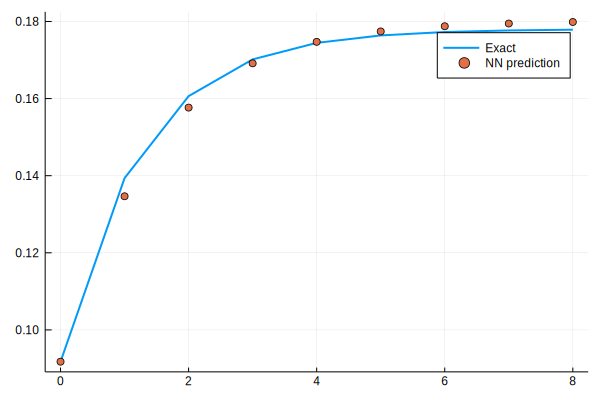

loss: 0.000114:  66%|███████████████████████████▏             |  ETA: 0:00:12

0.00011111221f0

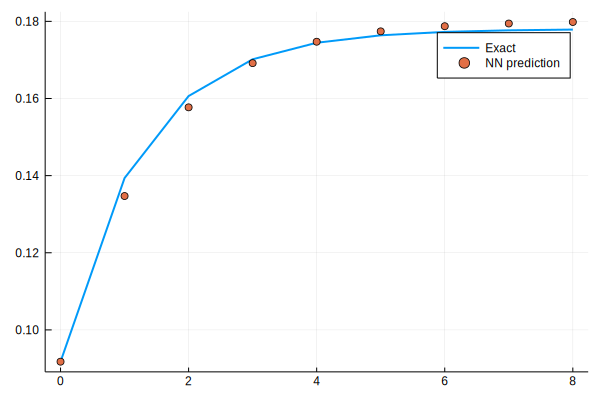

0.00010856876f0

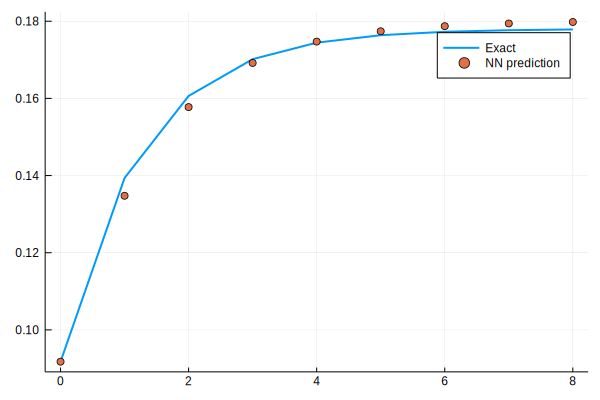

loss: 0.000109:  67%|███████████████████████████▌             |  ETA: 0:00:12

0.00010608705f0

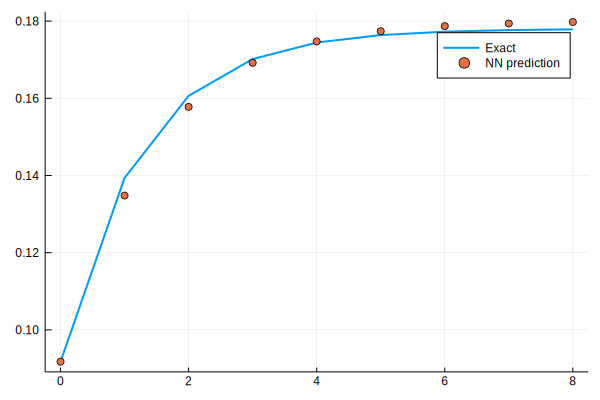

0.00010366488f0

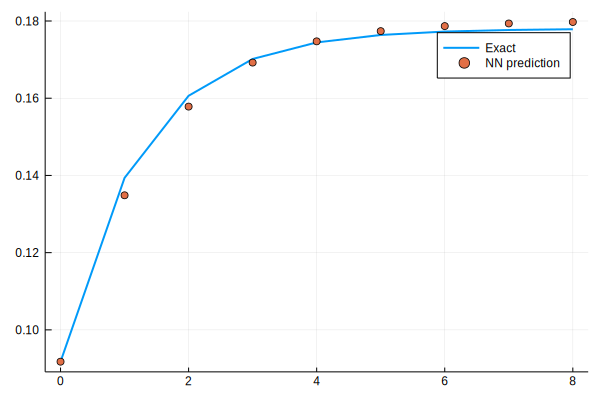

loss: 0.000104:  68%|███████████████████████████▊             |  ETA: 0:00:11

0.00010130274f0

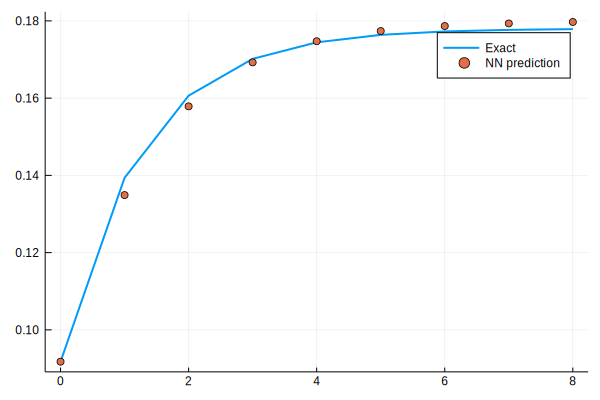

9.899757f-5

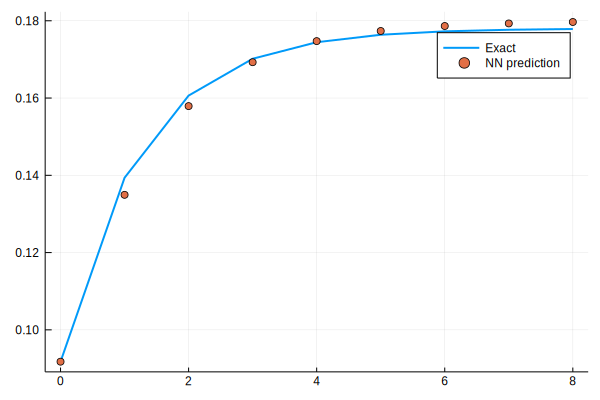

loss: 9.9e-05:  68%|████████████████████████████             |  ETA: 0:00:11

9.674761f-5

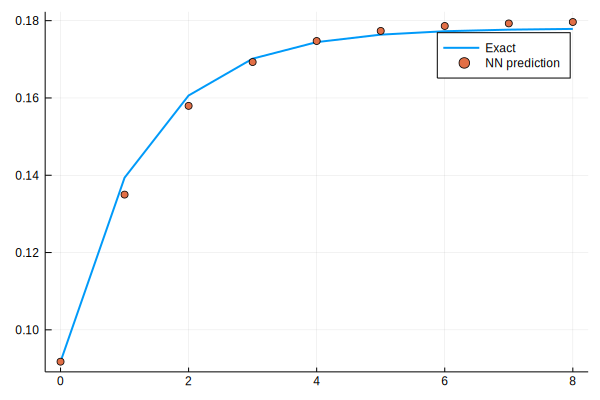

9.455276f-5

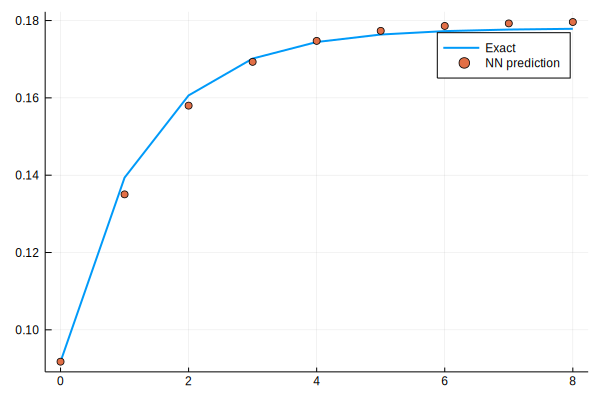

loss: 9.46e-05:  69%|████████████████████████████▎            |  ETA: 0:00:11

9.2411356f-5

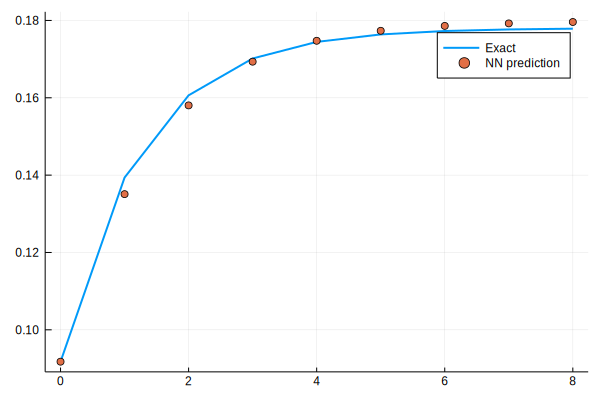

9.0321664f-5

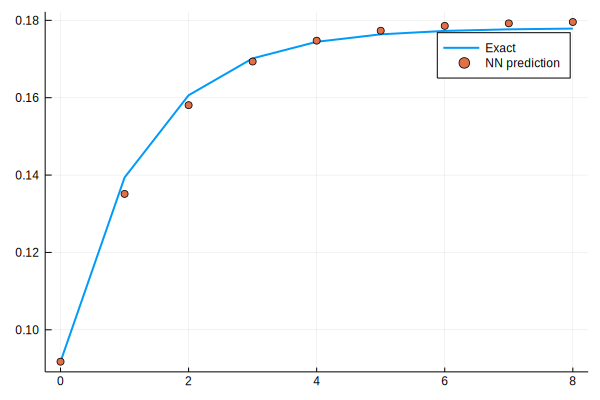

loss: 9.03e-05:  70%|████████████████████████████▌            |  ETA: 0:00:11

8.828259f-5

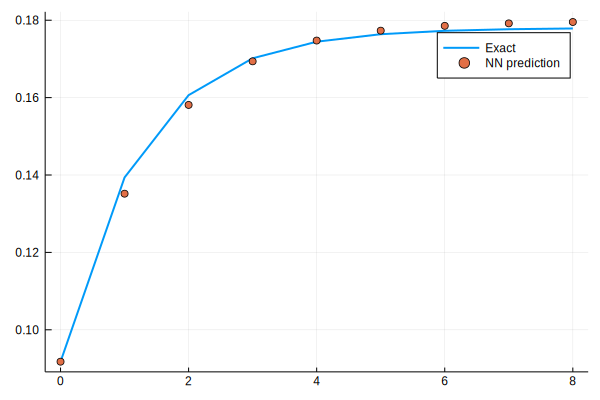

8.629319f-5

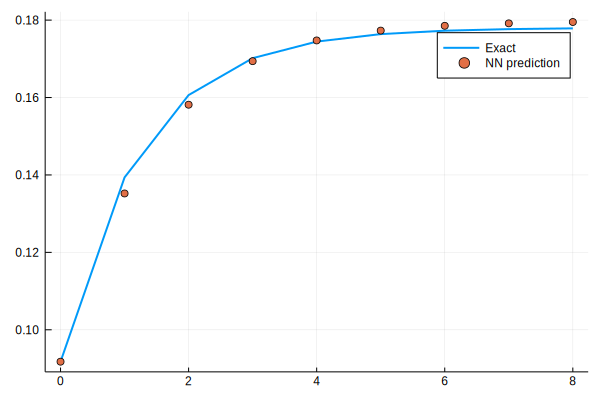

loss: 8.63e-05:  70%|████████████████████████████▉            |  ETA: 0:00:10

8.4352076f-5

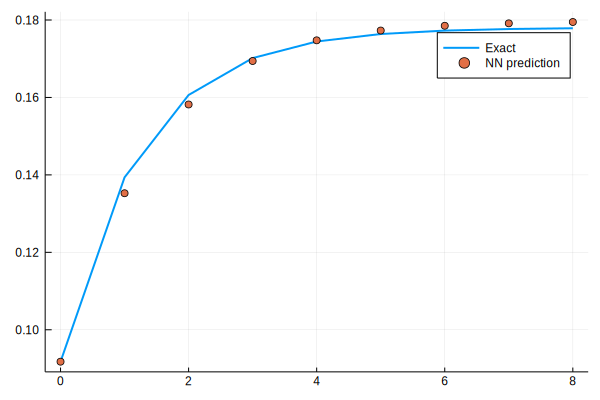

8.24583f-5

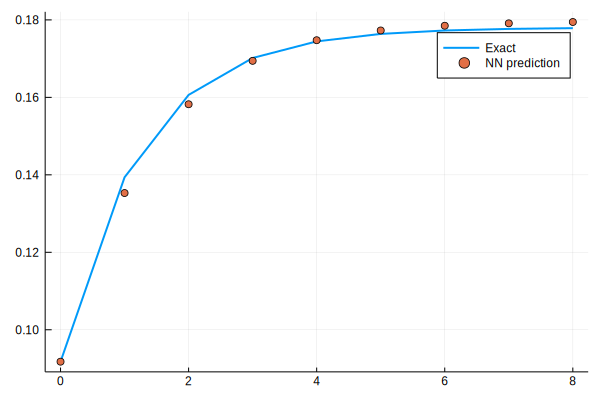

loss: 8.25e-05:  71%|█████████████████████████████▏           |  ETA: 0:00:10

8.061028f-5

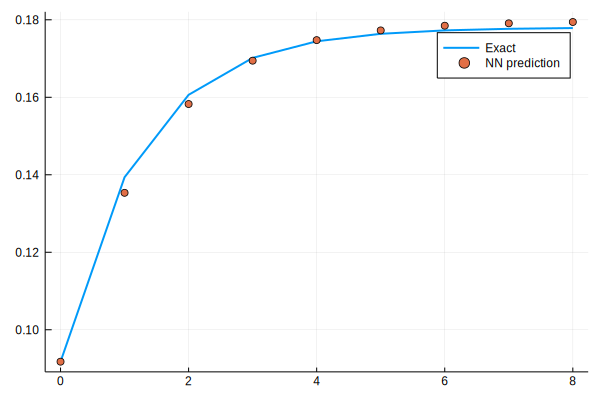

7.8806996f-5

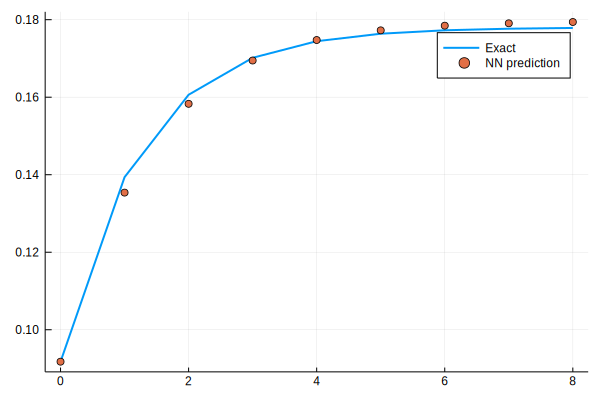

loss: 7.88e-05:  72%|█████████████████████████████▍           |  ETA: 0:00:10

7.704662f-5

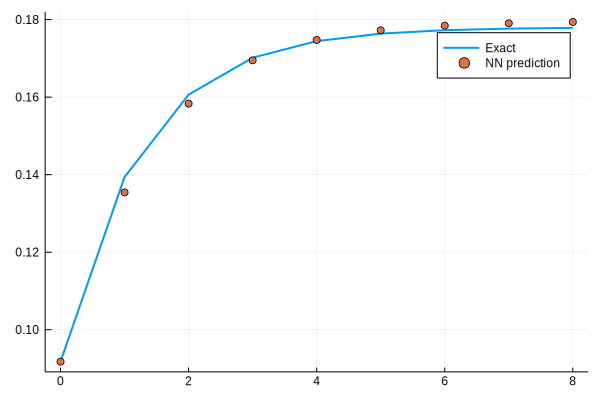

7.532954f-5

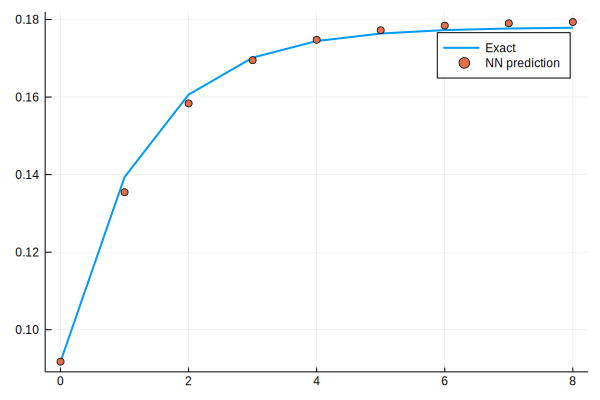

loss: 7.53e-05:  72%|█████████████████████████████▋           |  ETA: 0:00:10

7.365493f-5

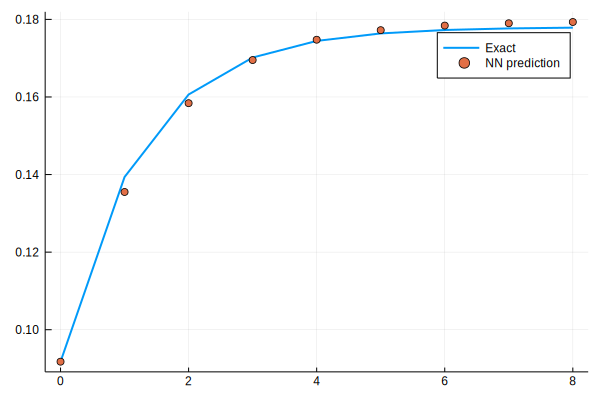

7.201939f-5

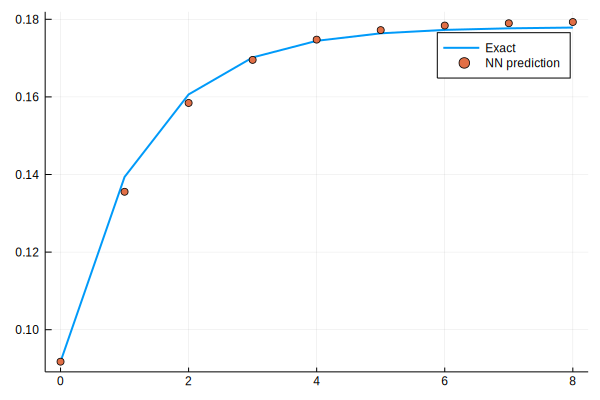

loss: 7.2e-05:  73%|█████████████████████████████▉           |  ETA: 0:00:09

7.0424394f-5

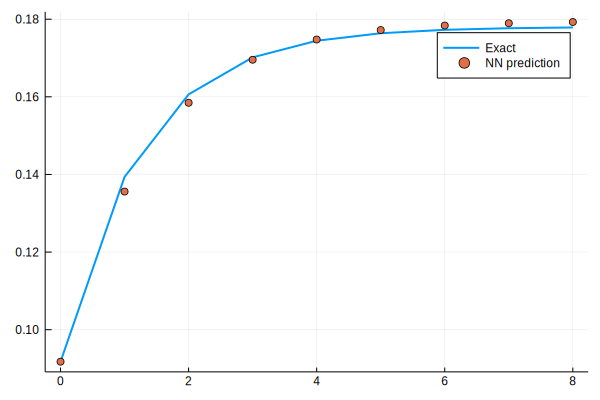

6.8867455f-5

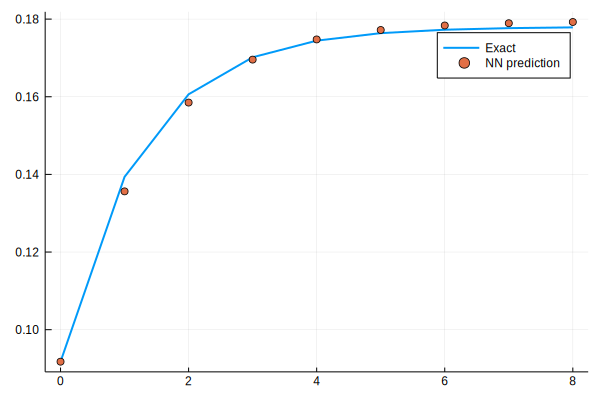

loss: 6.89e-05:  74%|██████████████████████████████▏          |  ETA: 0:00:09

6.7349814f-5

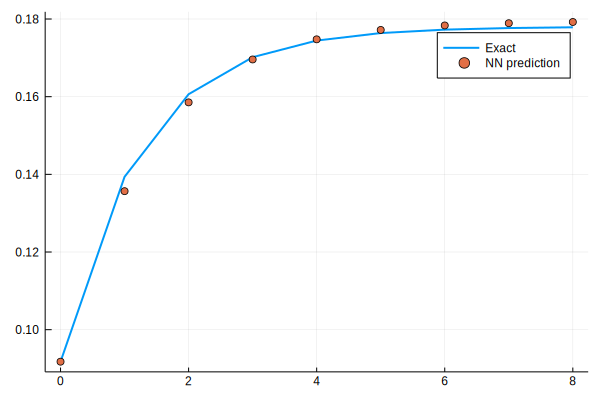

6.586676f-5

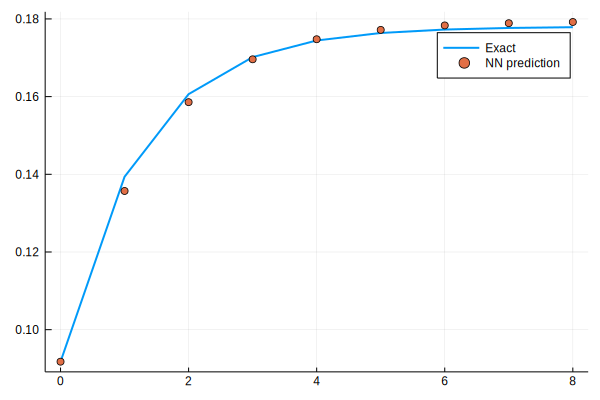

loss: 6.59e-05:  74%|██████████████████████████████▌          |  ETA: 0:00:09

6.442058f-5

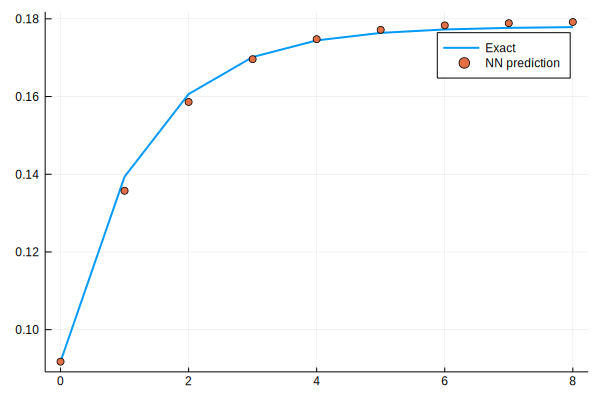

6.300939f-5

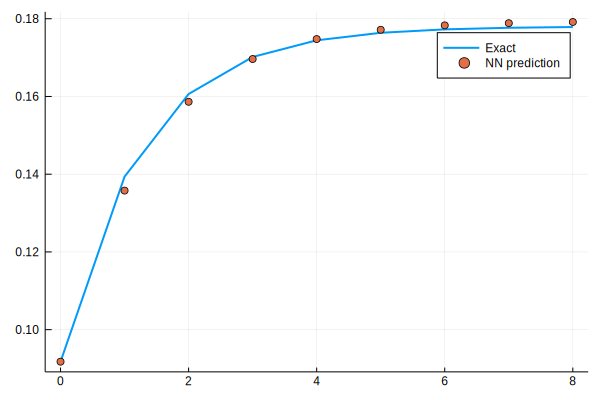

loss: 6.3e-05:  75%|██████████████████████████████▊          |  ETA: 0:00:08

6.163243f-5

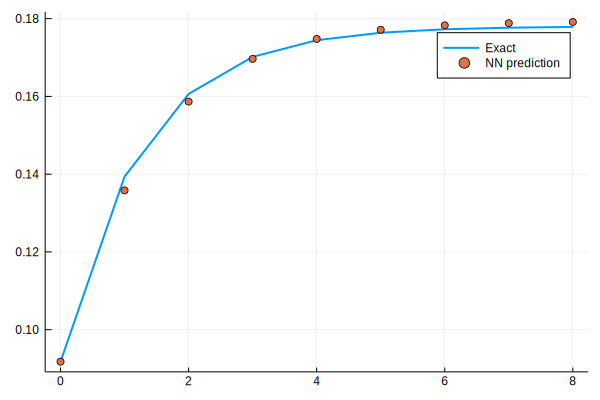

6.0289916f-5

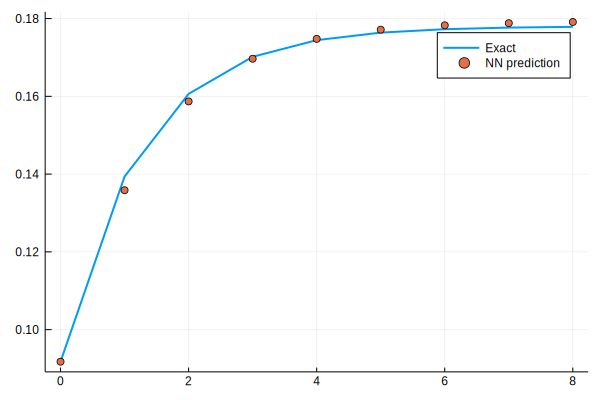

loss: 6.03e-05:  76%|███████████████████████████████          |  ETA: 0:00:08

5.8978865f-5

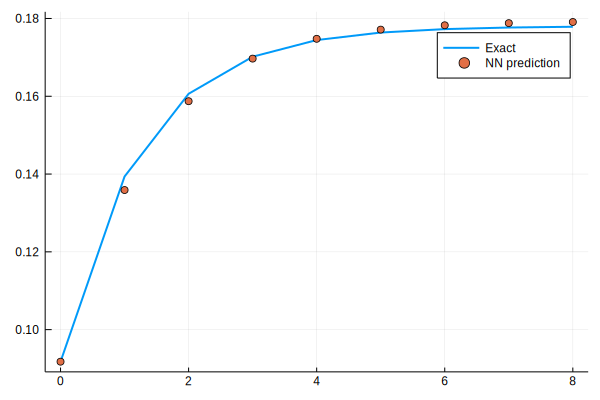

5.769968f-5

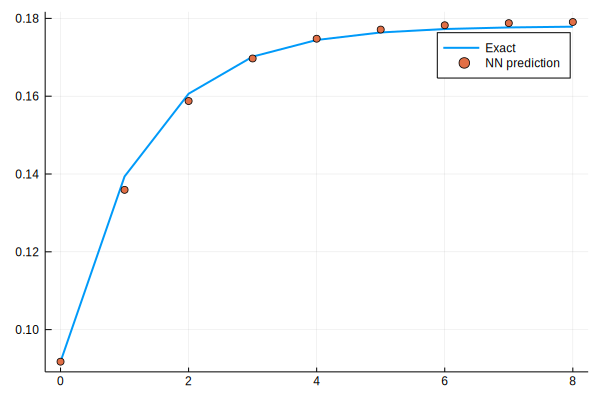

loss: 5.77e-05:  76%|███████████████████████████████▎         |  ETA: 0:00:08

5.6451594f-5

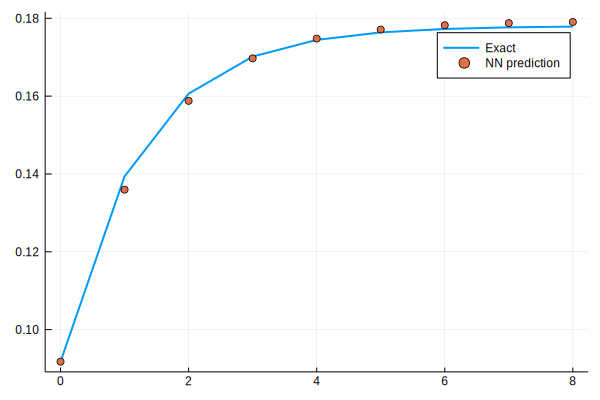

5.5233155f-5

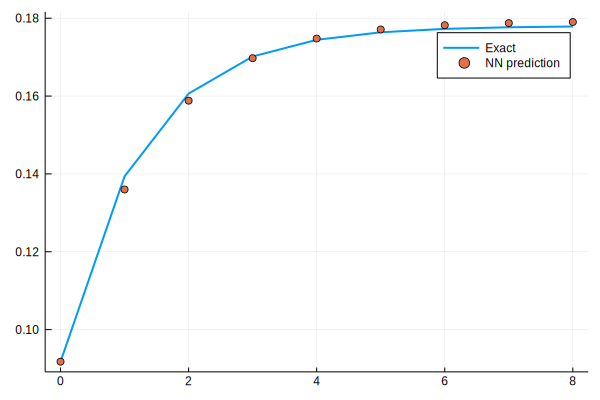

loss: 5.52e-05:  77%|███████████████████████████████▋         |  ETA: 0:00:08

5.4044896f-5

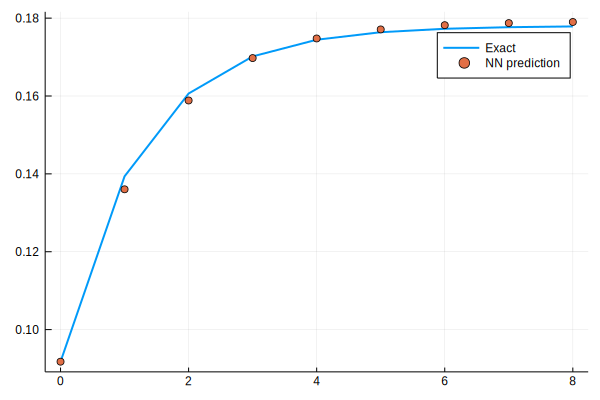

5.288741f-5

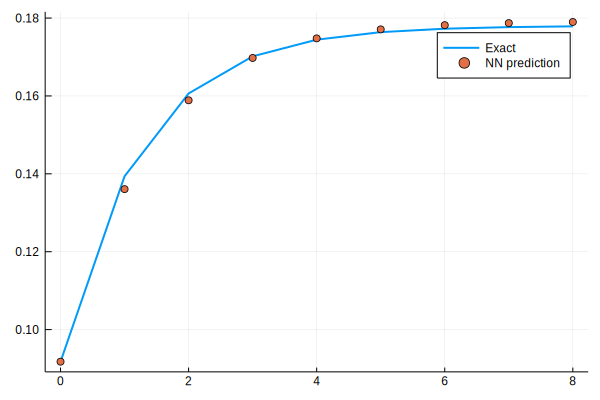

loss: 5.29e-05:  78%|███████████████████████████████▉         |  ETA: 0:00:08

5.1756117f-5

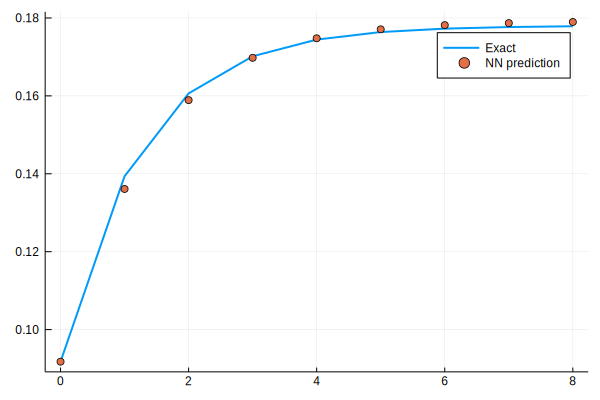

5.0650982f-5

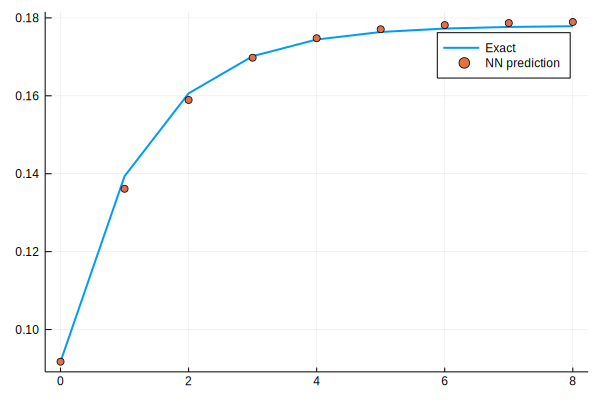

loss: 5.07e-05:  78%|████████████████████████████████▏        |  ETA: 0:00:07

4.957672f-5

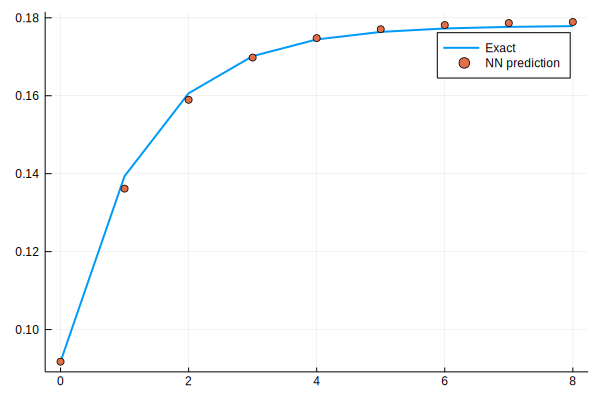

4.852411f-5

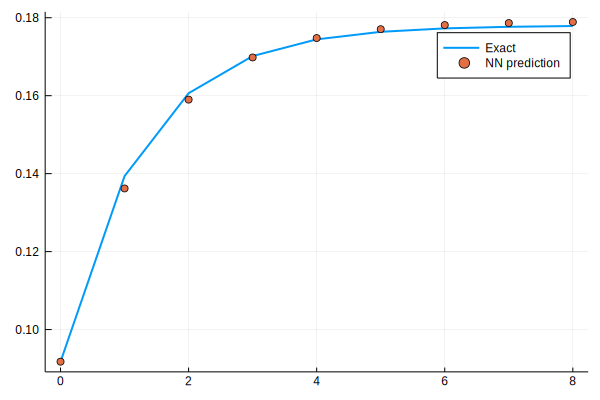

loss: 4.85e-05:  79%|████████████████████████████████▍        |  ETA: 0:00:07

4.7499034f-5

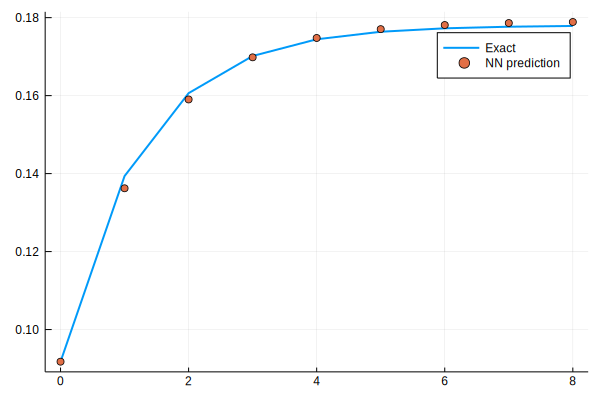

4.649732f-5

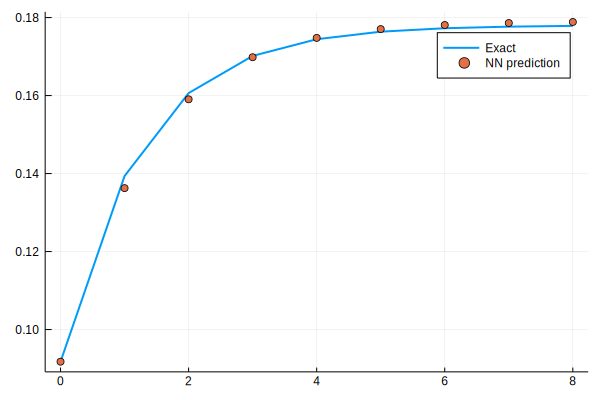

loss: 4.65e-05:  80%|████████████████████████████████▋        |  ETA: 0:00:07

4.5521796f-5

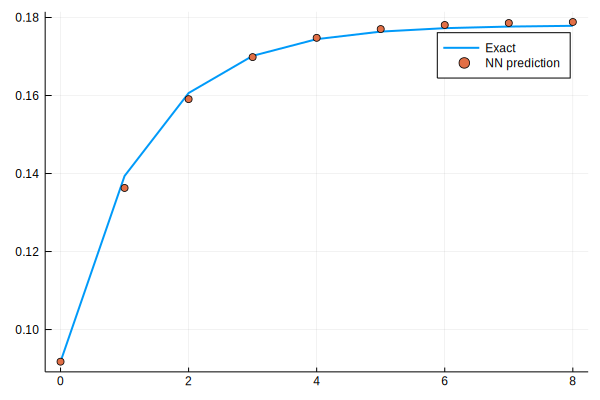

4.45698f-5

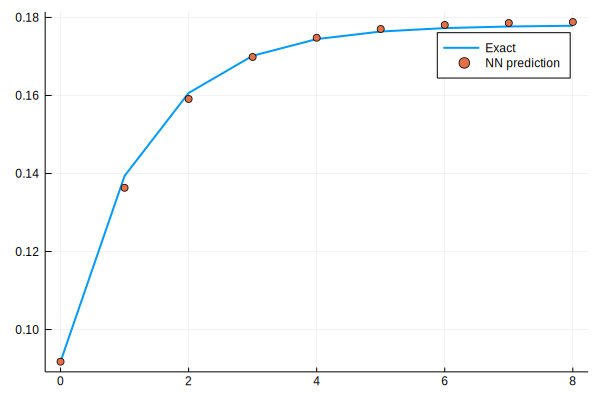

loss: 4.46e-05:  80%|████████████████████████████████▉        |  ETA: 0:00:07

4.364323f-5

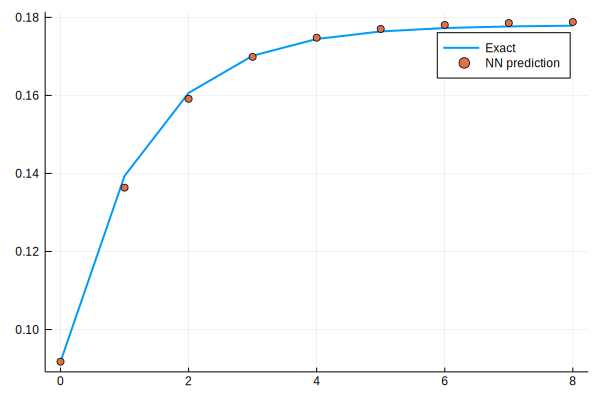

4.2734697f-5

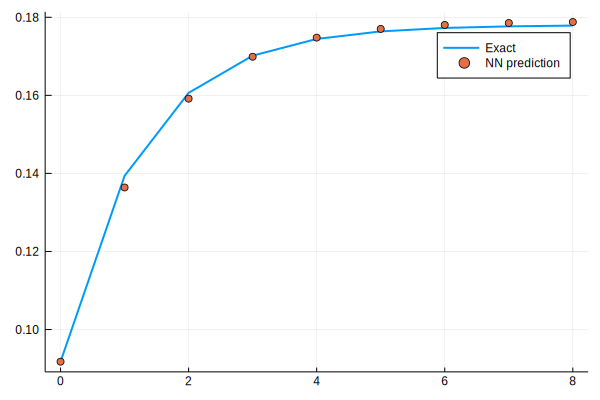

loss: 4.27e-05:  81%|█████████████████████████████████▎       |  ETA: 0:00:06

4.1848674f-5

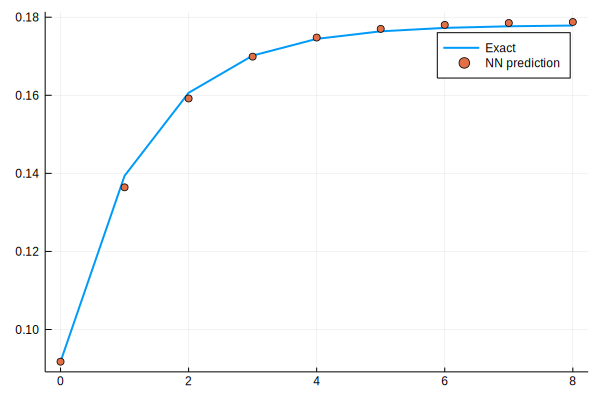

4.098976f-5

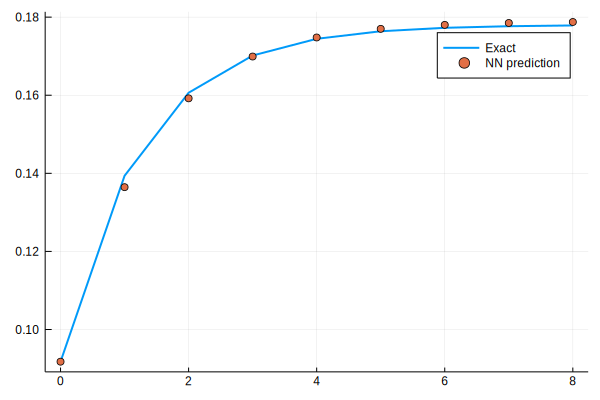

loss: 4.1e-05:  82%|█████████████████████████████████▌       |  ETA: 0:00:06

4.014755f-5

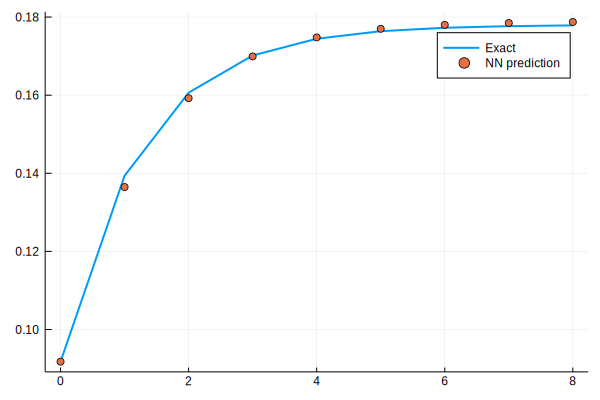

3.932429f-5

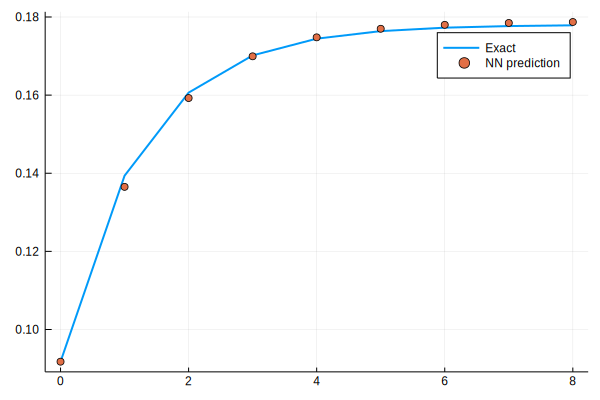

loss: 3.93e-05:  82%|█████████████████████████████████▊       |  ETA: 0:00:06

3.85246f-5

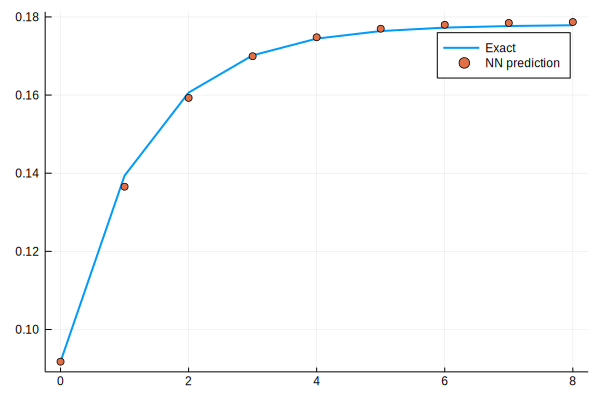

3.7741705f-5

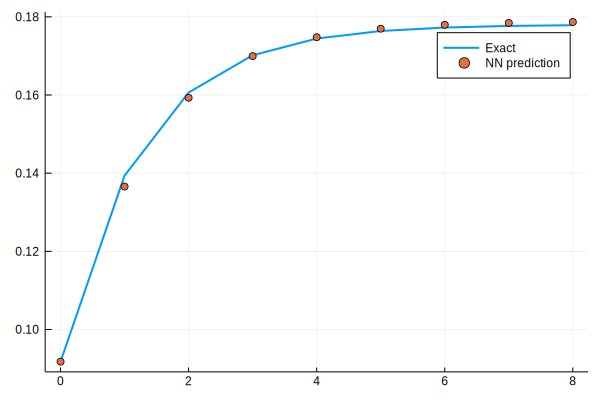

loss: 3.77e-05:  83%|██████████████████████████████████       |  ETA: 0:00:06

3.6982605f-5

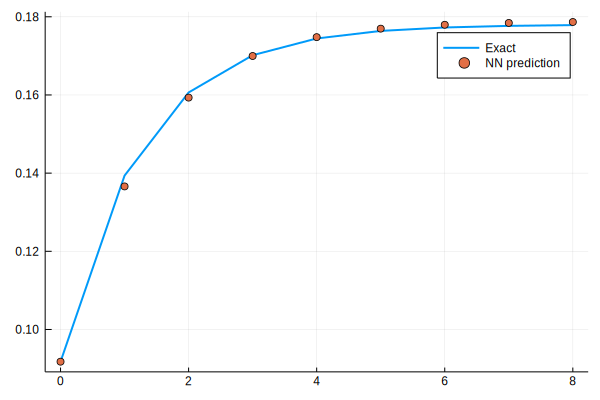

3.6236284f-5

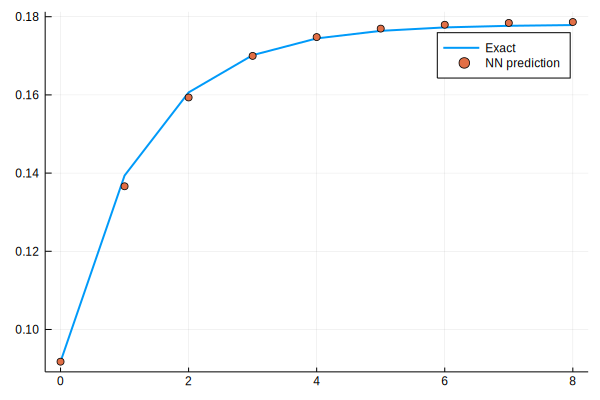

loss: 3.62e-05:  84%|██████████████████████████████████▎      |  ETA: 0:00:05

3.5512294f-5

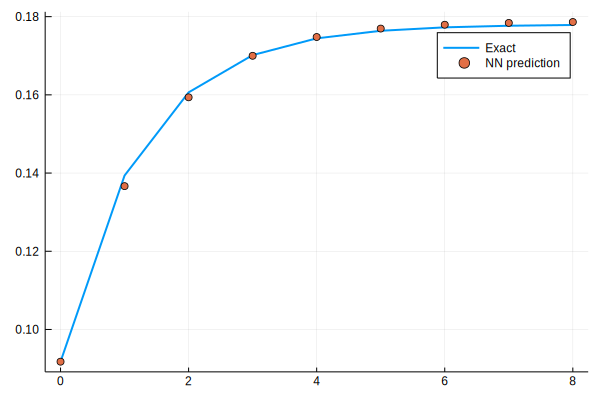

3.4800578f-5

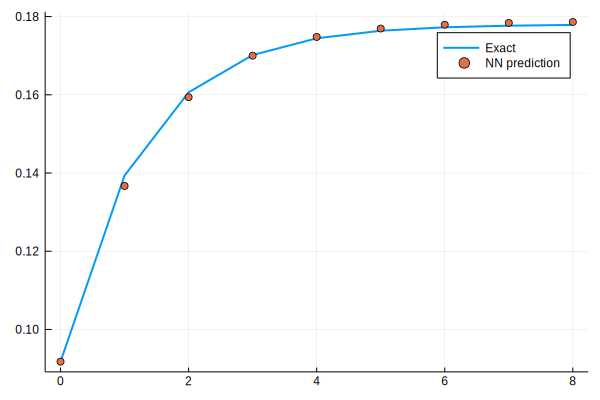

loss: 3.48e-05:  84%|██████████████████████████████████▋      |  ETA: 0:00:05

3.411314f-5

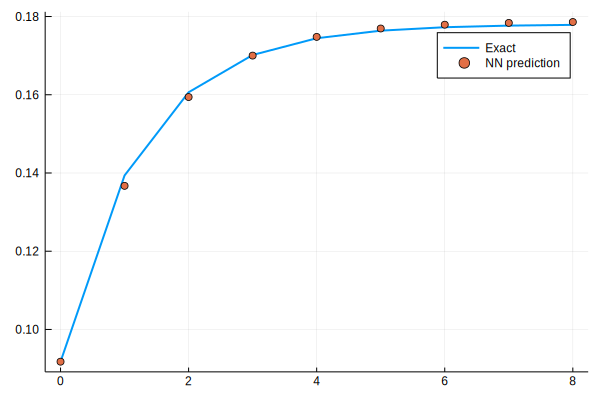

3.343889f-5

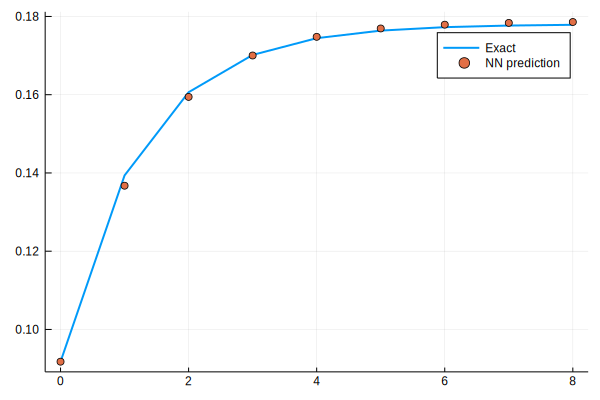

loss: 3.34e-05:  85%|██████████████████████████████████▉      |  ETA: 0:00:05

3.278016f-5

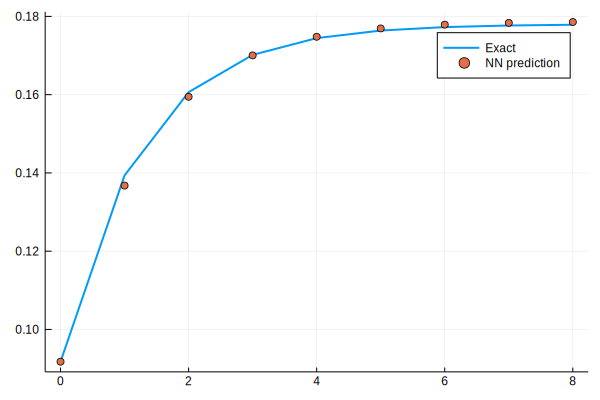

3.2141295f-5

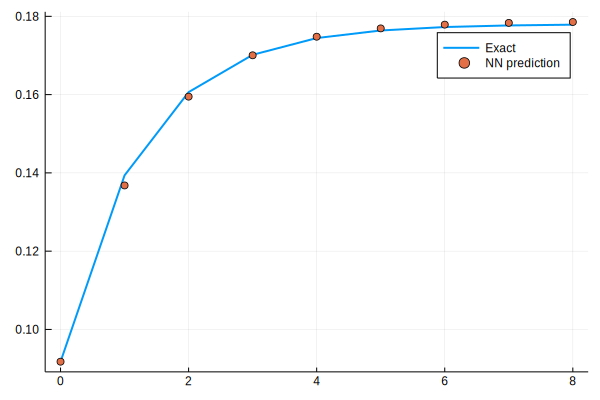

loss: 3.21e-05:  86%|███████████████████████████████████▏     |  ETA: 0:00:05

3.151748f-5

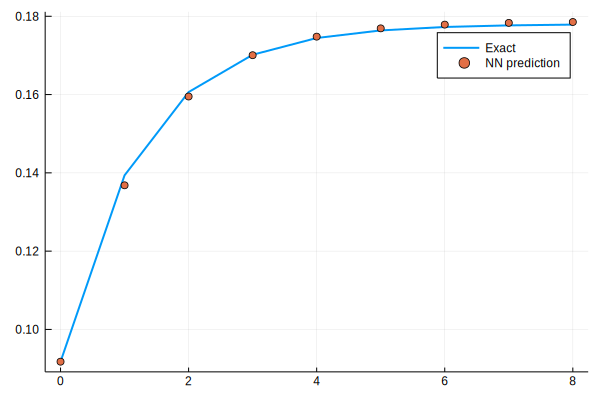

3.0903233f-5

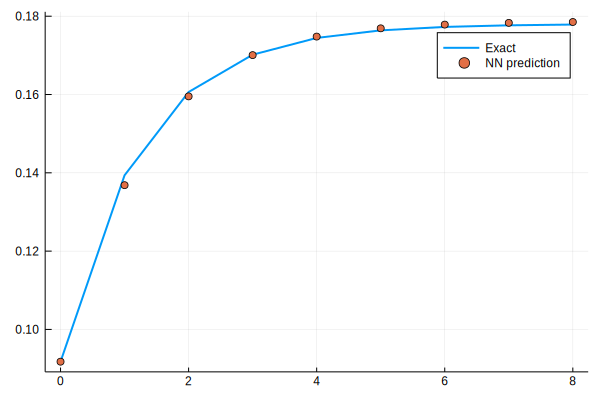

loss: 3.09e-05:  86%|███████████████████████████████████▍     |  ETA: 0:00:04

3.030955f-5

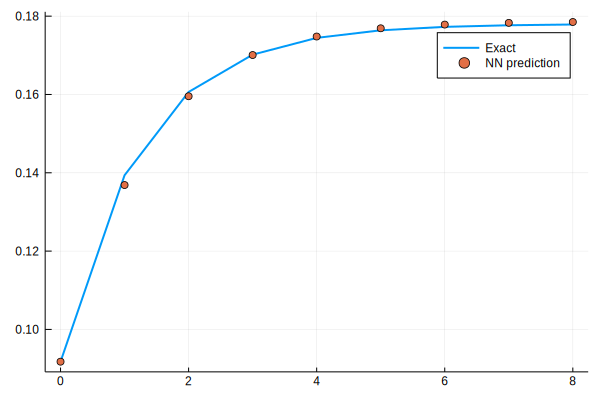

2.9729546f-5

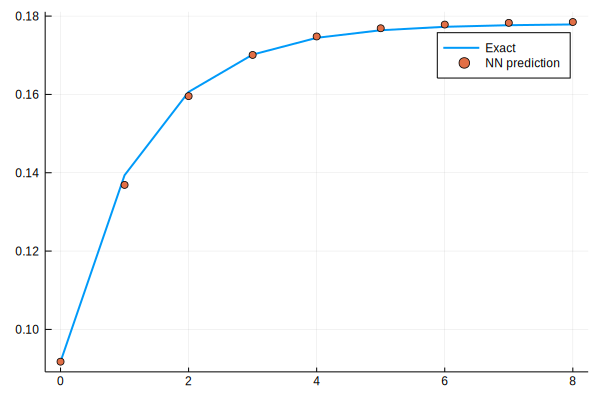

loss: 2.97e-05:  87%|███████████████████████████████████▋     |  ETA: 0:00:04

2.9166249f-5

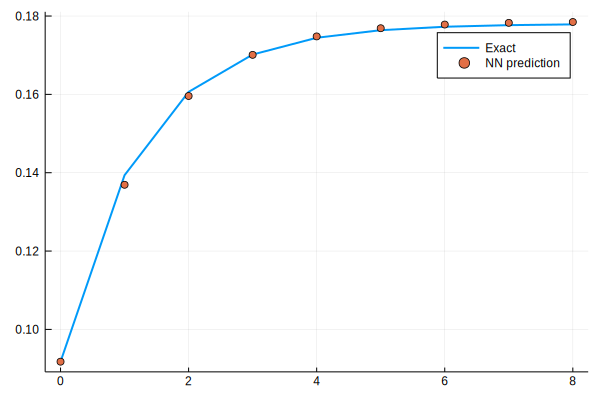

2.8612865f-5

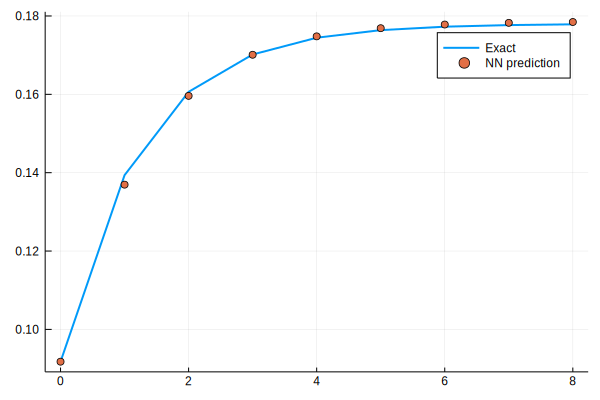

loss: 2.86e-05:  88%|███████████████████████████████████▉     |  ETA: 0:00:04

2.8073948f-5

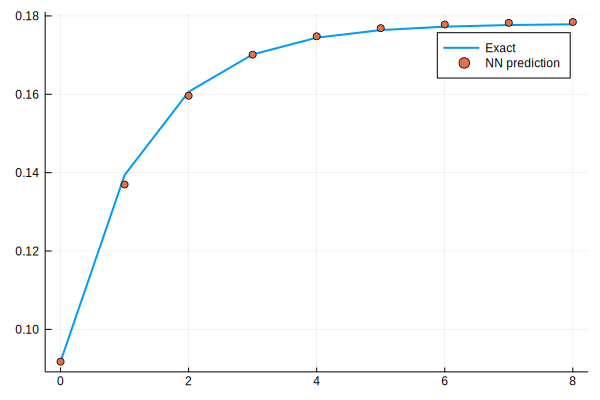

2.7547698f-5

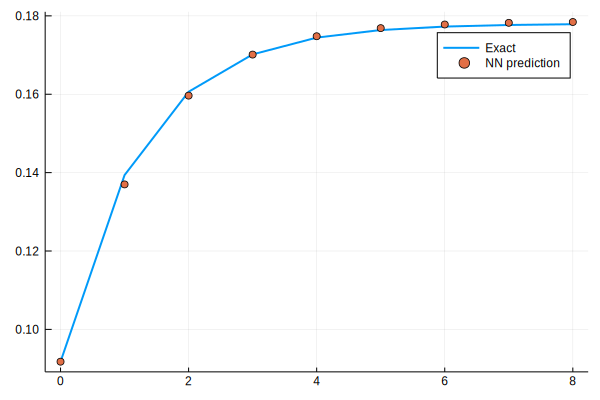

loss: 2.75e-05:  88%|████████████████████████████████████▎    |  ETA: 0:00:04

2.7035918f-5

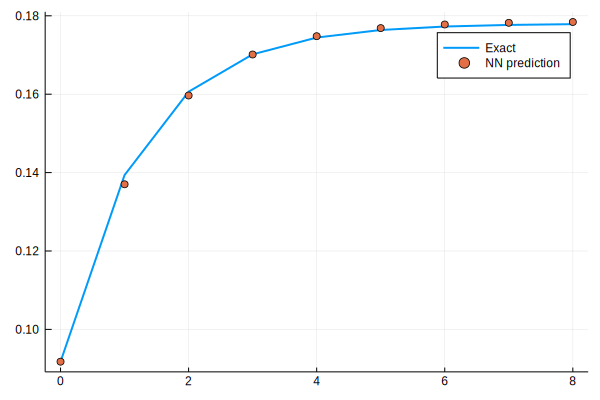

2.65358f-5

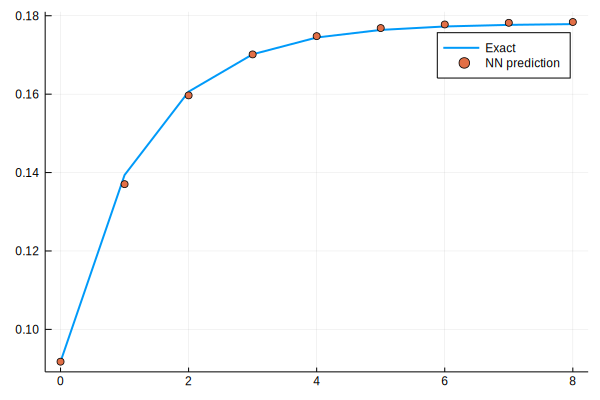

loss: 2.65e-05:  89%|████████████████████████████████████▌    |  ETA: 0:00:04

2.6048303f-5

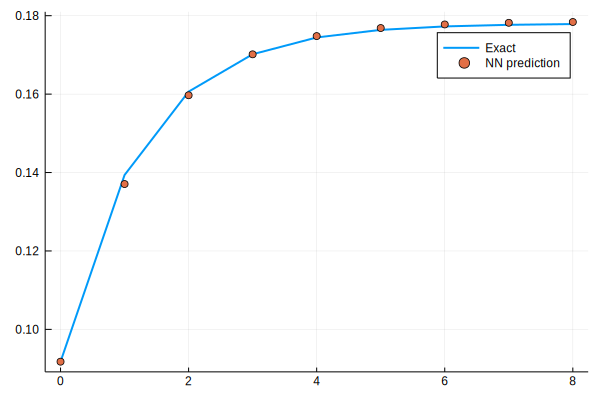

2.5577523f-5

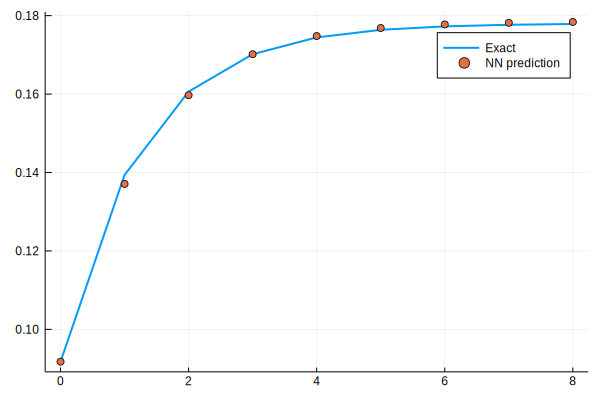

loss: 2.56e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:03

2.5109768f-5

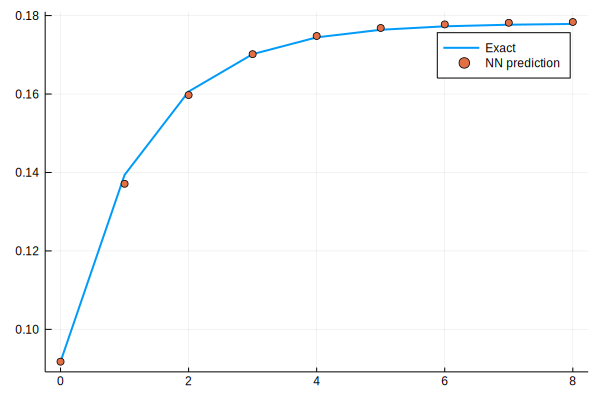

2.4657244f-5

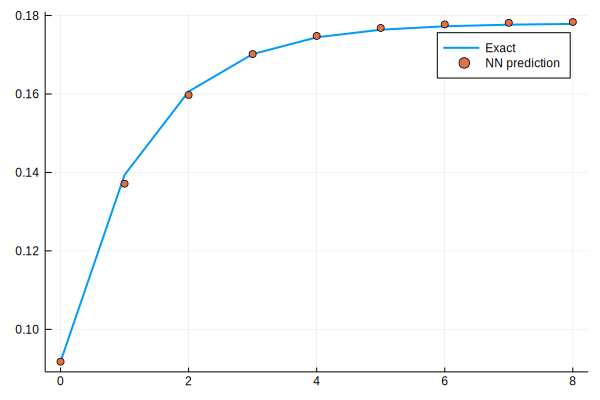

loss: 2.47e-05:  90%|█████████████████████████████████████    |  ETA: 0:00:03

2.421978f-5

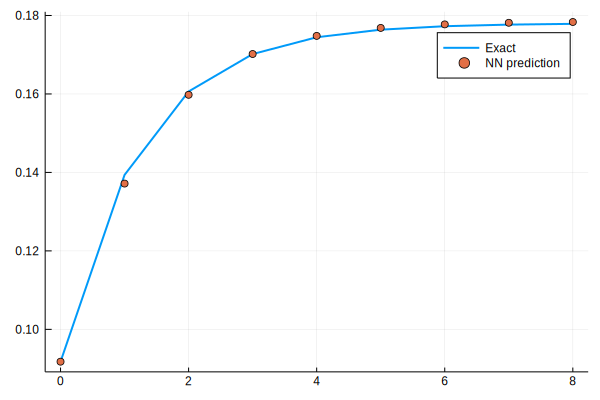

2.3787003f-5

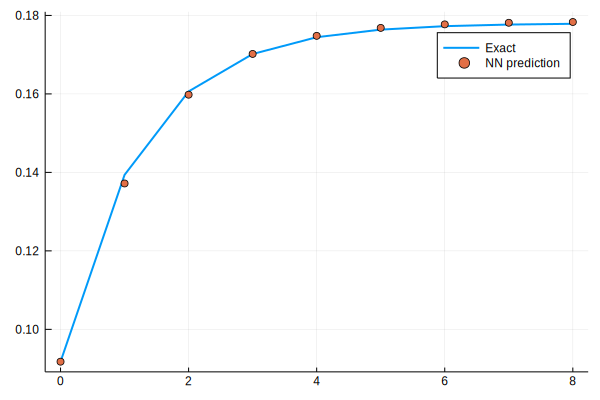

loss: 2.38e-05:  91%|█████████████████████████████████████▎   |  ETA: 0:00:03

2.3366616f-5

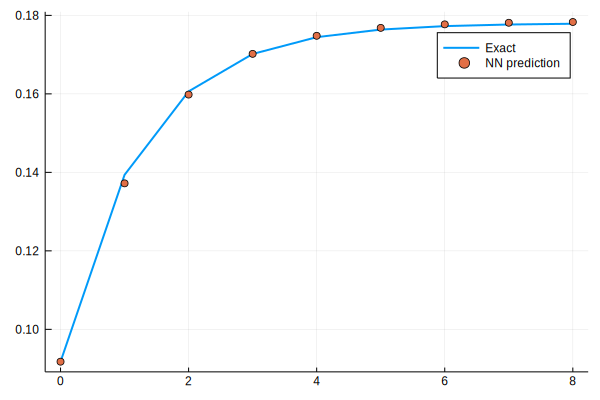

2.2959817f-5

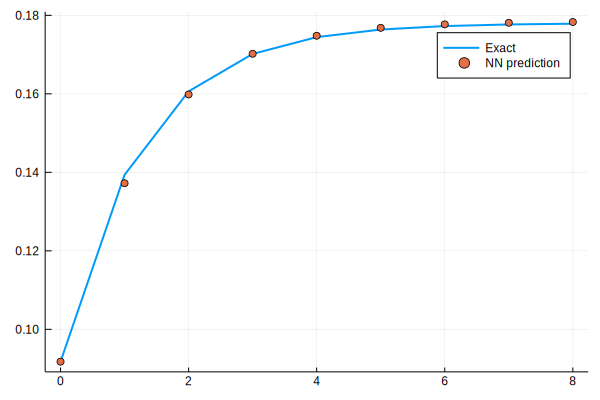

loss: 2.3e-05:  92%|█████████████████████████████████████▌   |  ETA: 0:00:03

2.256027f-5

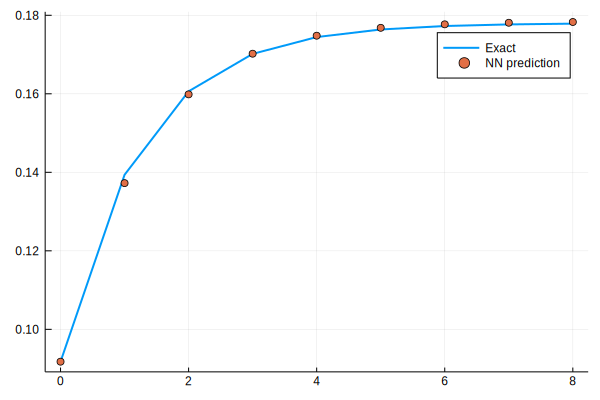

2.2172497f-5

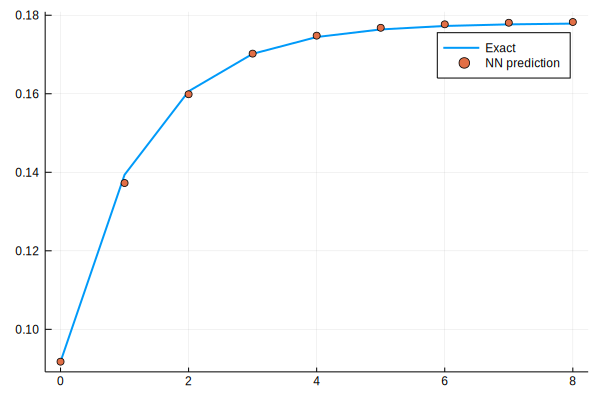

loss: 2.22e-05:  92%|█████████████████████████████████████▉   |  ETA: 0:00:02

2.1792543f-5

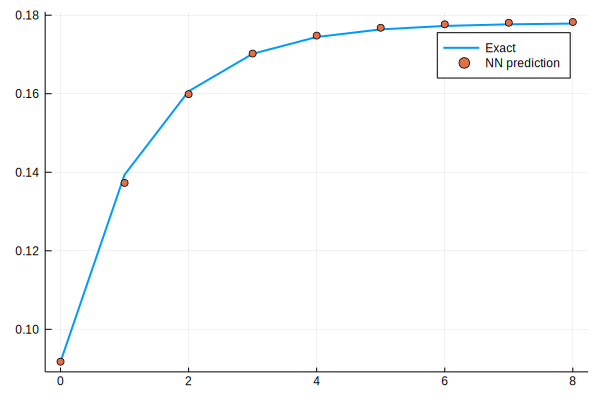

2.1426096f-5

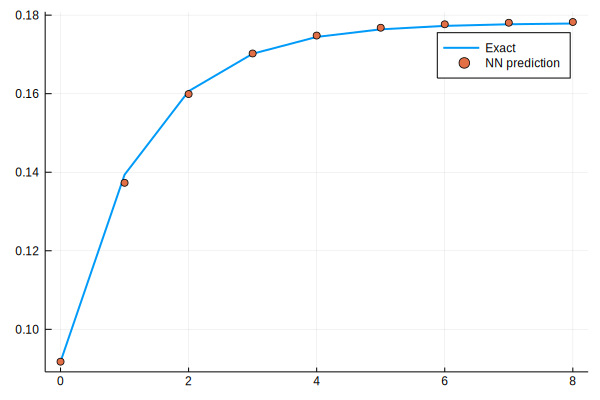

loss: 2.14e-05:  93%|██████████████████████████████████████▏  |  ETA: 0:00:02

2.1064961f-5

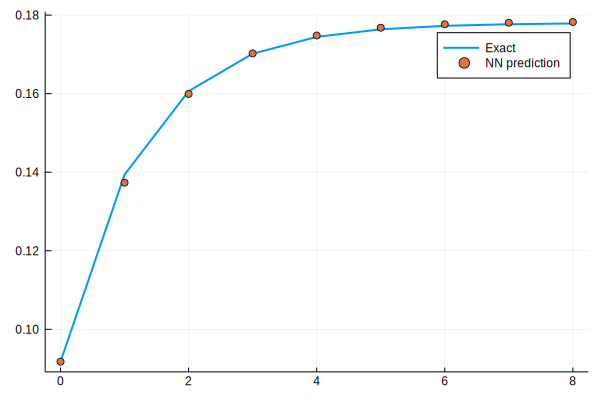

2.0712874f-5

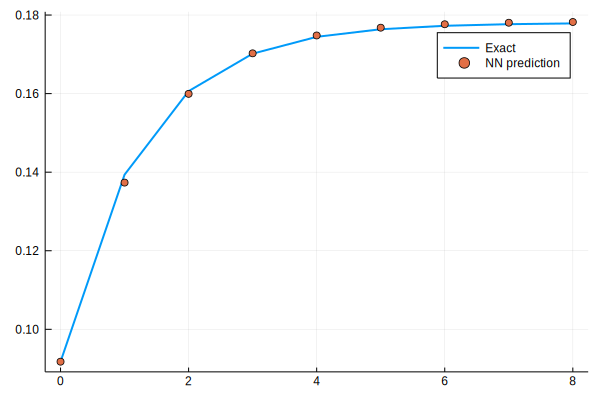

loss: 2.07e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:02

2.0369776f-5

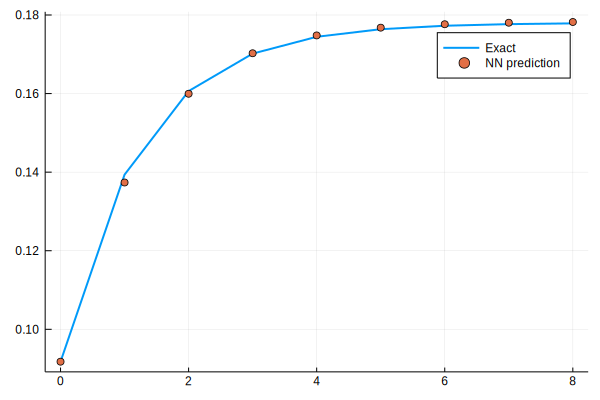

2.0034755f-5

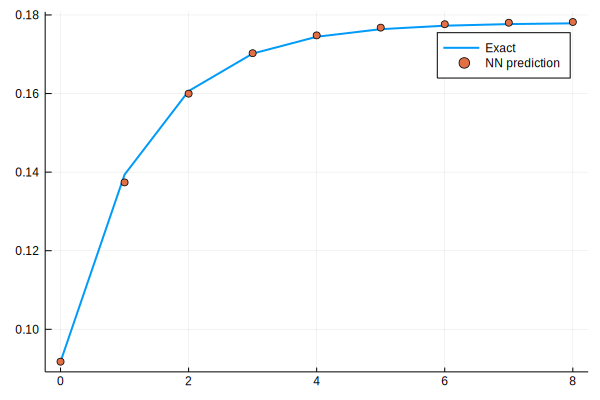

loss: 2e-05:  94%|██████████████████████████████████████▋  |  ETA: 0:00:02

1.97115f-5

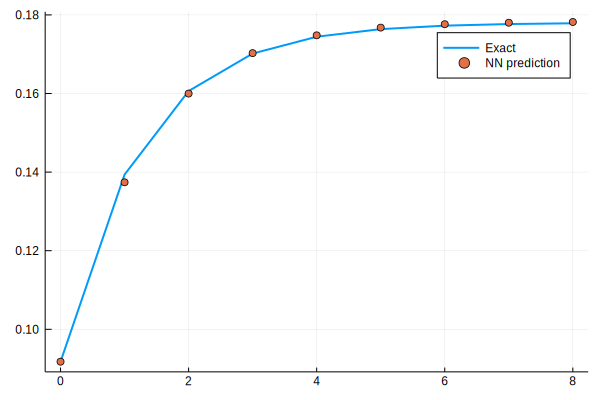

1.9391897f-5

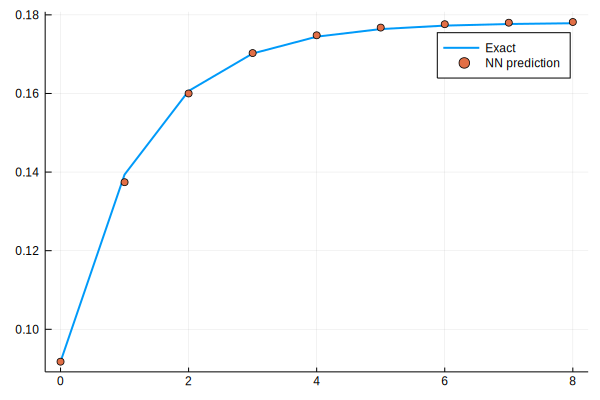

loss: 1.94e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:02

1.9083007f-5

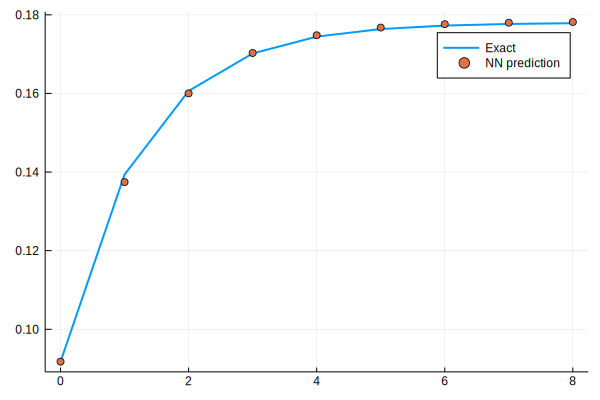

1.8783081f-5

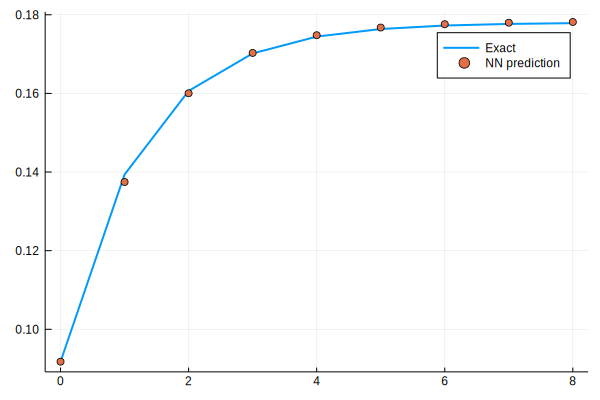

loss: 1.88e-05:  96%|███████████████████████████████████████▎ |  ETA: 0:00:01

1.8485025f-5

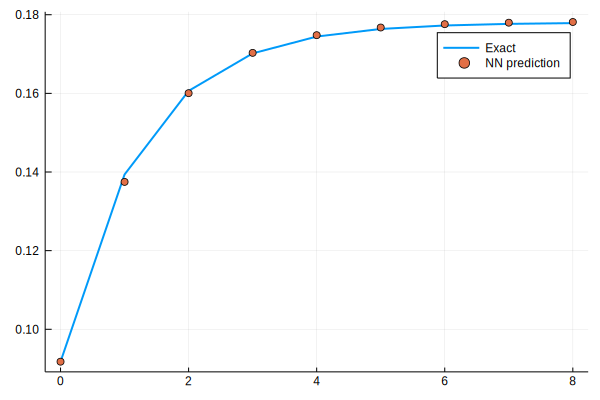

1.8201188f-5

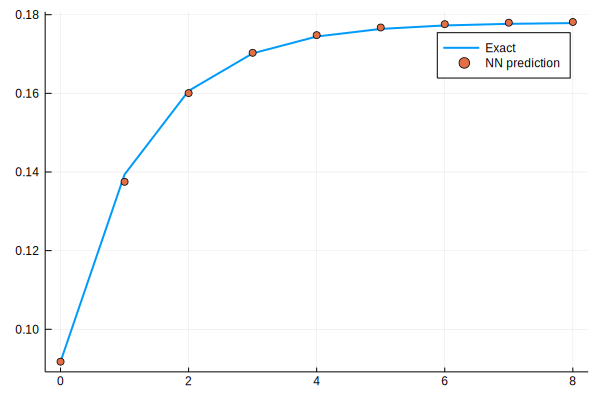

loss: 1.82e-05:  96%|███████████████████████████████████████▌ |  ETA: 0:00:01

1.792242f-5

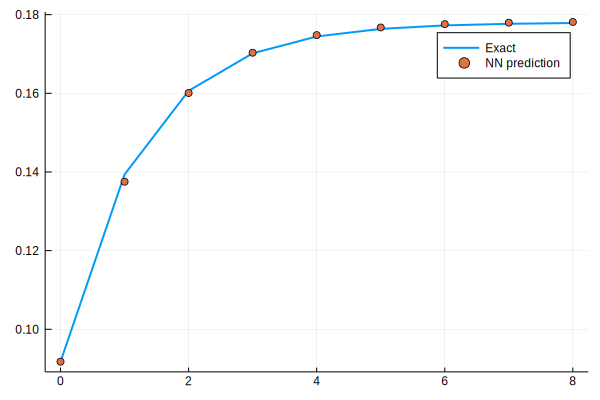

1.7648892f-5

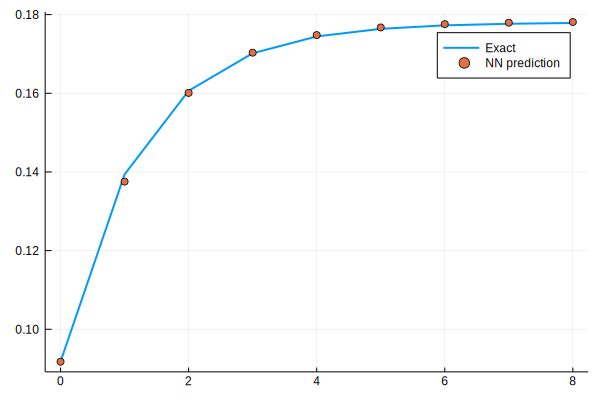

loss: 1.76e-05:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

1.738367f-5

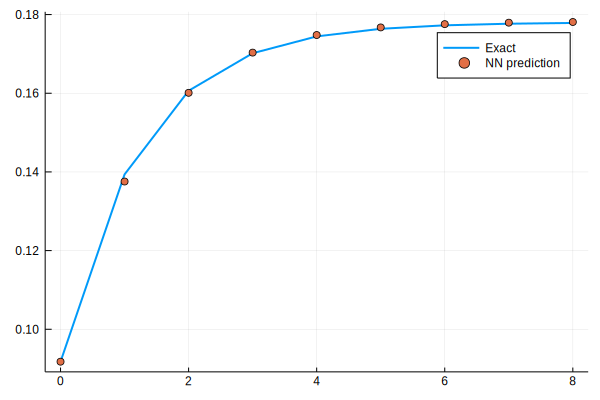

1.712101f-5

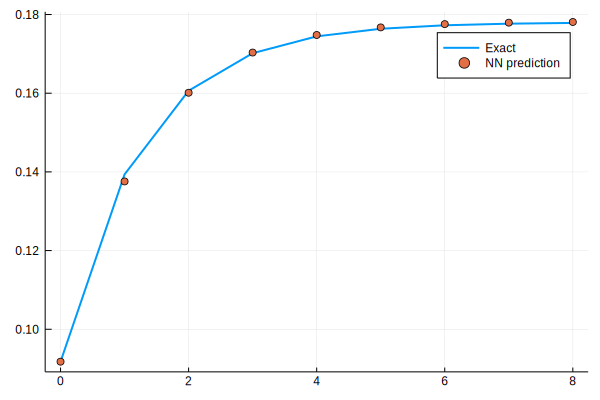

loss: 1.71e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:01

1.6870086f-5

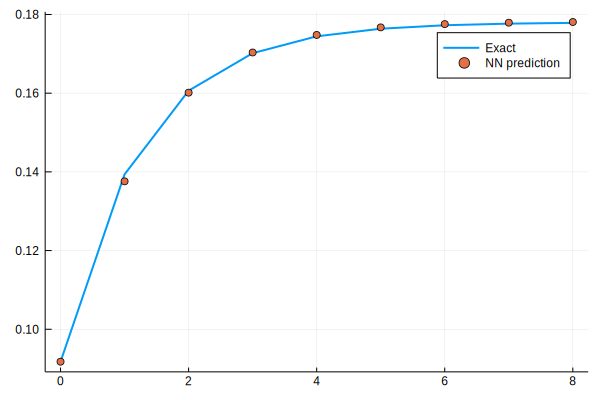

1.662693f-5

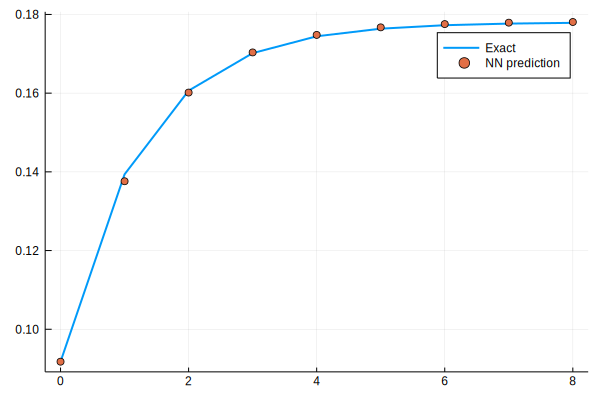

loss: 1.66e-05:  98%|████████████████████████████████████████▎|  ETA: 0:00:01

1.6386592f-5

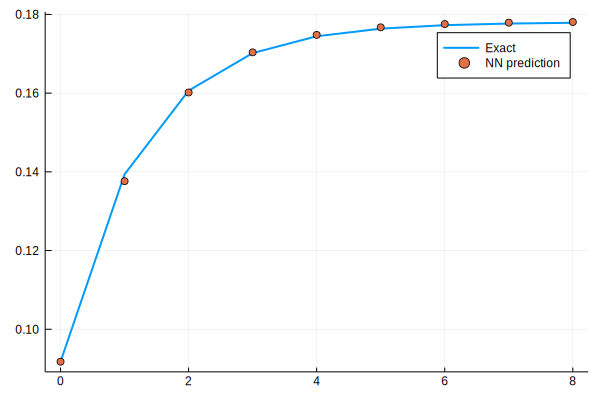

1.6153084f-5

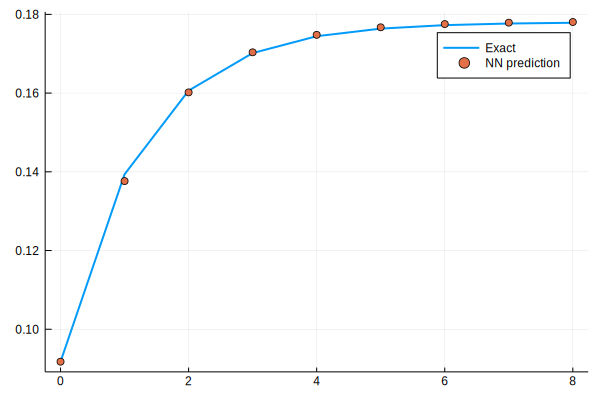

loss: 1.62e-05:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

1.5925854f-5

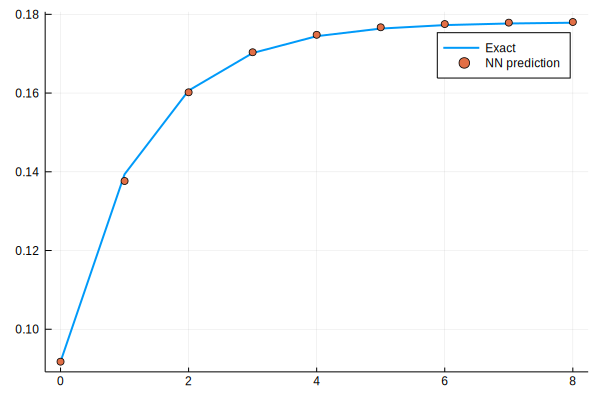

1.5703297f-5

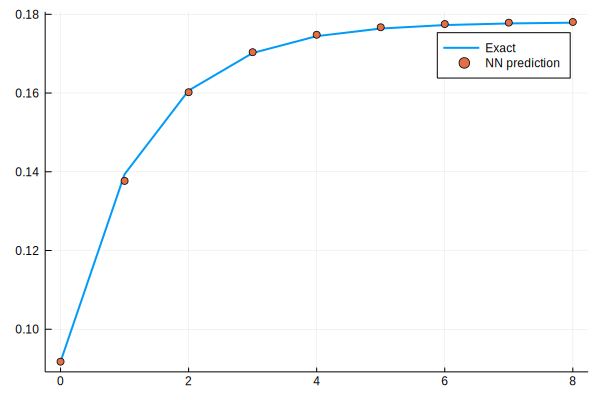

loss: 1.57e-05: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

1.5486248f-5

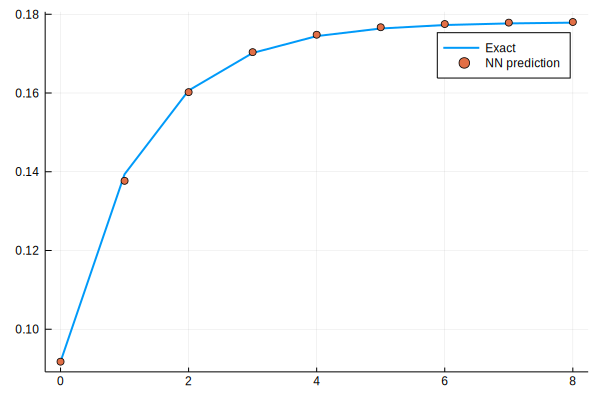

loss: 1.55e-05: 100%|█████████████████████████████████████████| Time: 0:00:30


1.5486248f-5

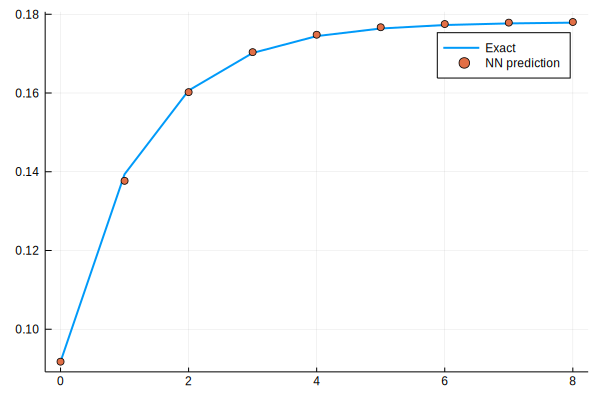

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [6.99e-02, 1.20e-01, 1.25e-01,  ...]
    Minimum:   1.548625e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [8.00e-02, 1.16e-01, 1.39e-01,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   31  (vs limit Inf)
    Iterations:    300
    f(x) calls:    300
    ∇f(x) calls:   300


In [17]:
res = DiffEqFlux.sciml_train(loss_n_ode, n_ode.p, ADAM(), cb=cb, maxiters=300)

0.00034883528f0

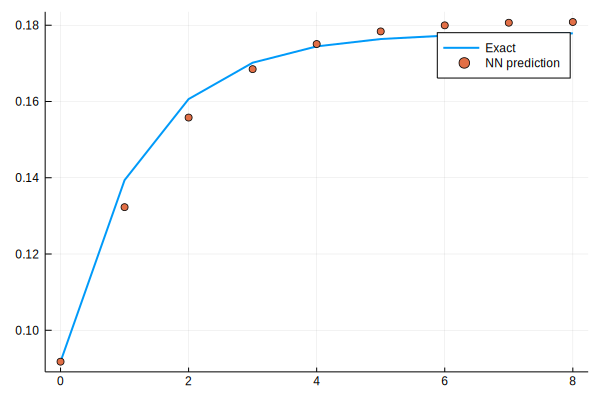

0.013086429f0

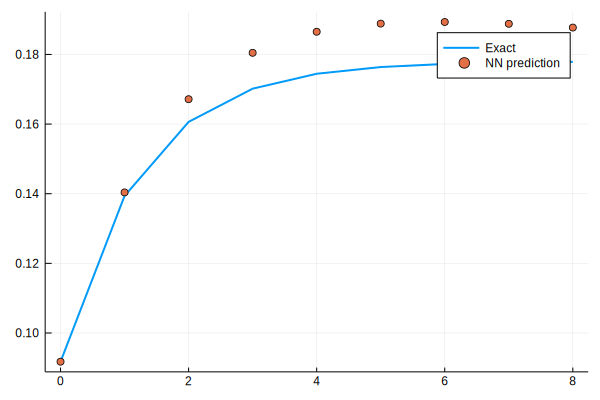

0.04794128f0

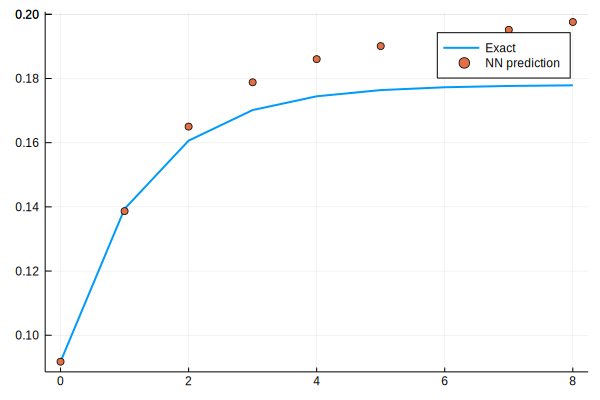

0.017672498f0

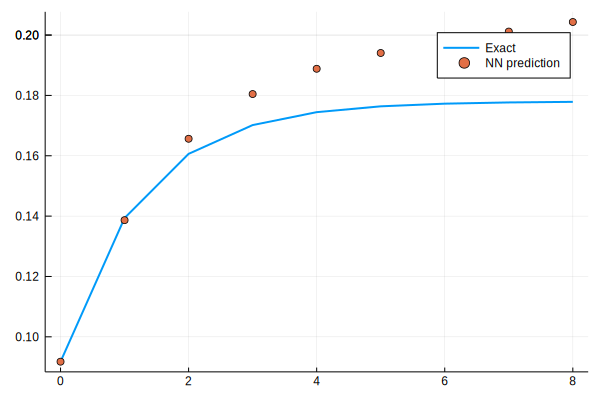

loss: 0.0177:   2%|▉                                        |  ETA: 0:00:06

0.020162942f0

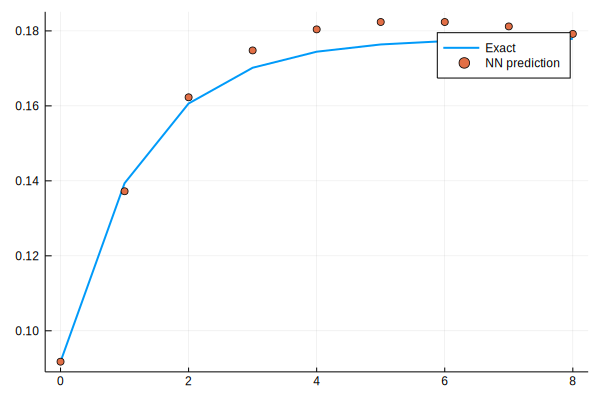

0.024690913f0

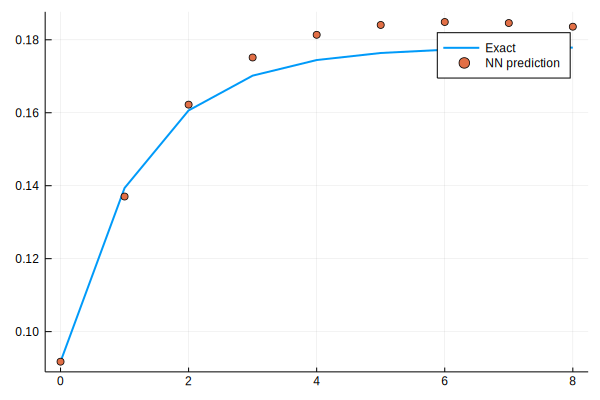

0.01651585f0

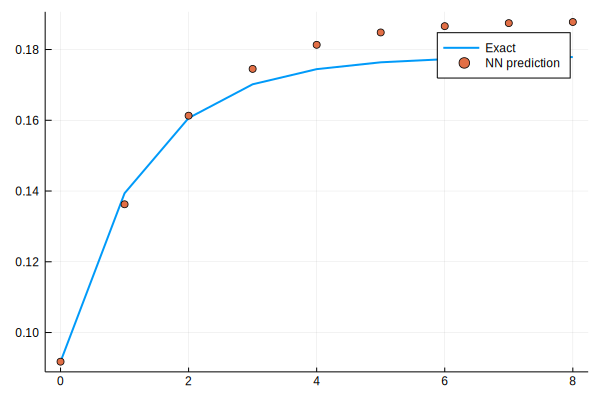

0.008054524f0

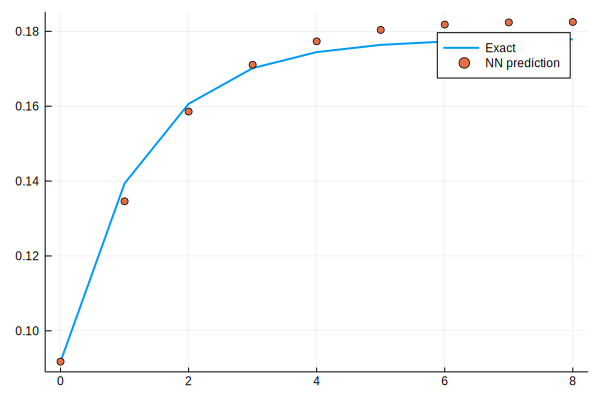

0.010013678f0

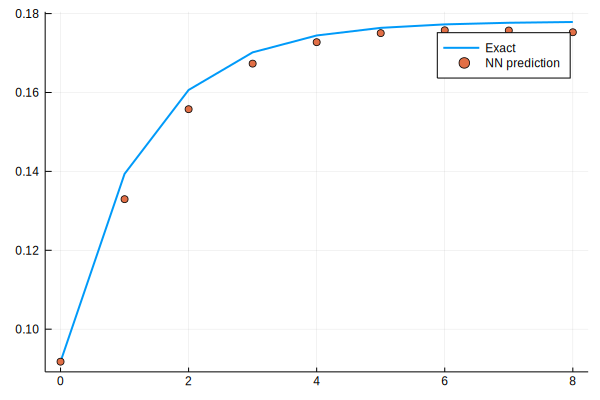

loss: 0.01:   4%|█▉                                       |  ETA: 0:00:05

0.013036283f0

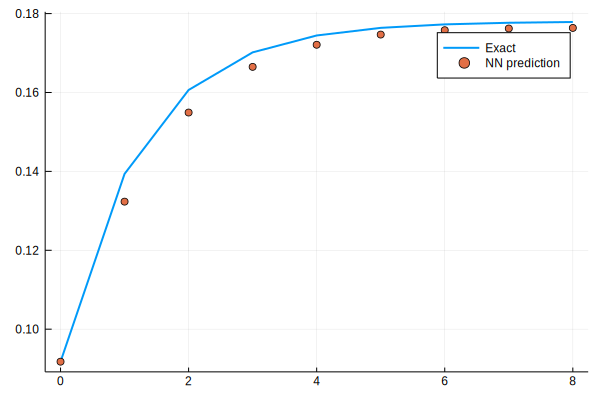

0.009367565f0

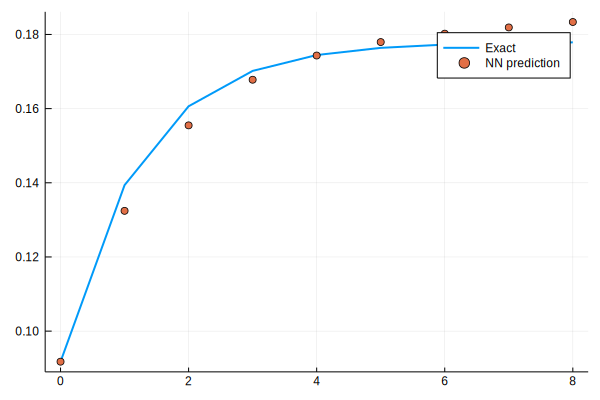

0.005329698f0

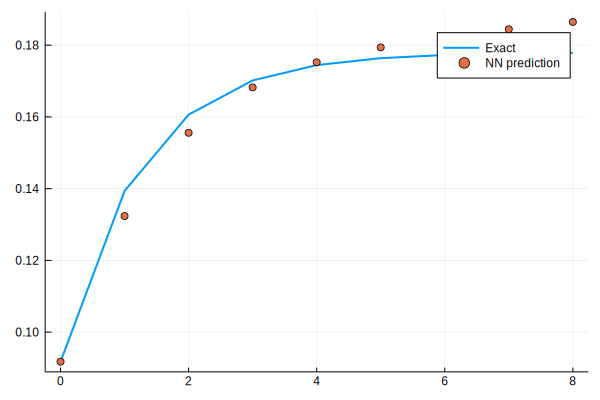

0.004449943f0

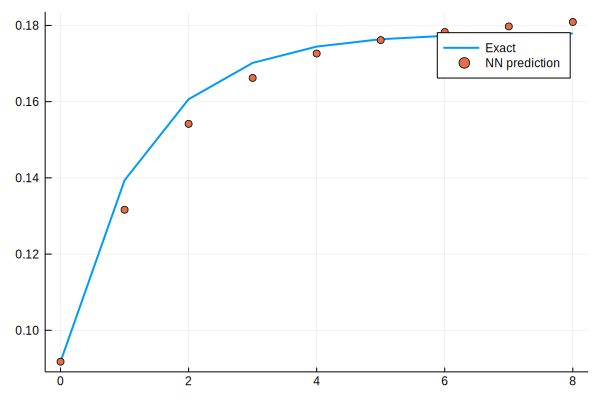

0.007231516f0

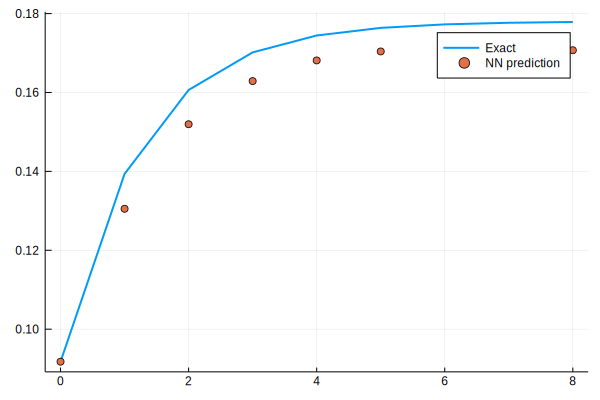

loss: 0.00723:   7%|██▉                                      |  ETA: 0:00:04

0.0093563935f0

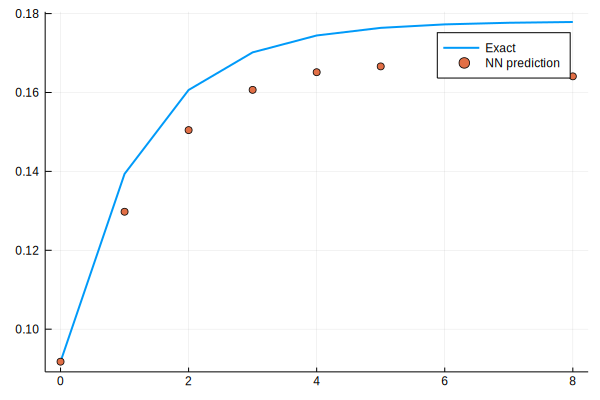

0.0065390524f0

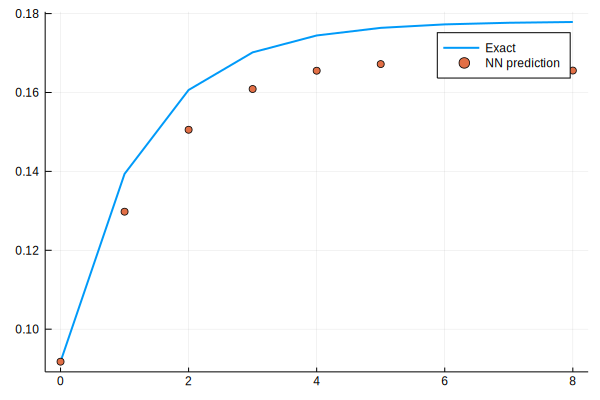

0.002710543f0

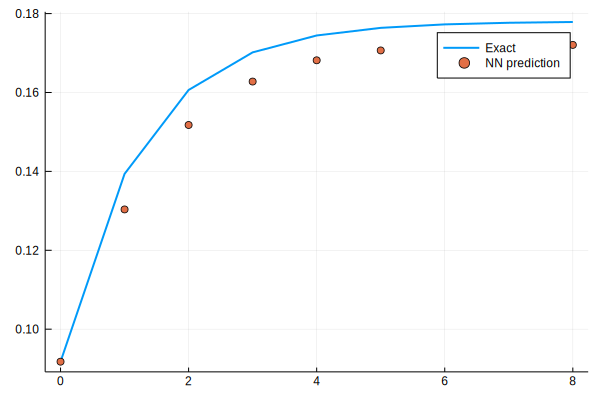

0.0022196148f0

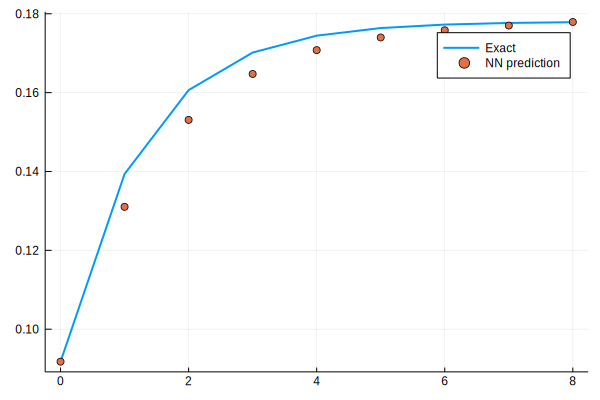

0.0040207575f0

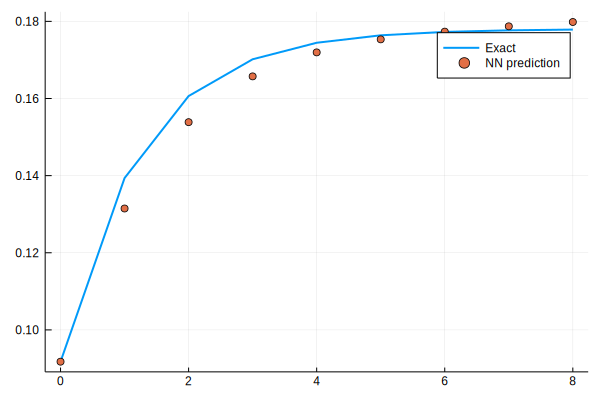

loss: 0.00402:  10%|███▉                                     |  ETA: 0:00:04

0.0051936125f0

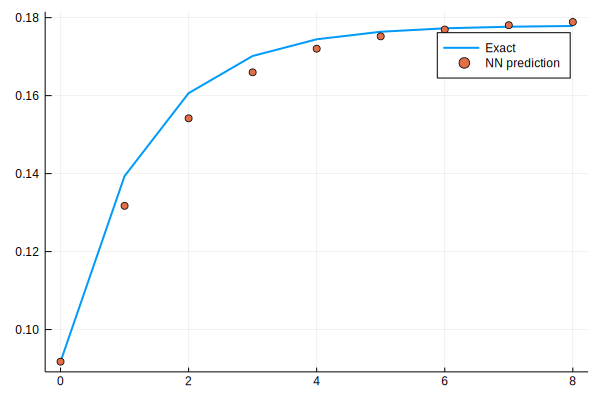

0.004072132f0

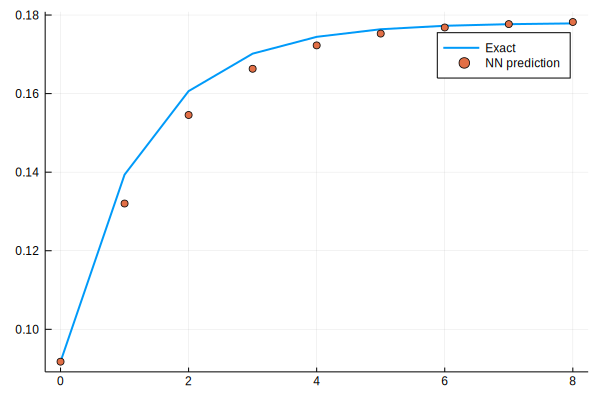

0.0021394112f0

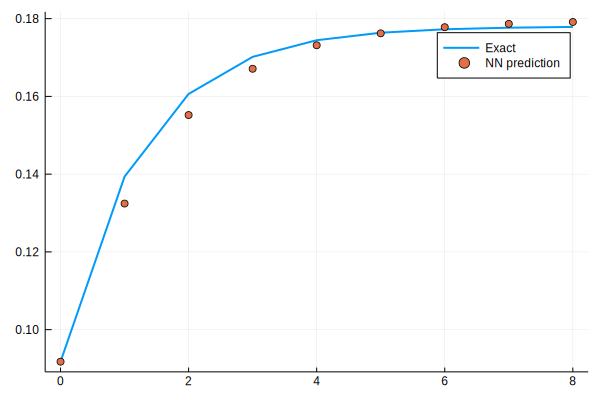

0.0015203804f0

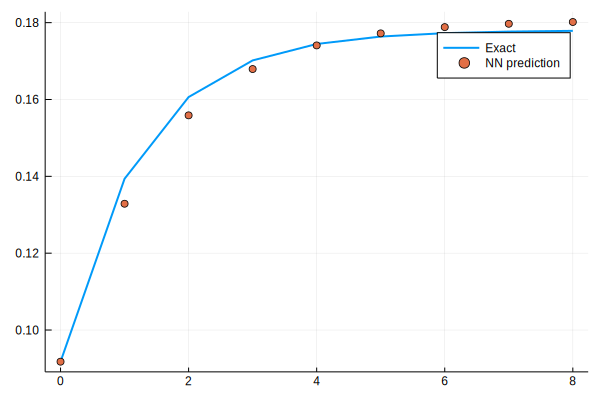

0.0021385169f0

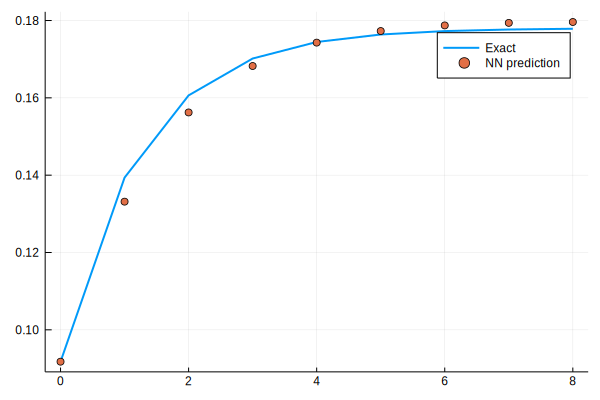

loss: 0.00214:  12%|████▉                                    |  ETA: 0:00:04

0.0026955663f0

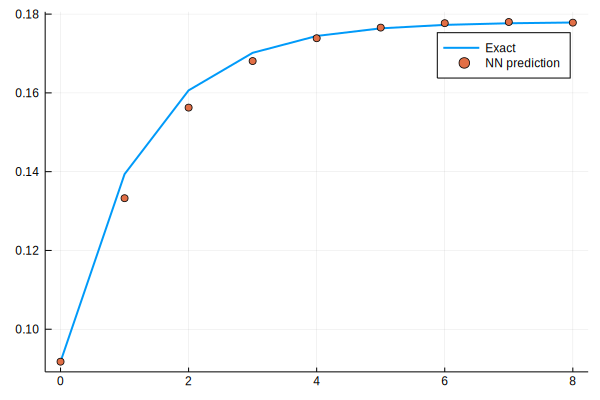

0.0022907315f0

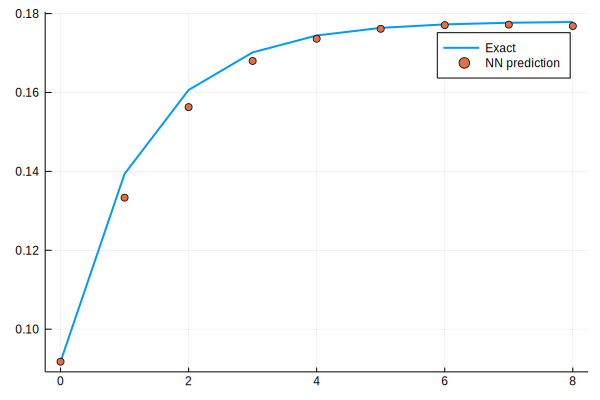

0.0014368246f0

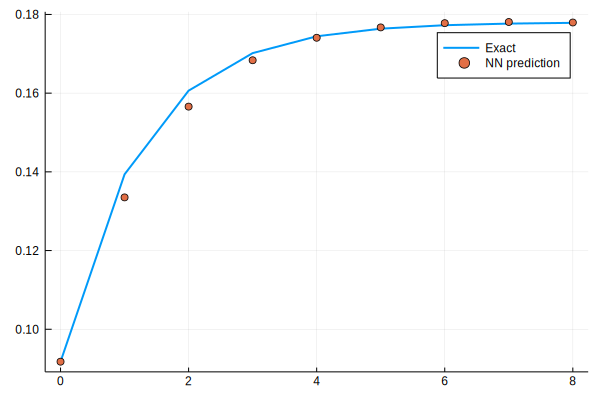

0.0011601596f0

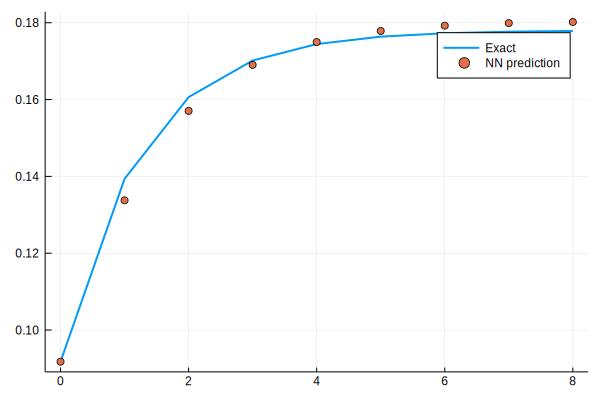

0.0013863981f0

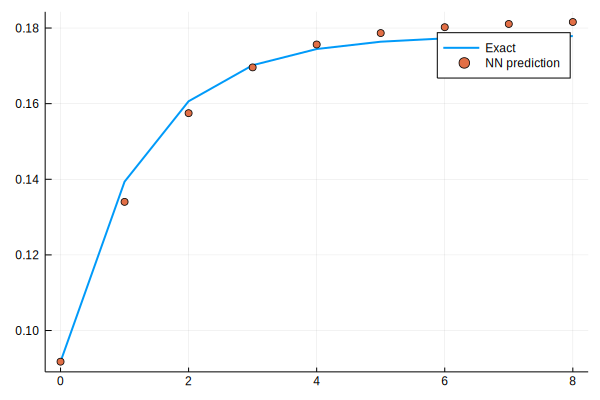

loss: 0.00139:  14%|██████                                   |  ETA: 0:00:04

0.0016192482f0

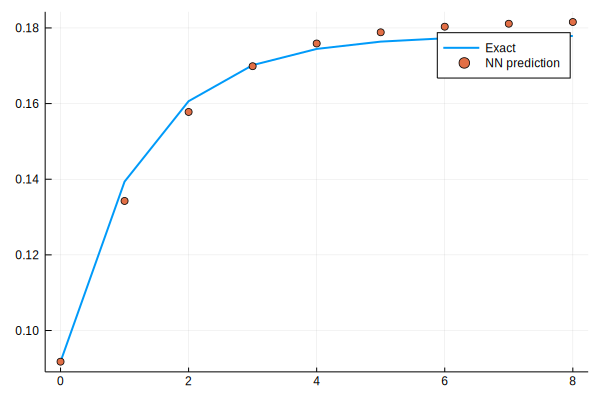

0.0014119815f0

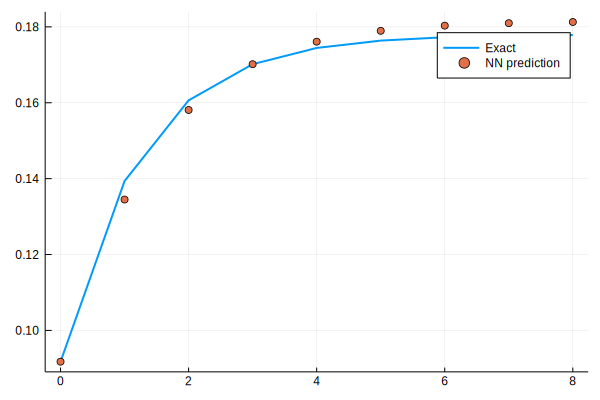

0.00085453904f0

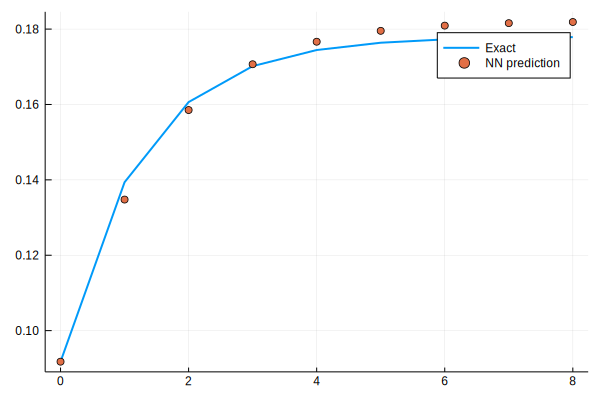

0.0008442564f0

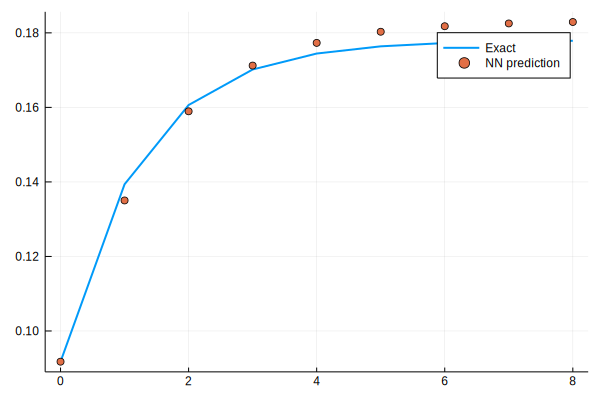

0.0012089427f0

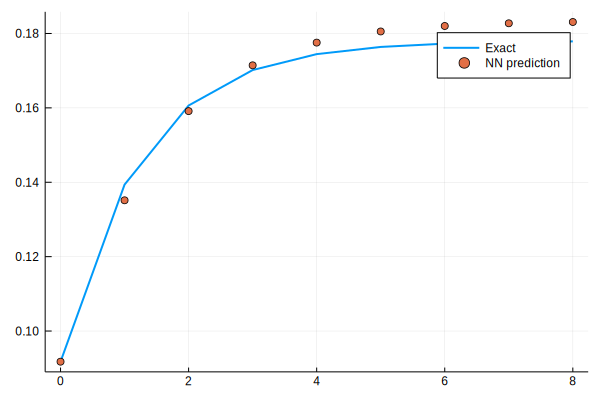

loss: 0.00121:  17%|███████                                  |  ETA: 0:00:04

0.0011584524f0

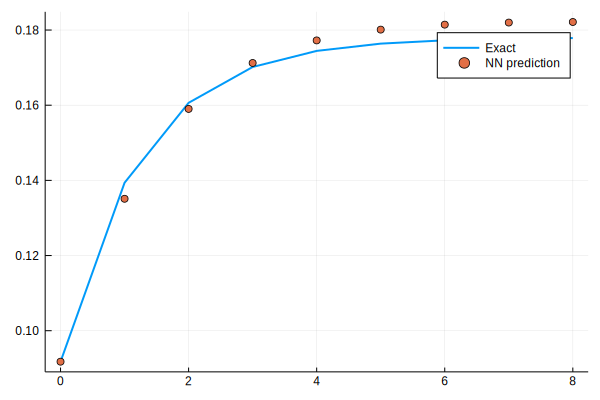

0.00082356937f0

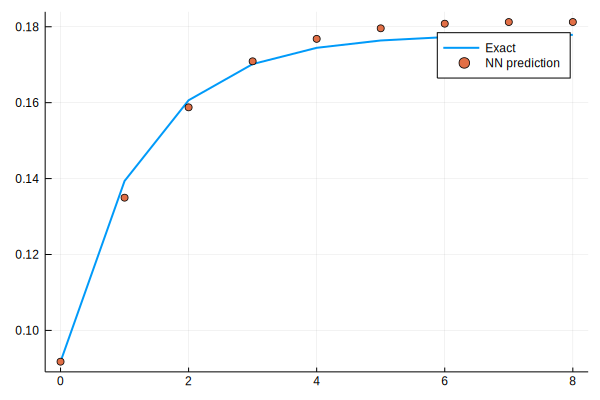

0.00053799915f0

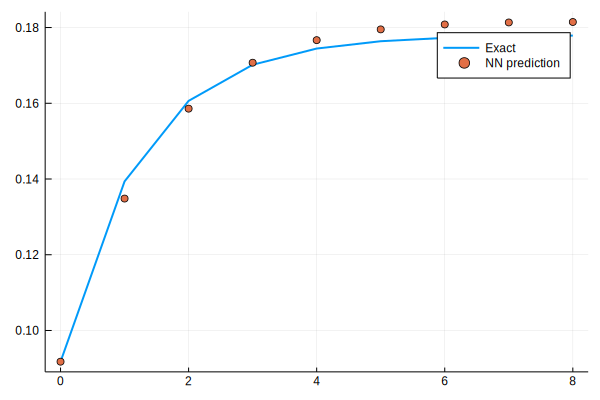

0.0005615002f0

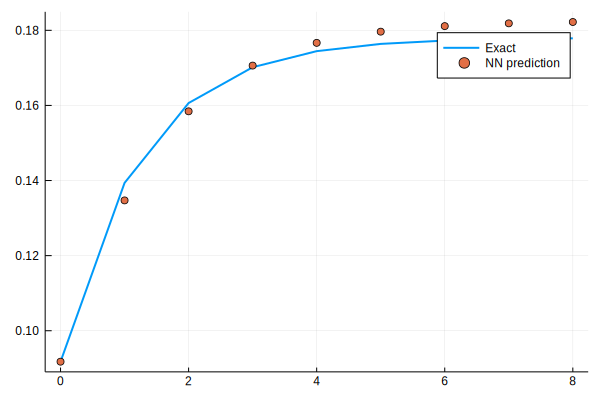

0.0007924927f0

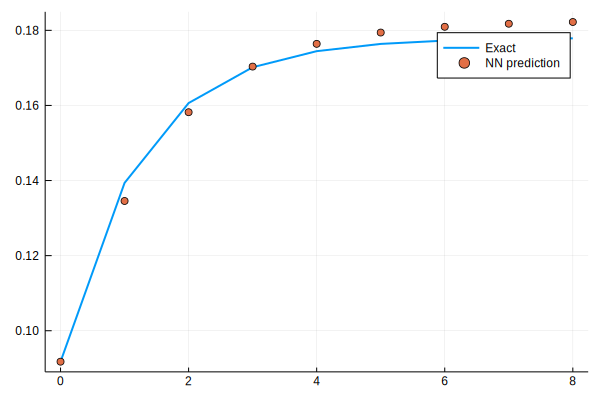

loss: 0.000792:  20%|████████                                 |  ETA: 0:00:04

0.0007957542f0

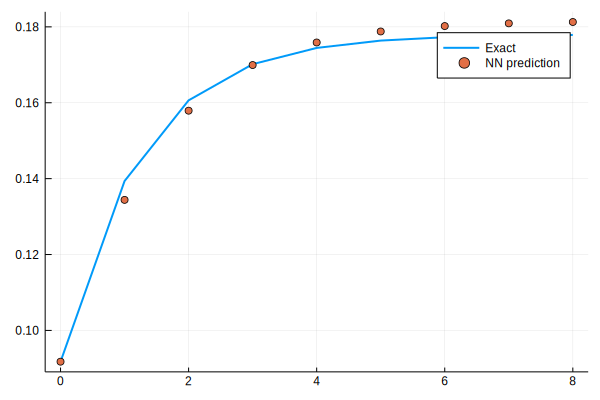

0.0005753431f0

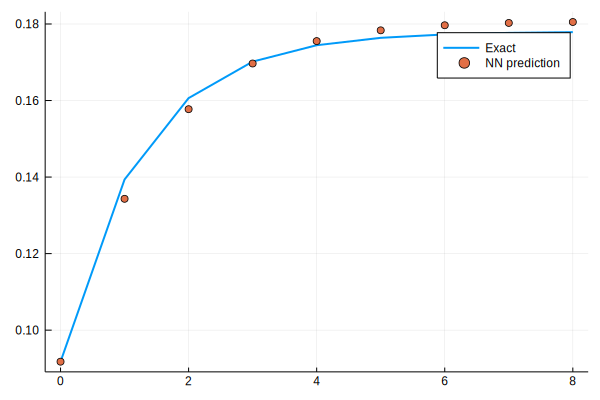

0.00037104057f0

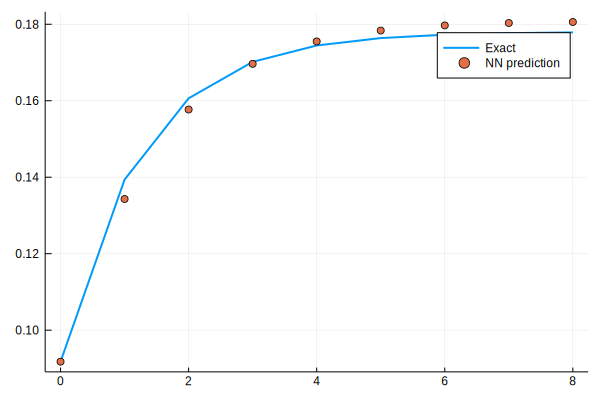

0.00036194816f0

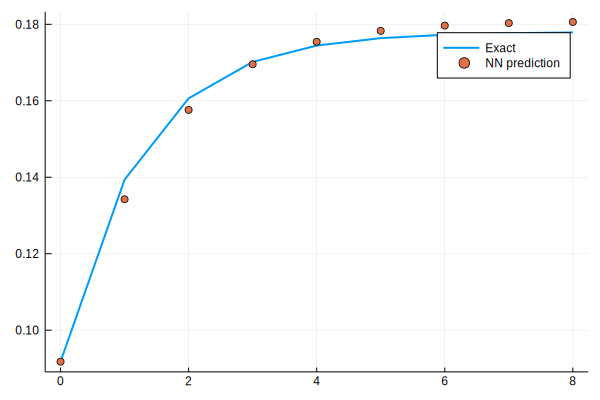

0.00048496306f0

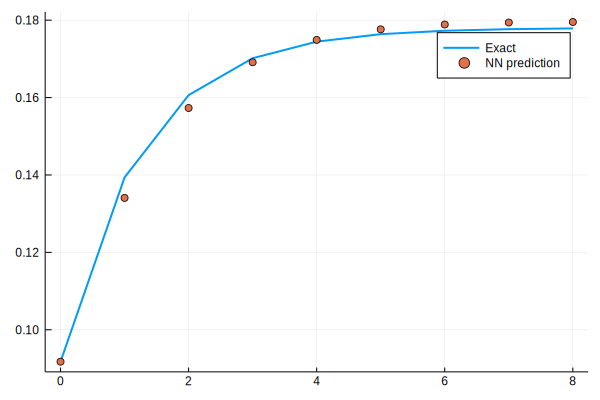

loss: 0.000485:  22%|█████████                                |  ETA: 0:00:04

0.00053218735f0

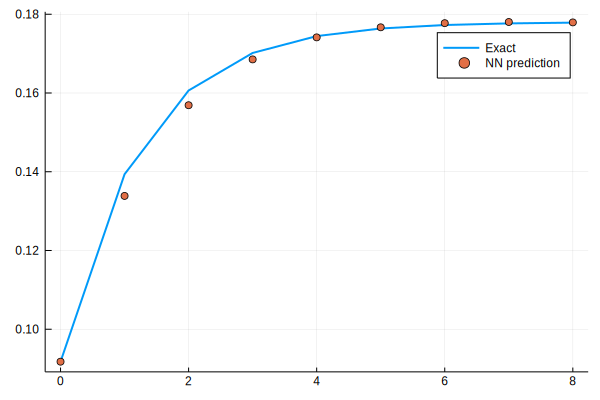

0.00042620735f0

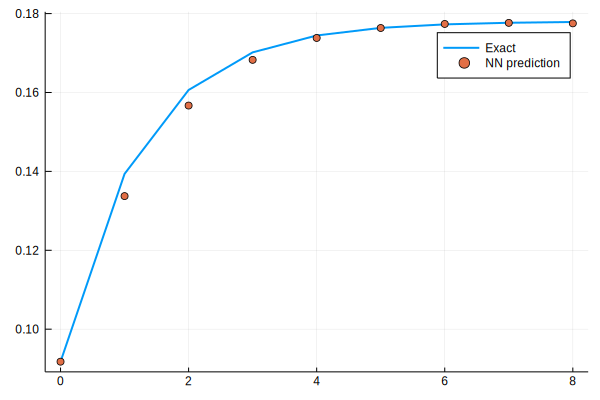

0.00031040155f0

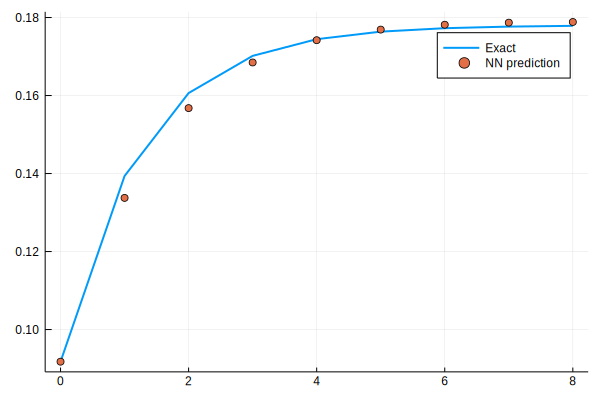

0.0003349101f0

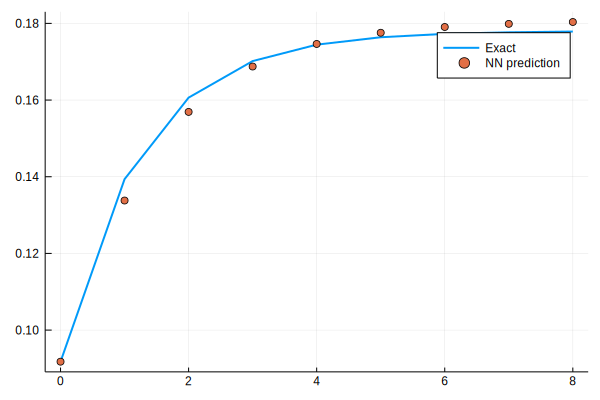

0.00036672037f0

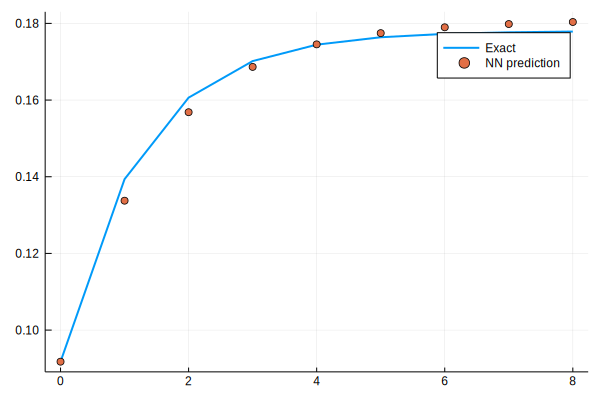

loss: 0.000367:  24%|██████████                               |  ETA: 0:00:03

0.00034991346f0

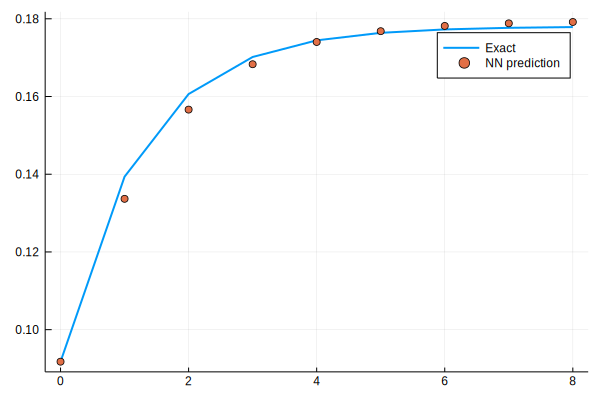

0.00031172688f0

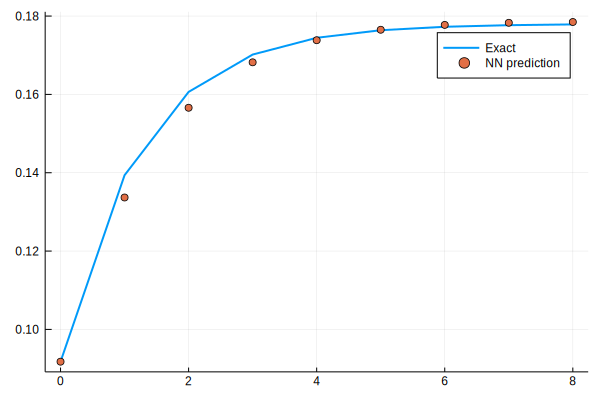

0.00027341596f0

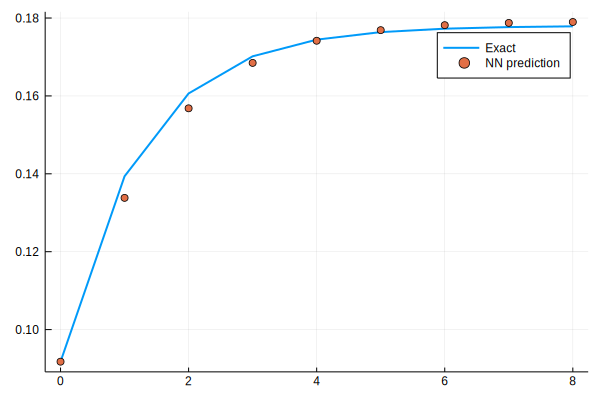

0.00028481532f0

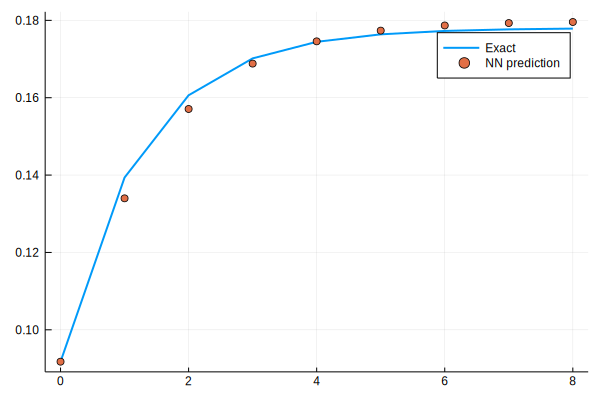

0.0002795756f0

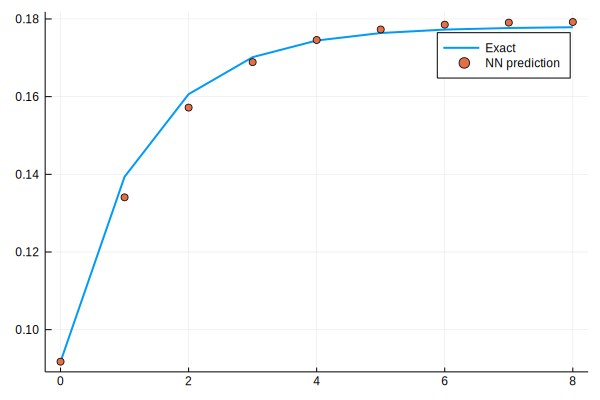

loss: 0.00028:  27%|███████████▏                             |  ETA: 0:00:03

0.00026131023f0

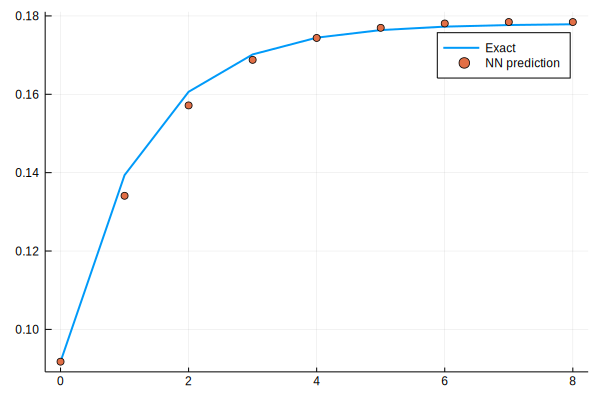

0.00023631362f0

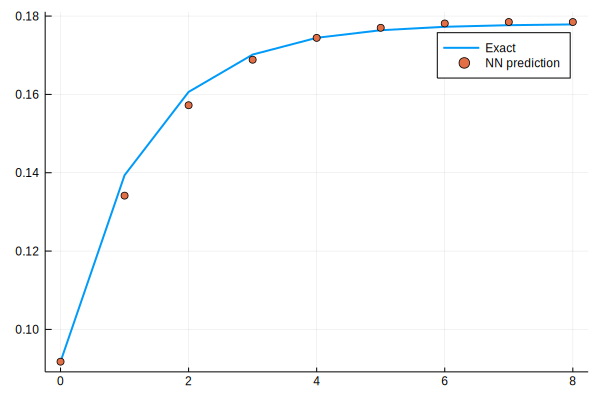

0.00021638002f0

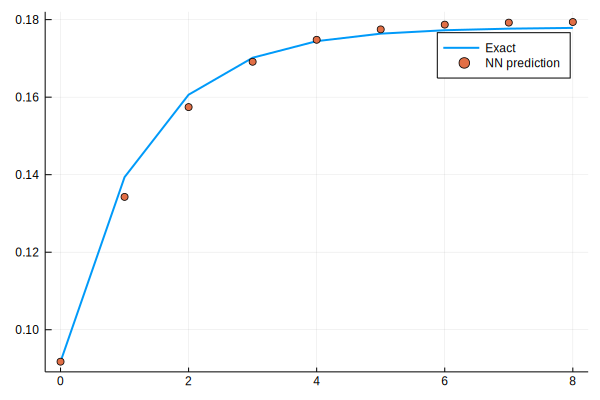

0.00022272856f0

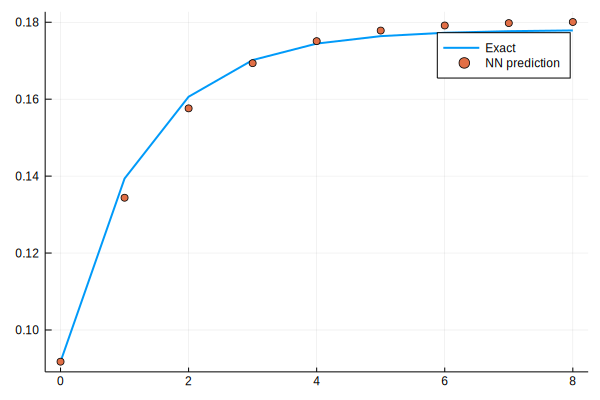

loss: 0.000223:  29%|███████████▉                             |  ETA: 0:00:03

0.00022144518f0

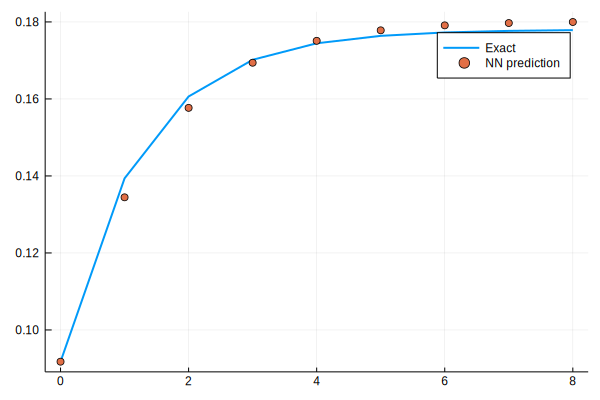

0.00021221065f0

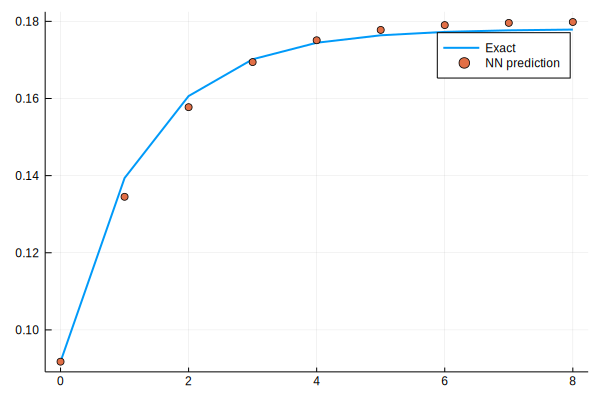

0.00019984871f0

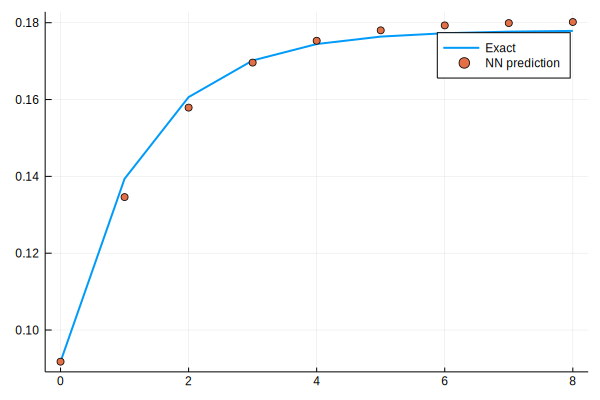

0.00019011278f0

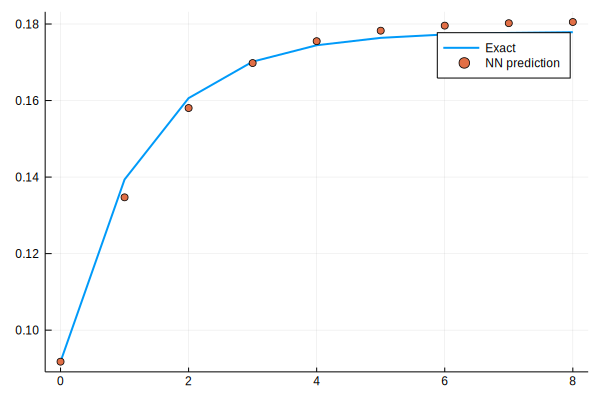

0.00018610903f0

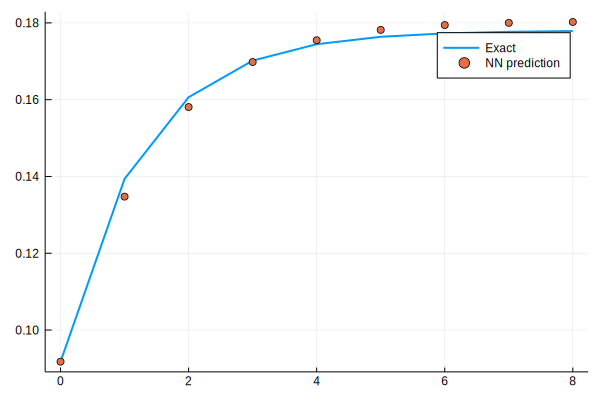

loss: 0.000186:  32%|████████████▉                            |  ETA: 0:00:03

0.00019076797f0

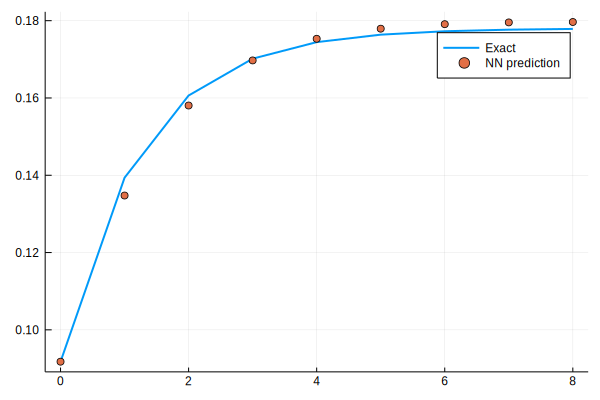

0.00018248588f0

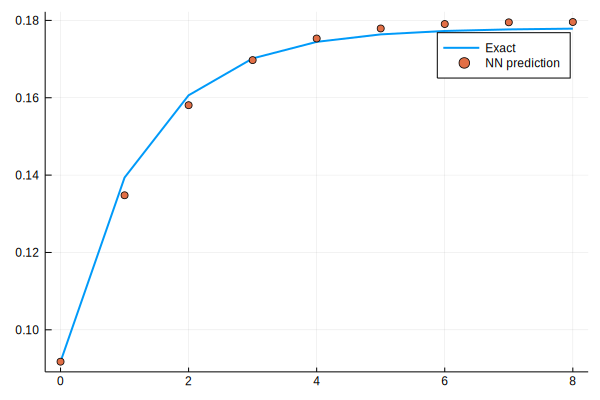

0.00017465359f0

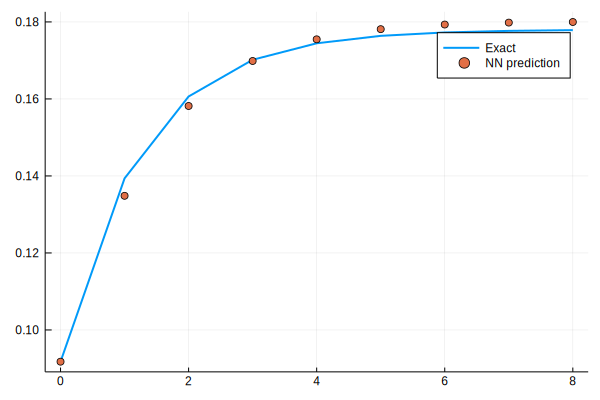

0.00016910884f0

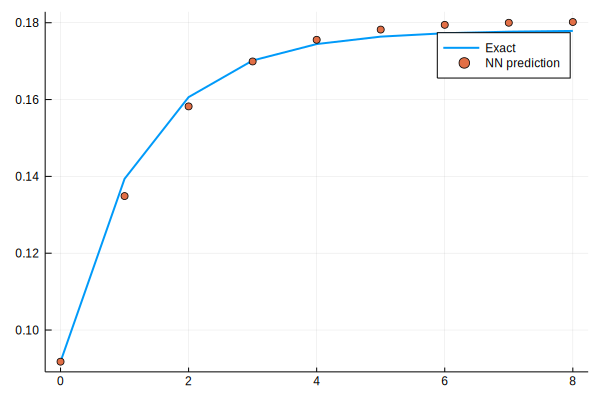

0.00016832424f0

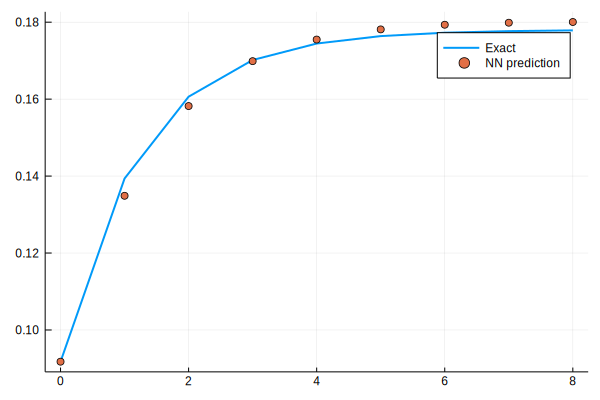

loss: 0.000168:  34%|██████████████                           |  ETA: 0:00:03

0.00016490788f0

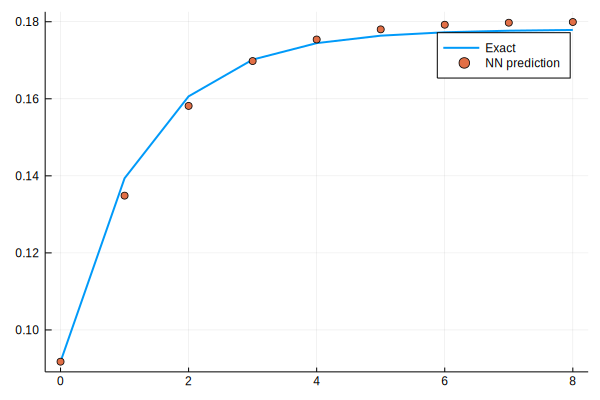

0.00015641197f0

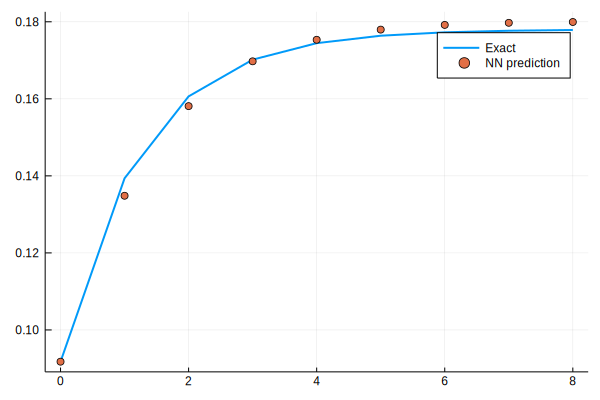

0.00015291496f0

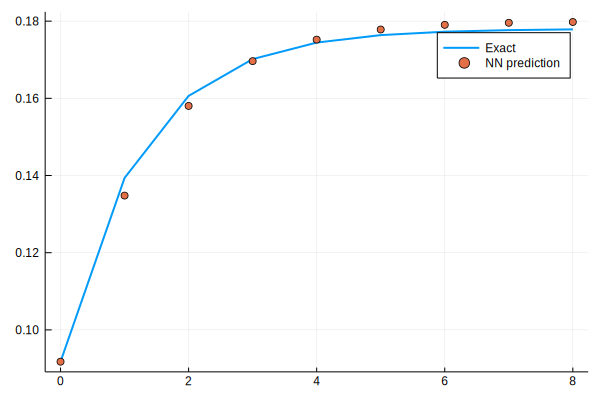

0.00015026417f0

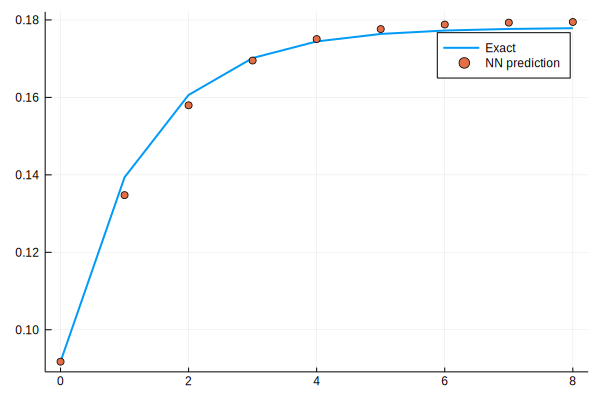

0.00015212073f0

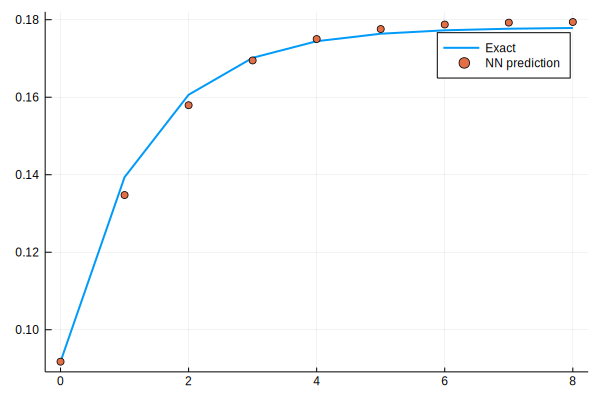

loss: 0.000152:  36%|███████████████                          |  ETA: 0:00:03

0.0001471344f0

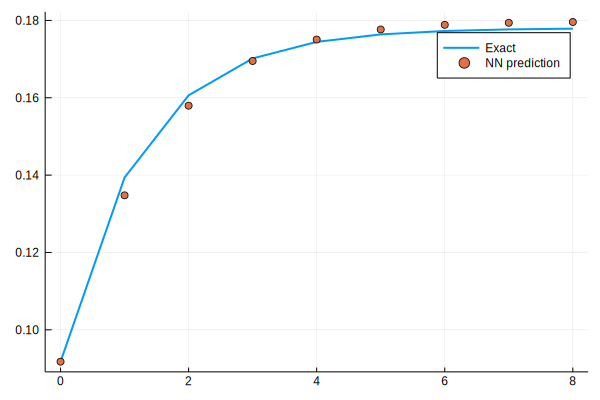

0.00014009868f0

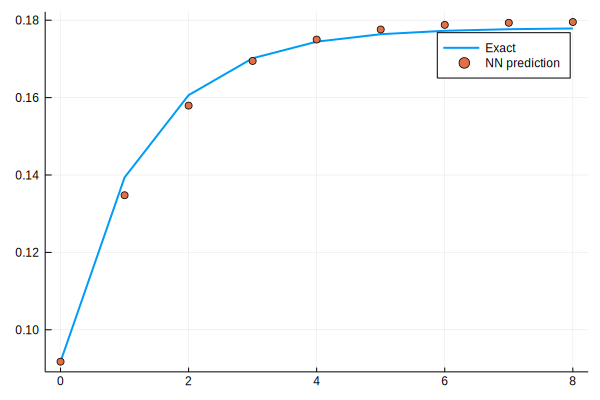

0.0001387826f0

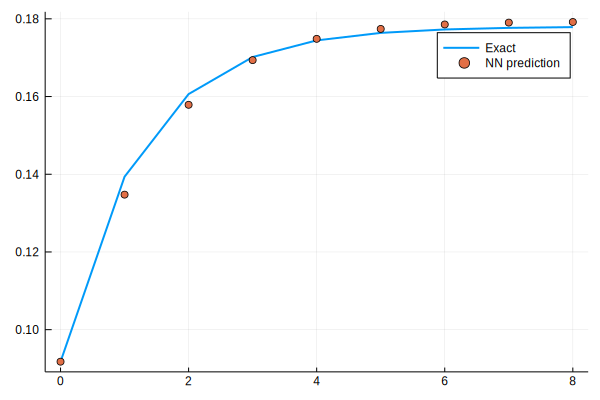

0.0001403795f0

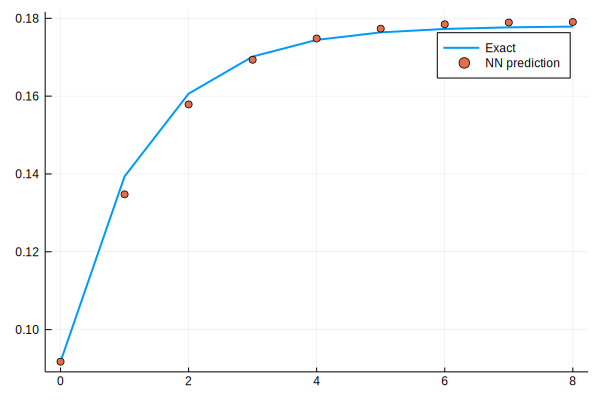

0.00013779626f0

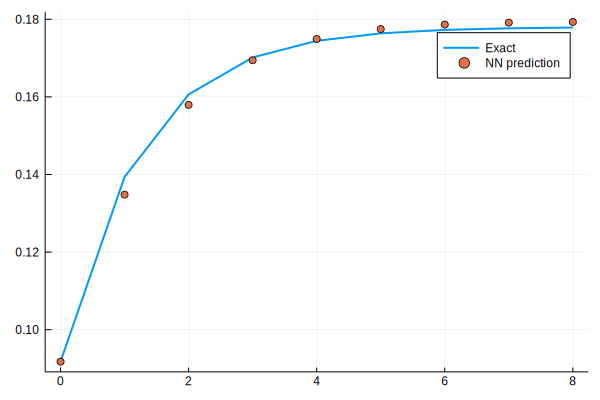

0.00013381556f0

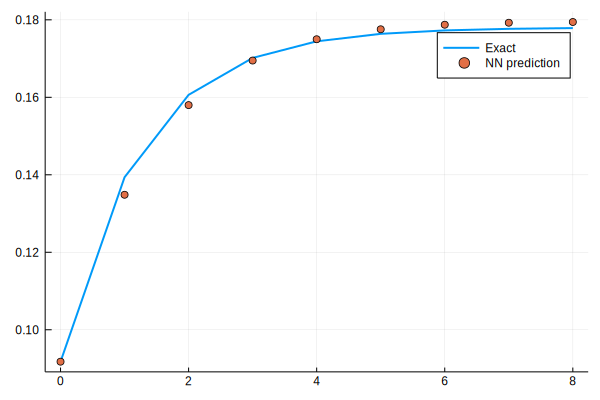

loss: 0.000134:  40%|████████████████▎                        |  ETA: 0:00:03

0.00013126596f0

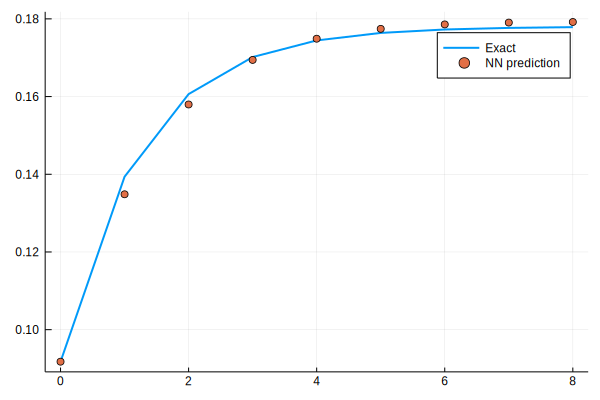

0.00013071582f0

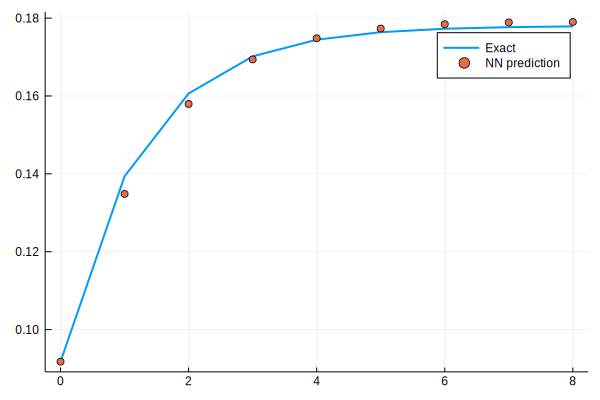

0.0001279955f0

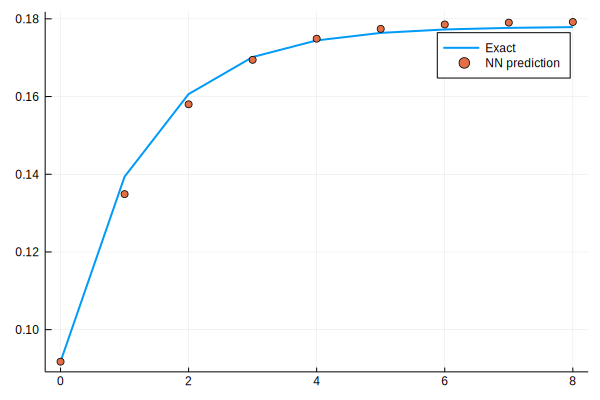

0.00012593626f0

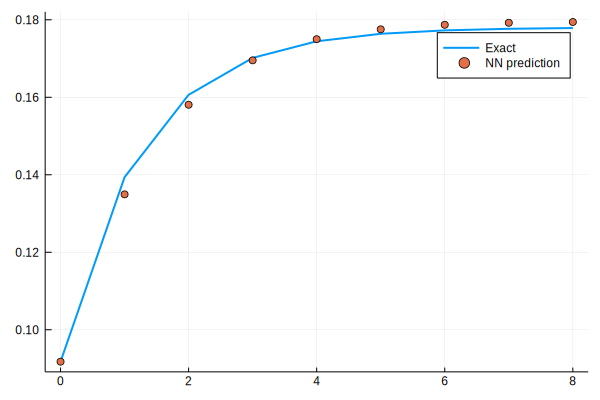

0.00012366271f0

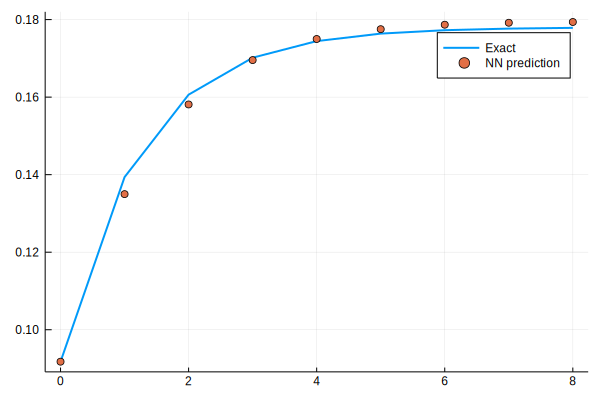

loss: 0.000124:  42%|█████████████████▎                       |  ETA: 0:00:03

0.00012344979f0

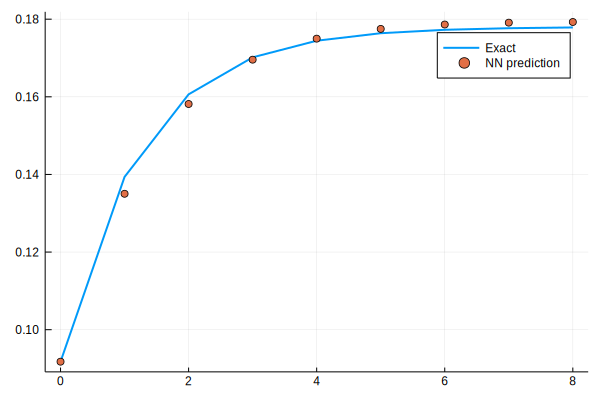

0.000120758916f0

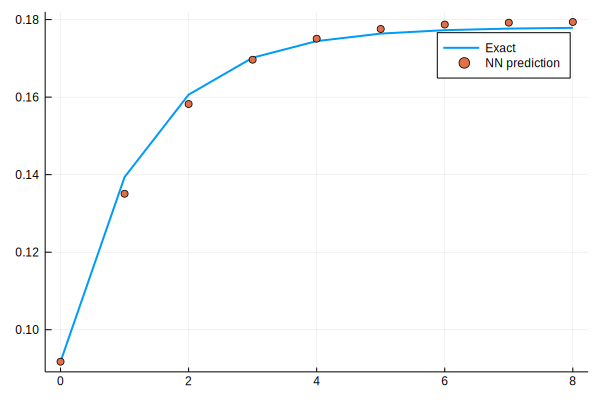

0.000117918826f0

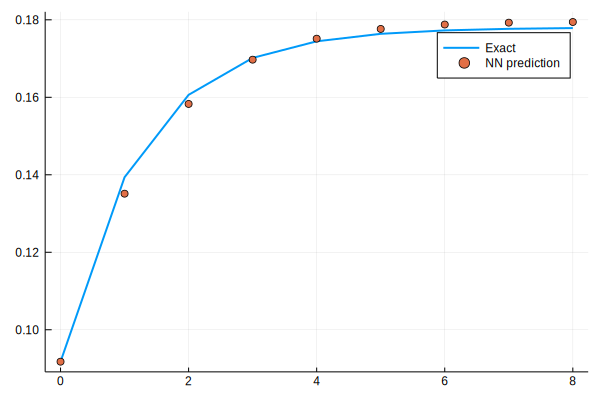

0.000117144744f0

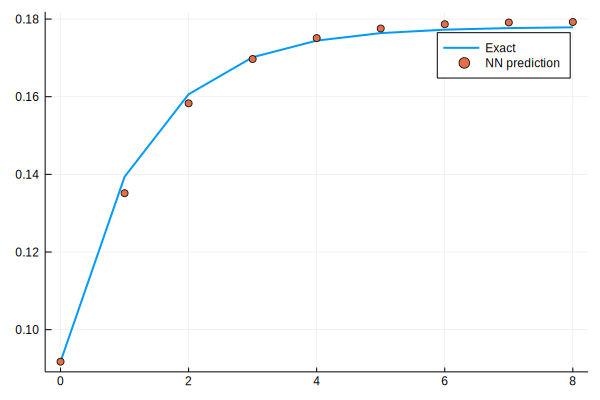

loss: 0.000117:  44%|██████████████████                       |  ETA: 0:00:03

0.00011715239f0

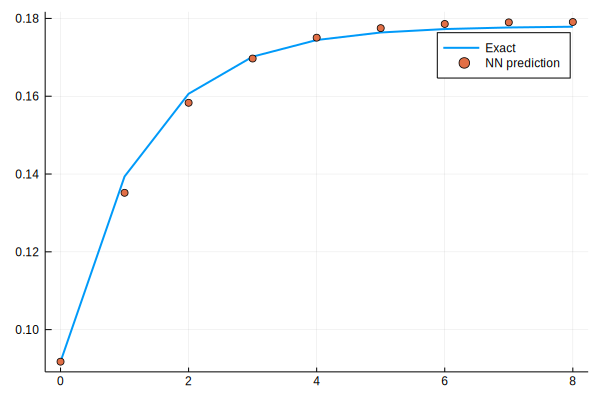

0.00011484504f0

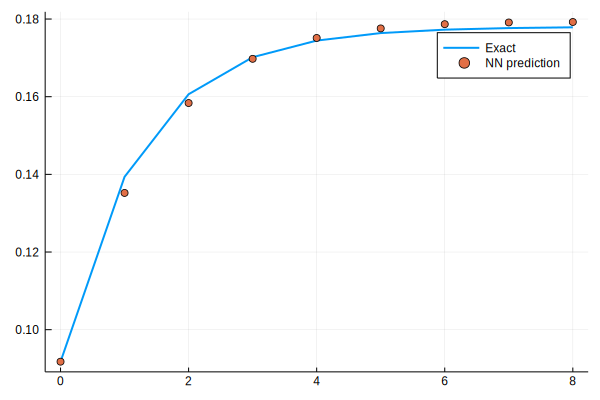

0.000112014444f0

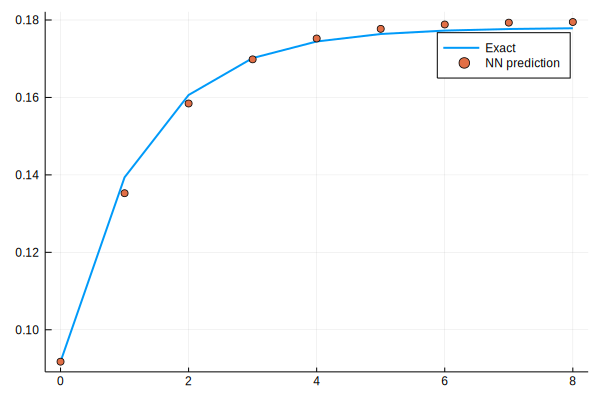

0.00011131597f0

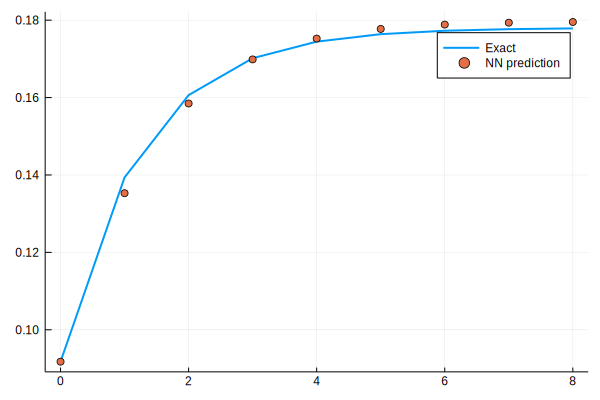

0.00011136719f0

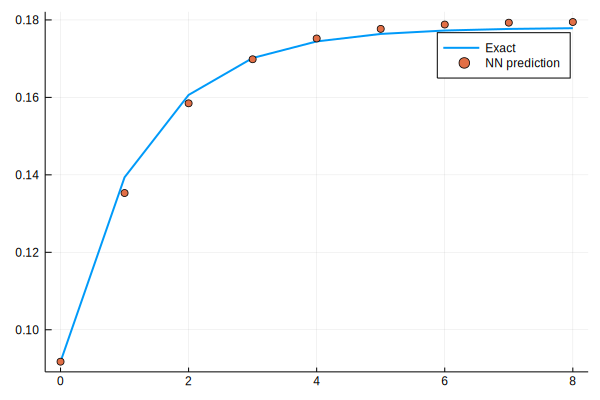

loss: 0.000111:  46%|███████████████████▏                     |  ETA: 0:00:02

0.000109492335f0

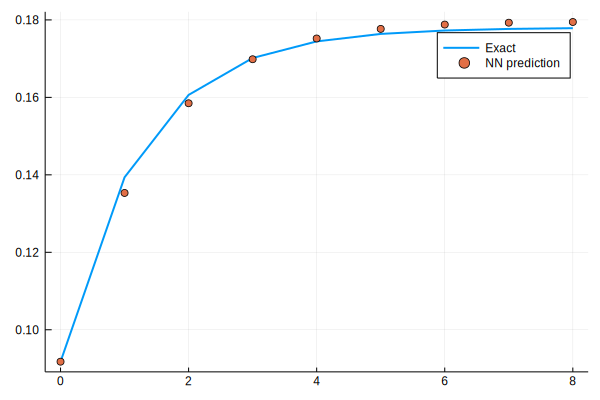

0.00010677961f0

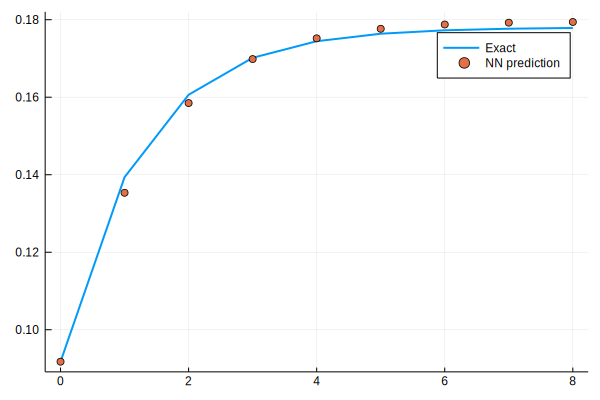

0.000105747065f0

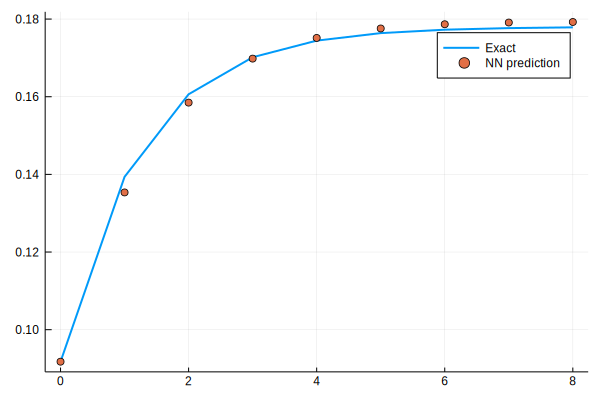

0.00010570905f0

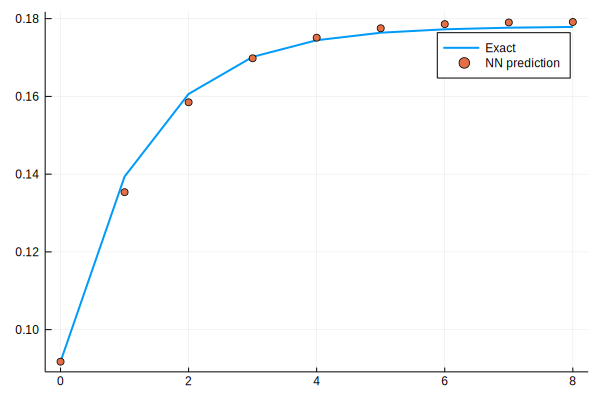

0.00010408985f0

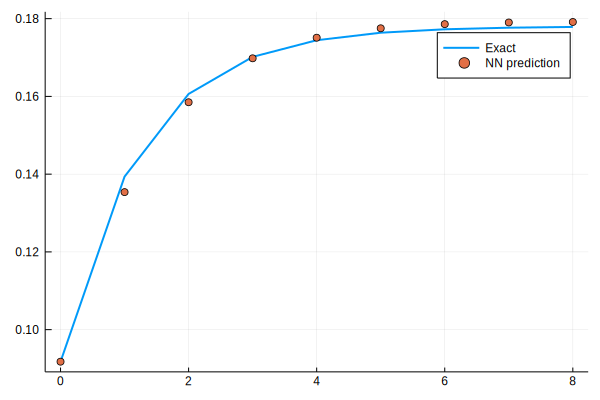

loss: 0.000104:  49%|████████████████████▏                    |  ETA: 0:00:02

0.00010207338f0

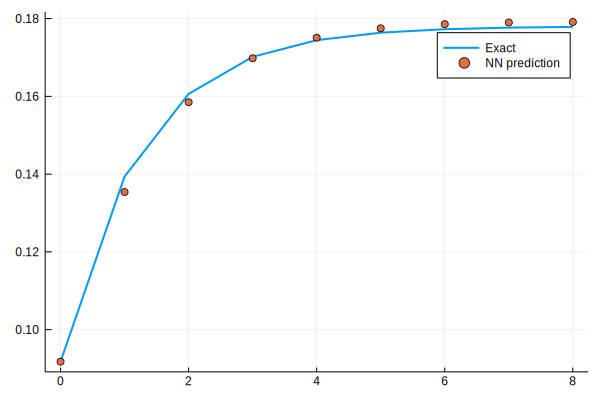

0.00010095584f0

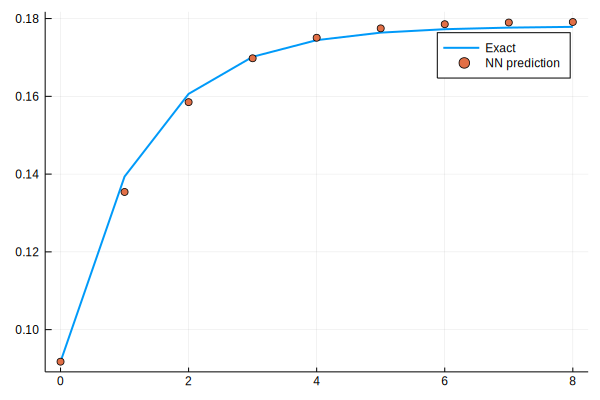

0.000100362246f0

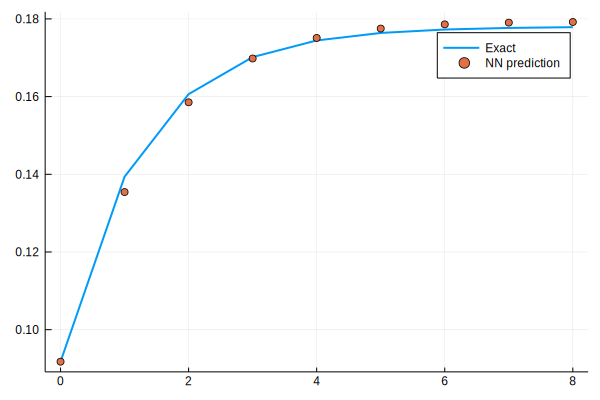

9.905808f-5

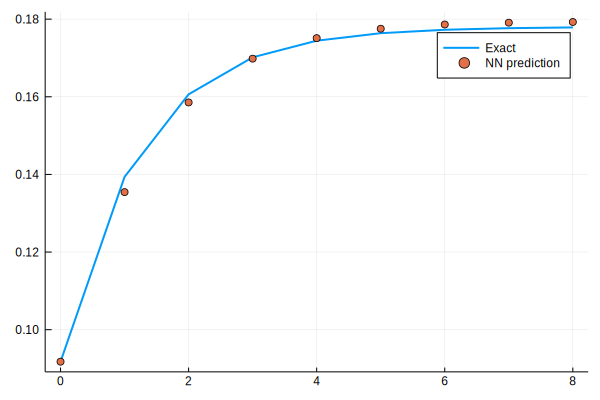

9.758652f-5

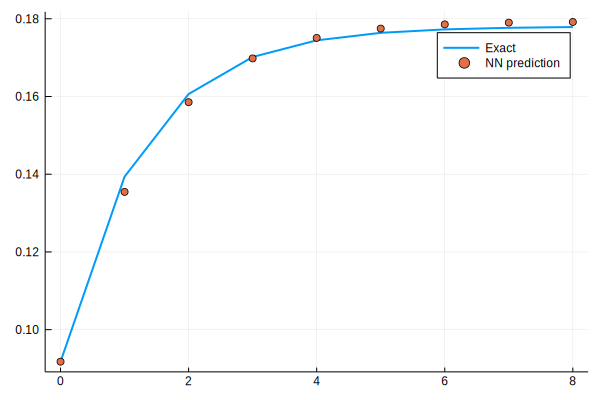

9.666665f-5

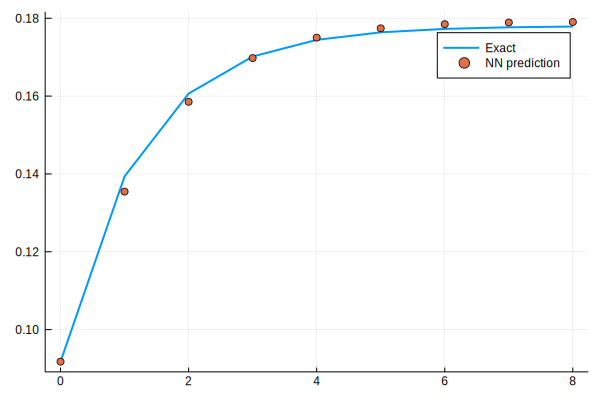

loss: 9.67e-05:  52%|█████████████████████▍                   |  ETA: 0:00:02

9.5765674f-5

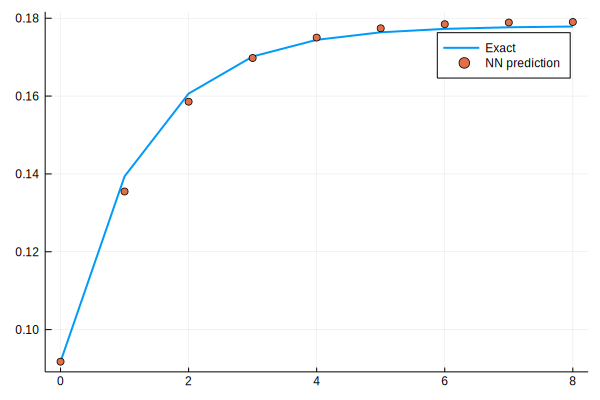

9.4389296f-5

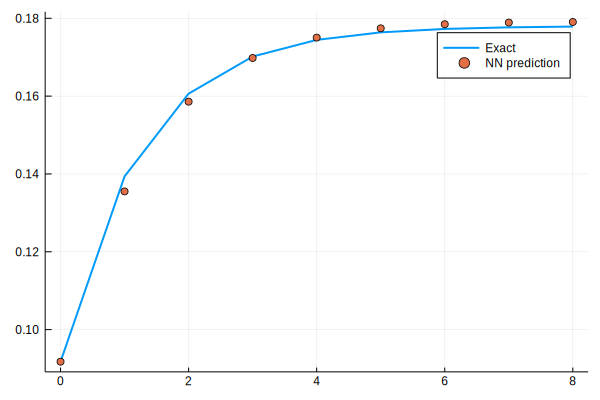

9.3185394f-5

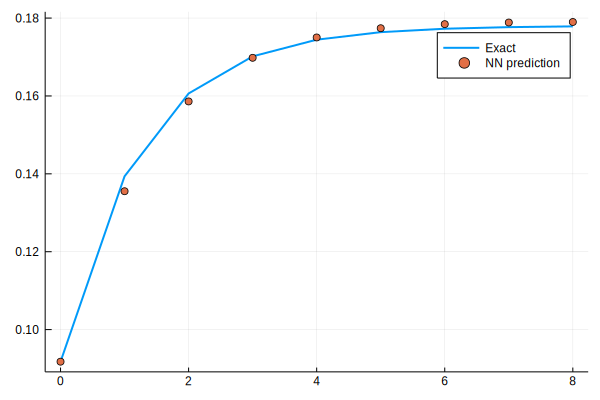

9.244078f-5

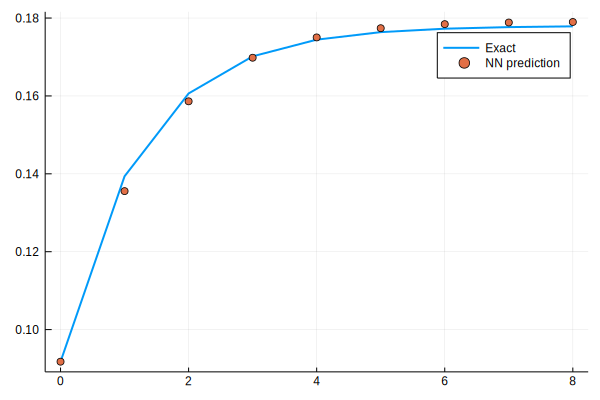

9.1371f-5

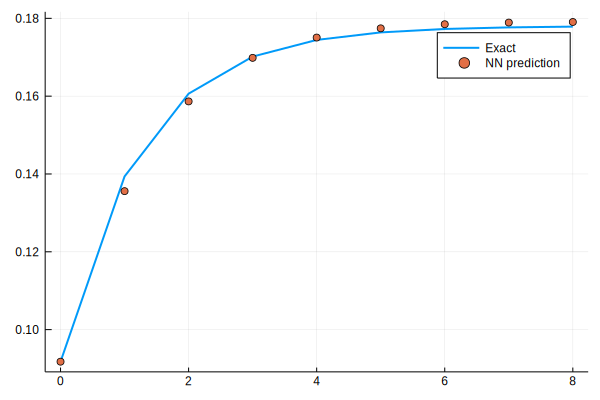

loss: 9.14e-05:  54%|██████████████████████▍                  |  ETA: 0:00:02

9.0113615f-5

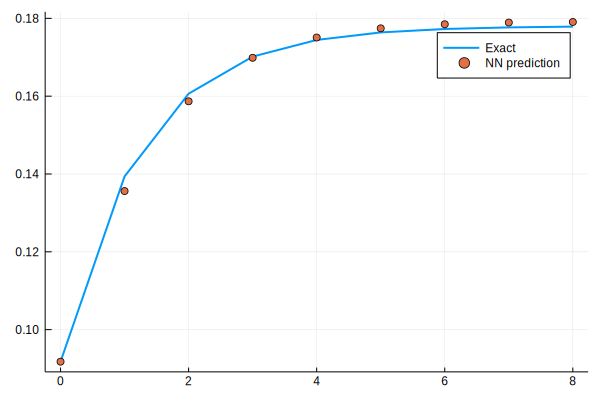

8.9059635f-5

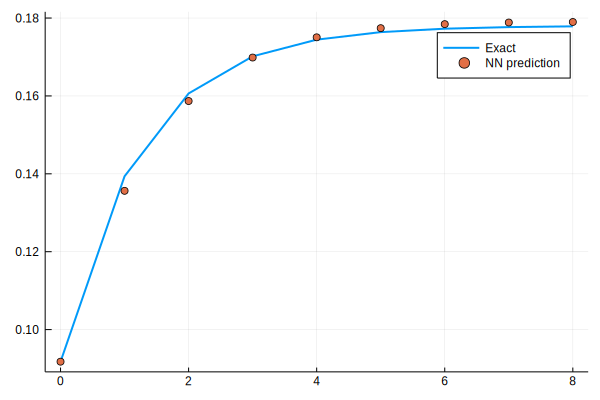

8.820894f-5

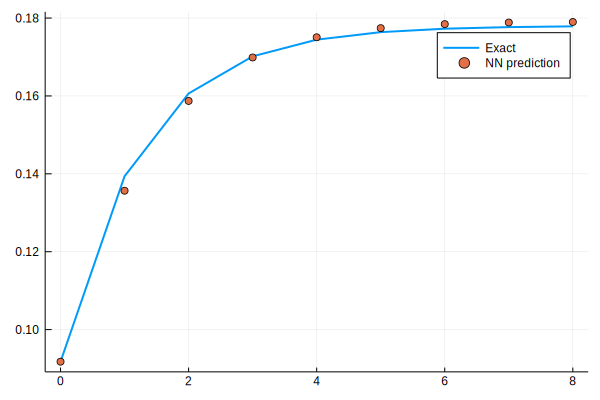

8.720663f-5

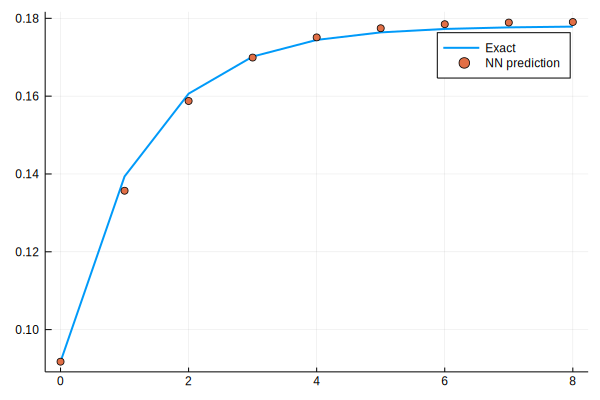

loss: 8.72e-05:  56%|███████████████████████▏                 |  ETA: 0:00:02

8.6108164f-5

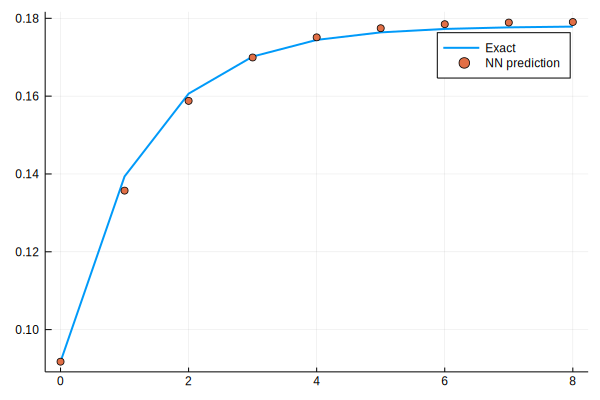

8.516165f-5

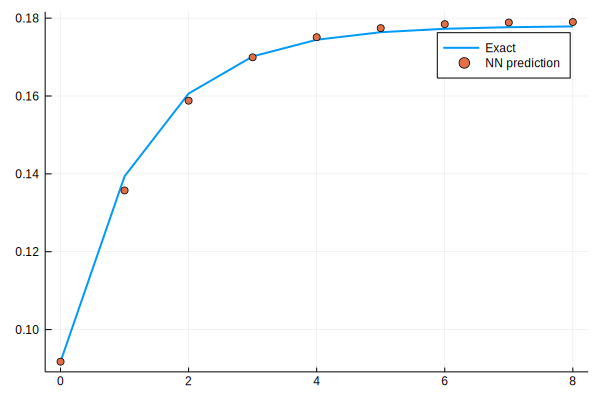

8.427542f-5

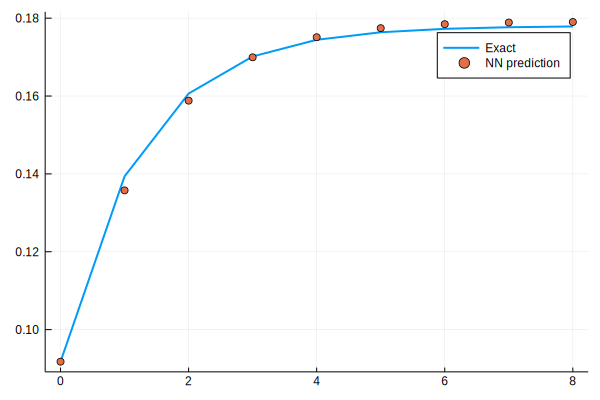

8.3272294f-5

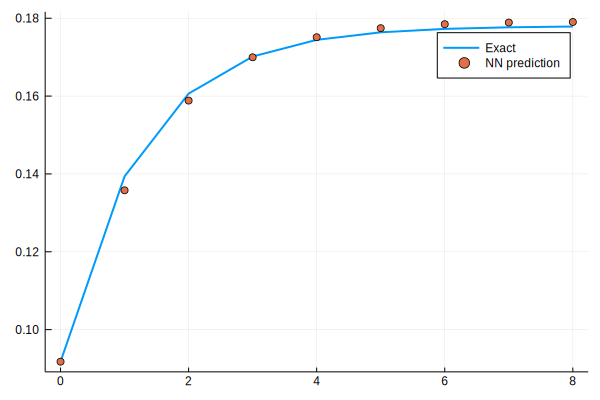

8.23059f-5

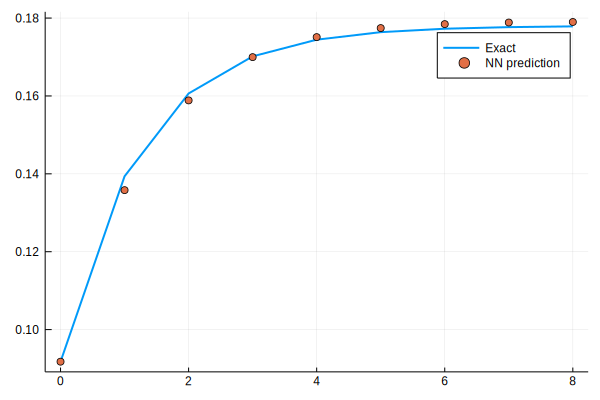

loss: 8.23e-05:  59%|████████████████████████▎                |  ETA: 0:00:02

8.1418795f-5

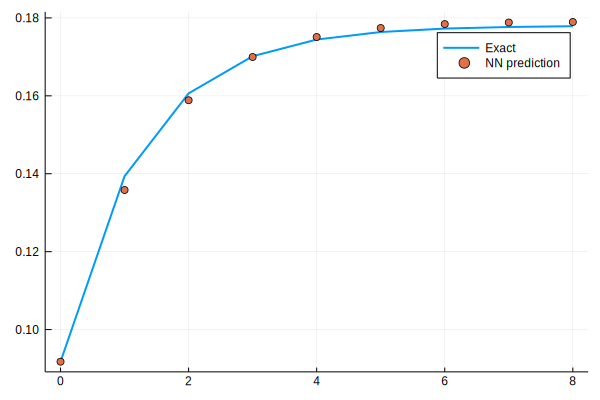

8.051494f-5

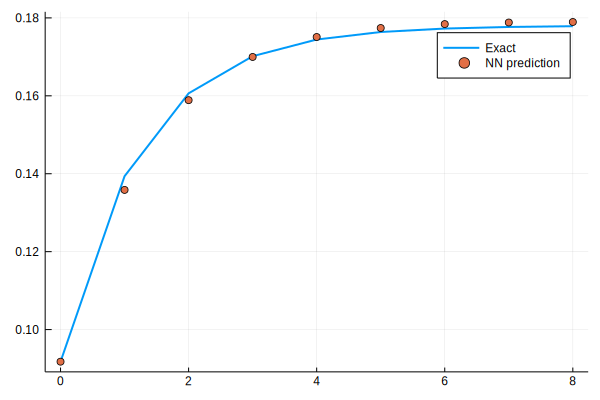

7.955865f-5

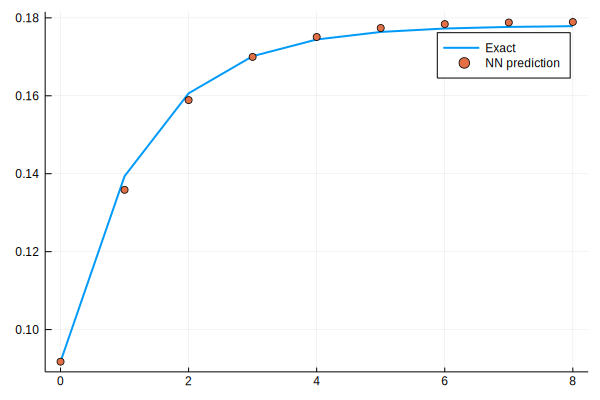

7.8667385f-5

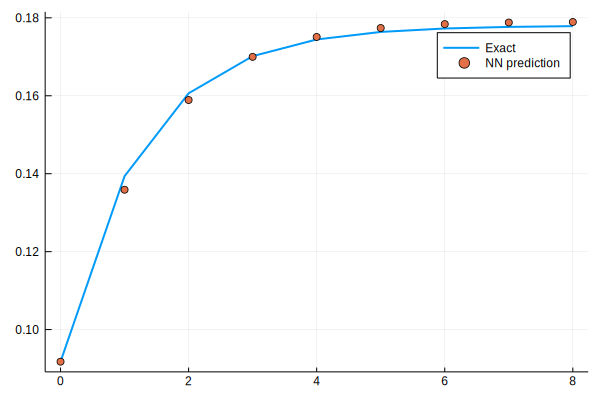

7.778969f-5

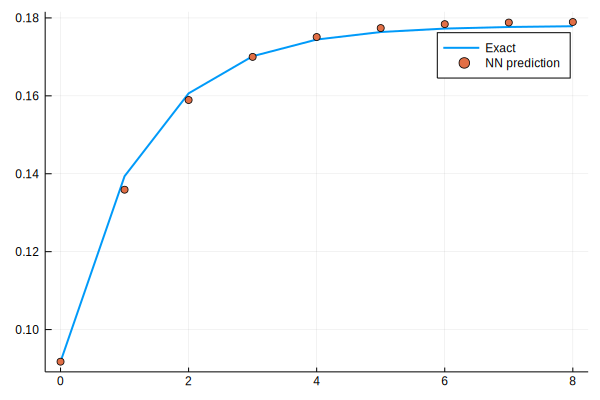

loss: 7.78e-05:  62%|█████████████████████████▎               |  ETA: 0:00:02

7.691611f-5

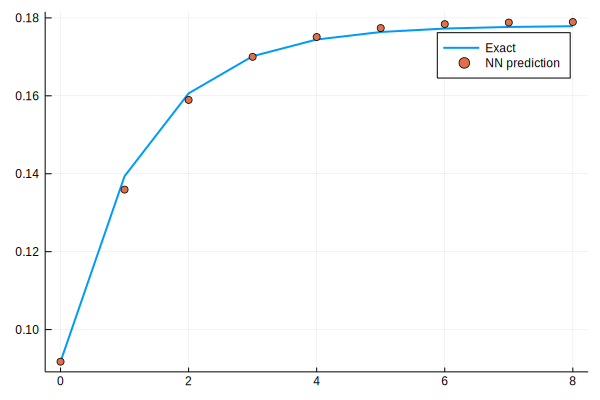

7.6028395f-5

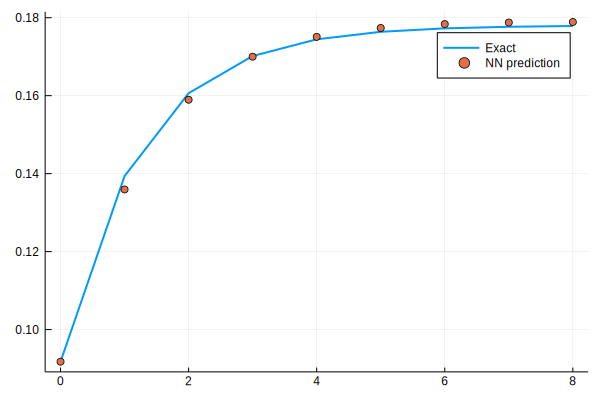

7.51827f-5

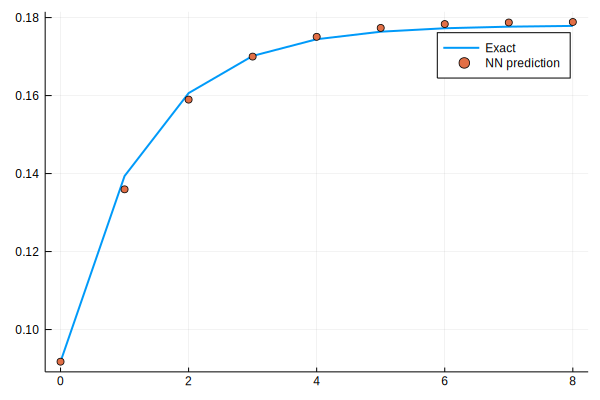

7.434157f-5

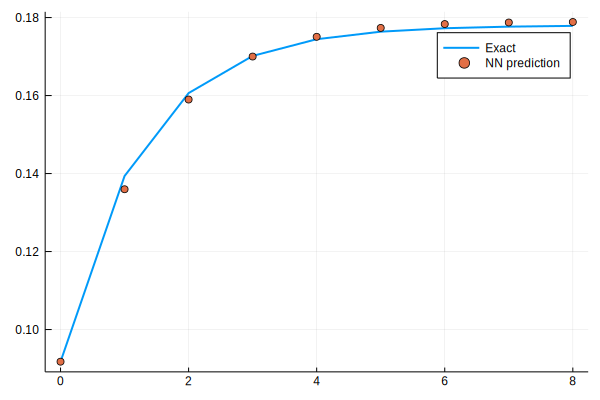

7.350042f-5

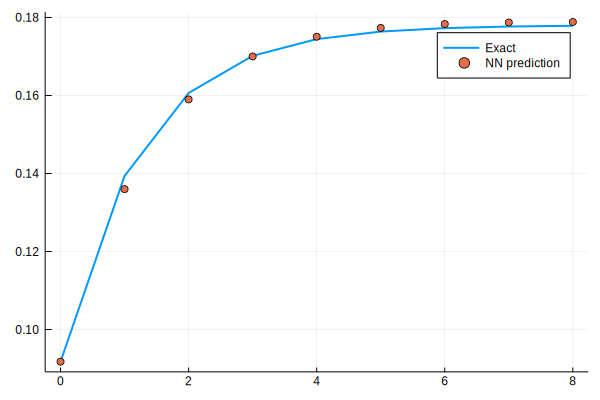

loss: 7.35e-05:  64%|██████████████████████████▎              |  ETA: 0:00:02

7.2668474f-5

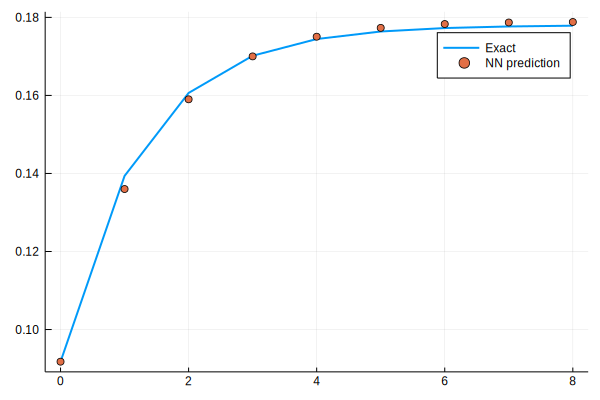

7.185076f-5

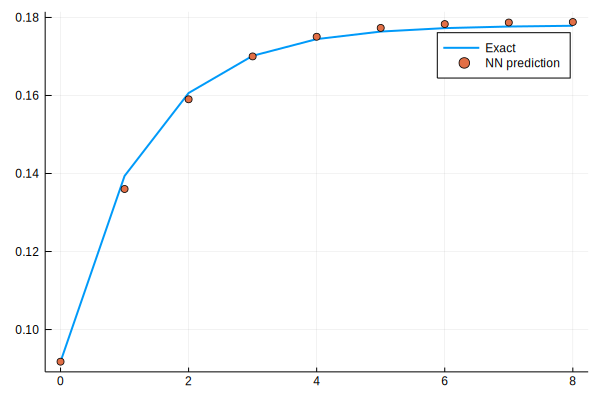

7.105094f-5

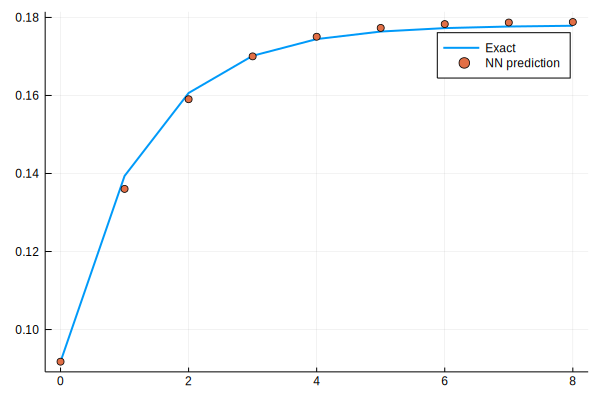

7.0247166f-5

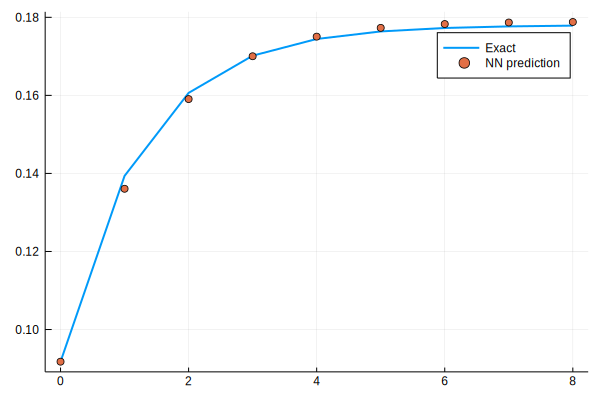

6.944469f-5

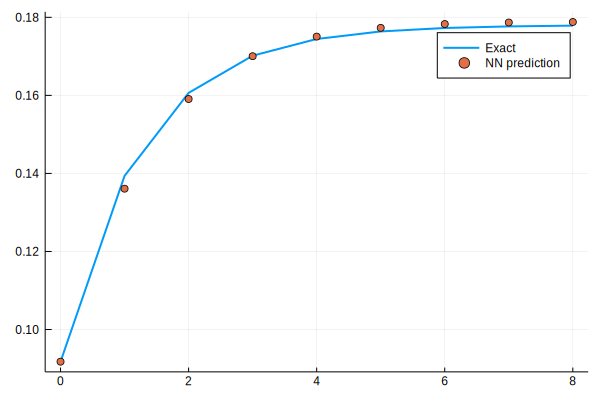

loss: 6.94e-05:  66%|███████████████████████████▎             |  ETA: 0:00:01

6.866884f-5

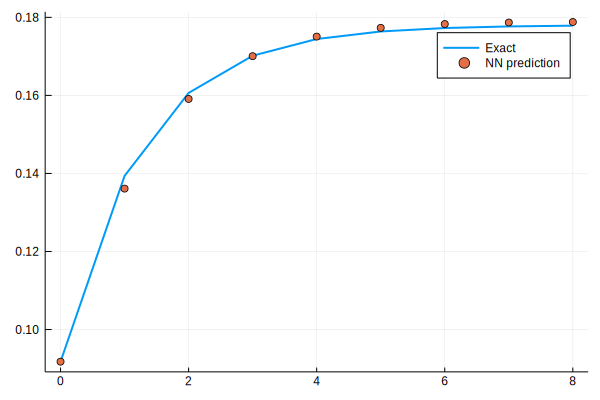

6.78981f-5

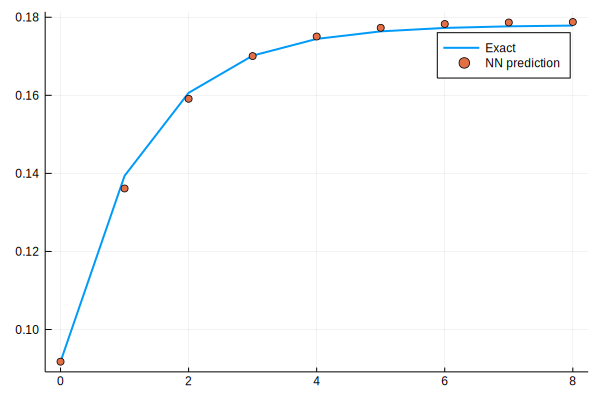

6.7134875f-5

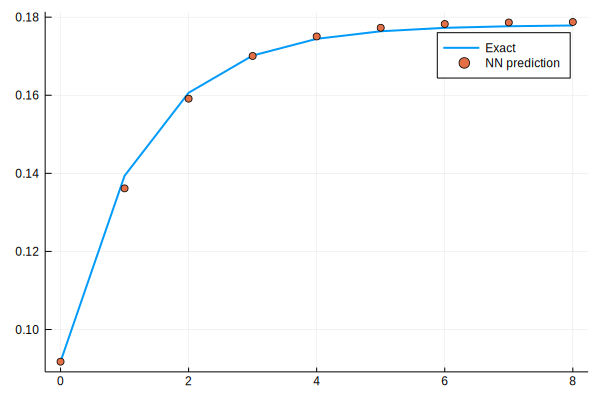

6.6368244f-5

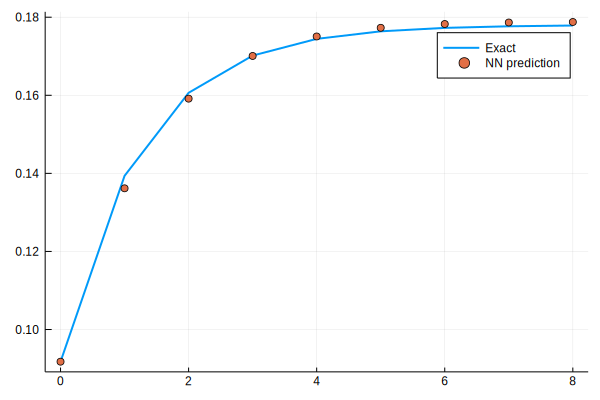

6.562337f-5

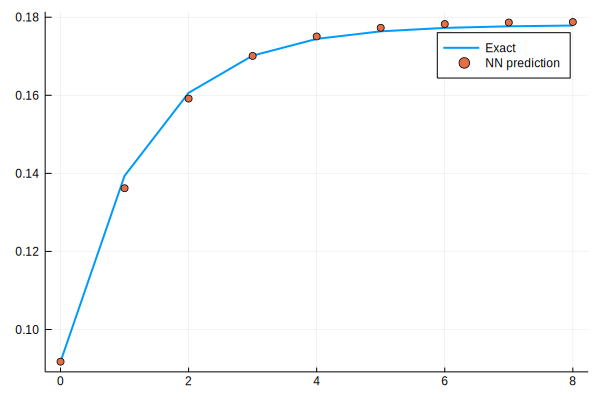

loss: 6.56e-05:  69%|████████████████████████████▎            |  ETA: 0:00:01

6.489456f-5

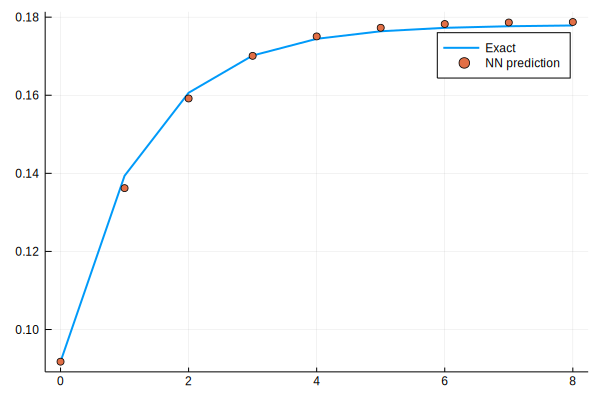

6.415898f-5

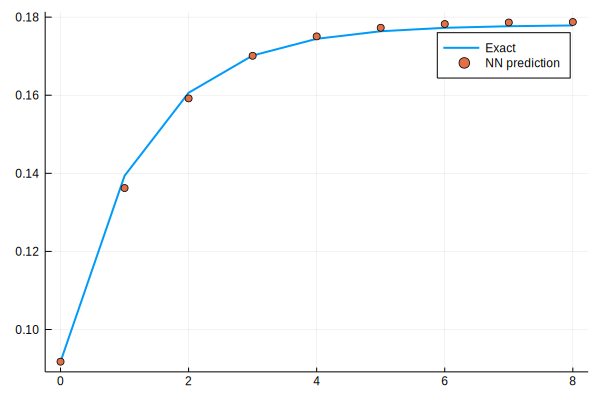

6.3434825f-5

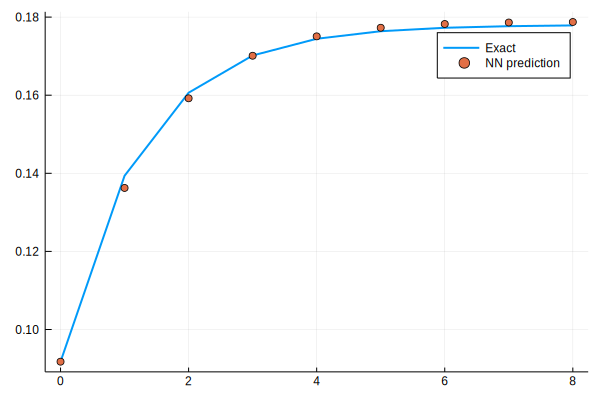

6.272748f-5

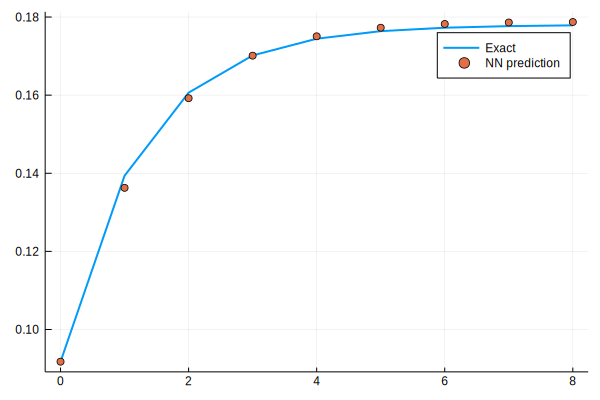

loss: 6.27e-05:  71%|█████████████████████████████▏           |  ETA: 0:00:01

6.202173f-5

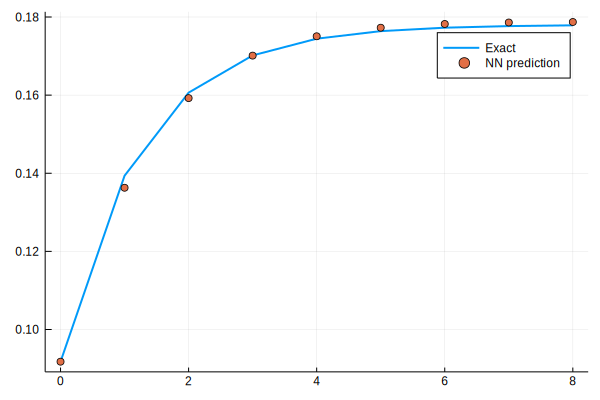

6.132319f-5

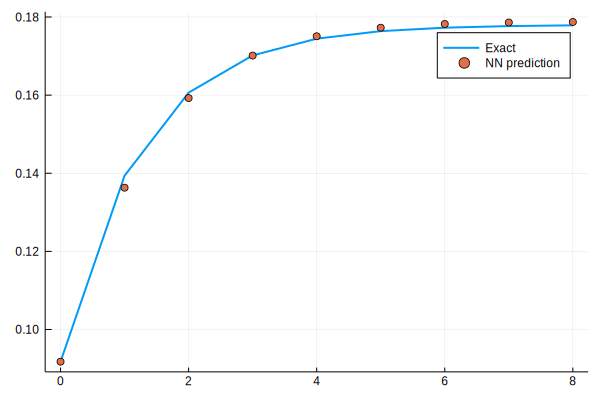

6.063326f-5

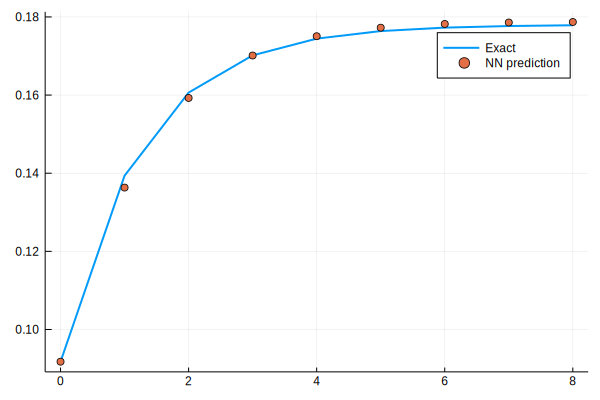

5.9952472f-5

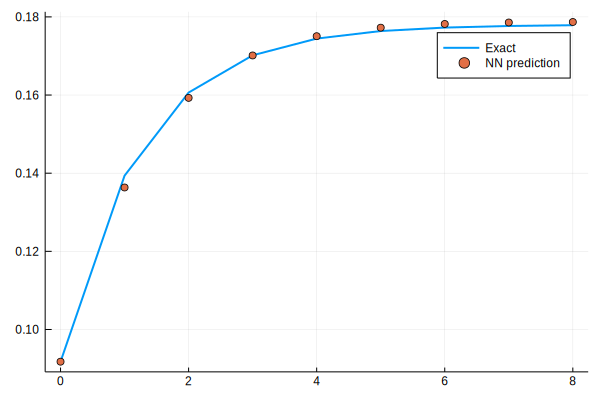

5.9278005f-5

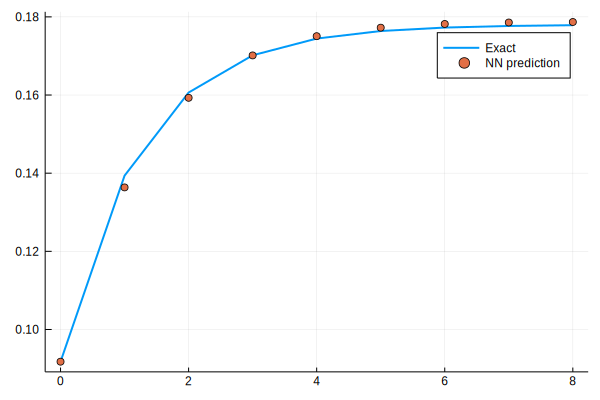

loss: 5.93e-05:  74%|██████████████████████████████▏          |  ETA: 0:00:01

5.861327f-5

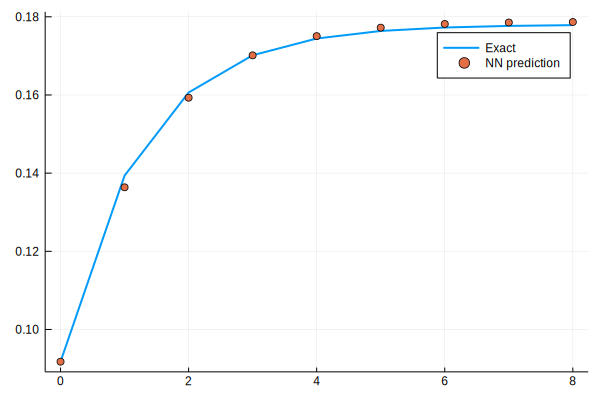

5.7951904f-5

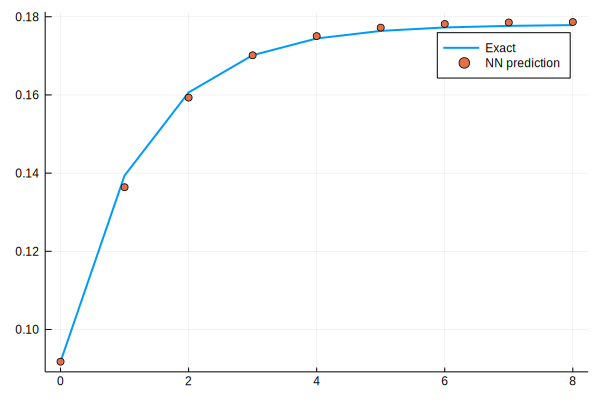

5.730016f-5

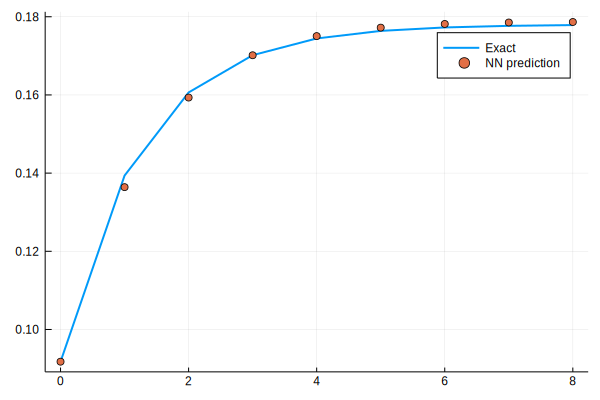

5.6664943f-5

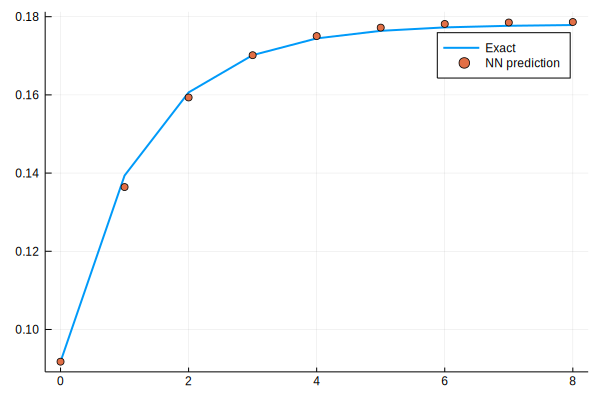

5.6026463f-5

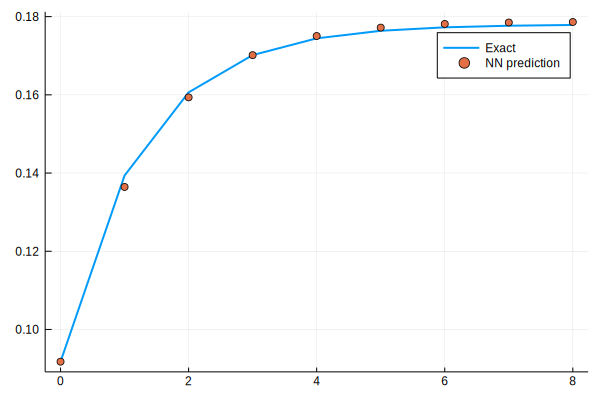

loss: 5.6e-05:  76%|███████████████████████████████▏         |  ETA: 0:00:01

5.540421f-5

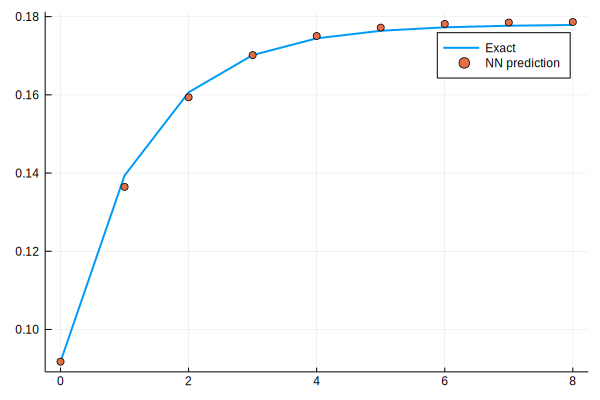

5.4780867f-5

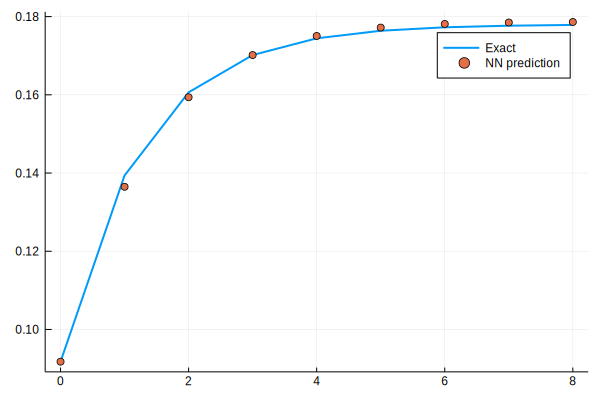

5.4169373f-5

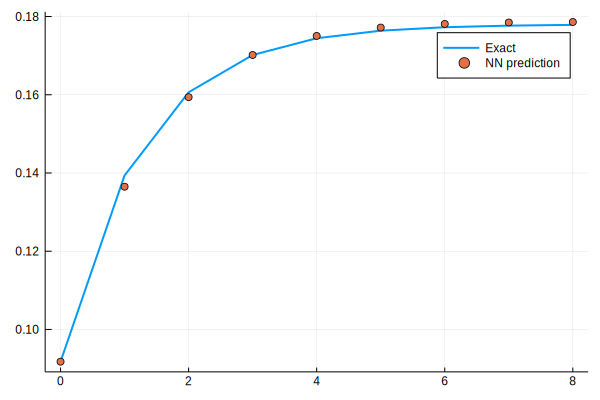

5.3568456f-5

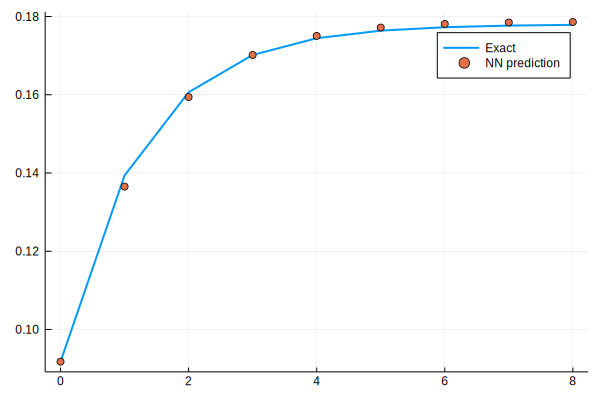

5.296828f-5

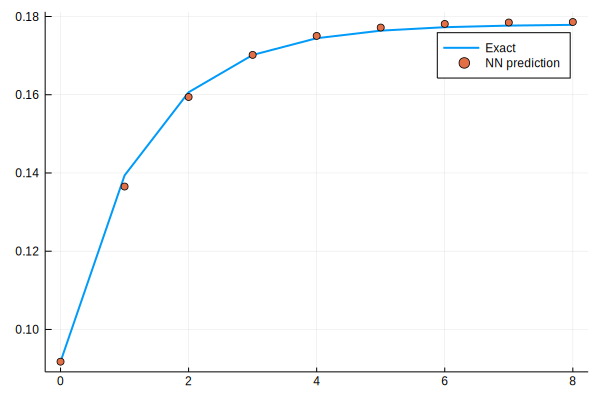

5.237598f-5

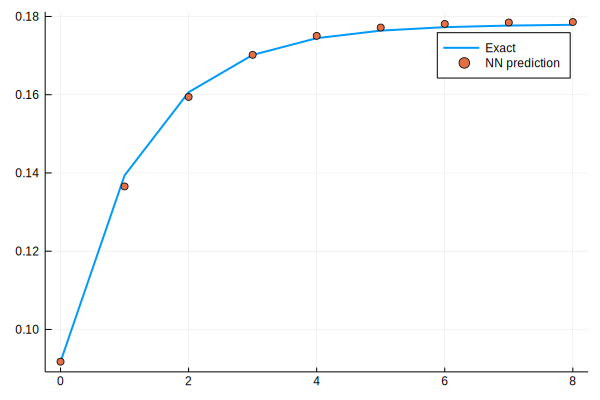

loss: 5.24e-05:  79%|████████████████████████████████▍        |  ETA: 0:00:01

5.1793562f-5

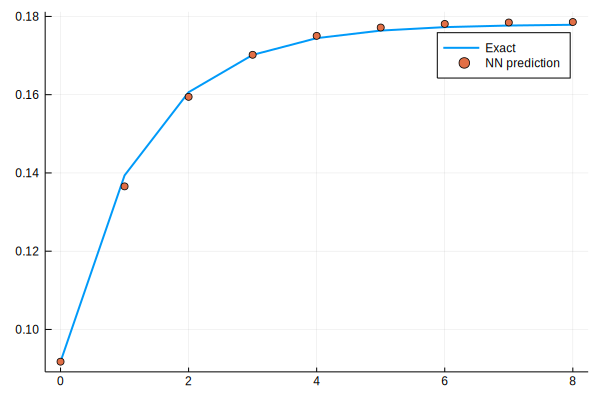

5.1215236f-5

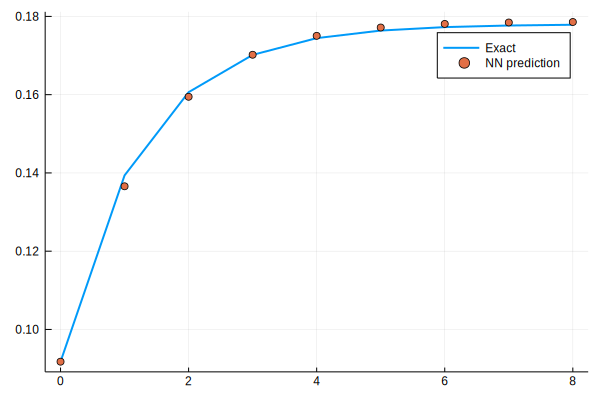

5.0646024f-5

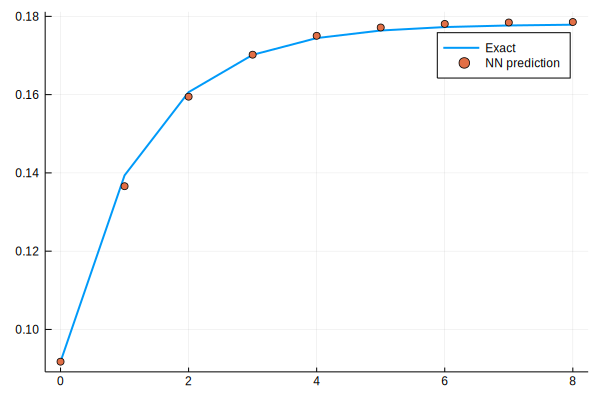

5.0086688f-5

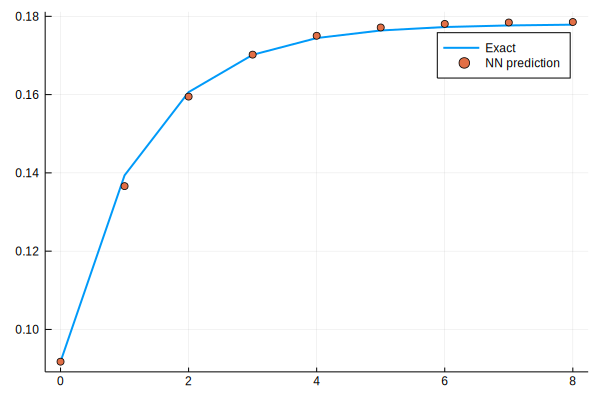

4.9530696f-5

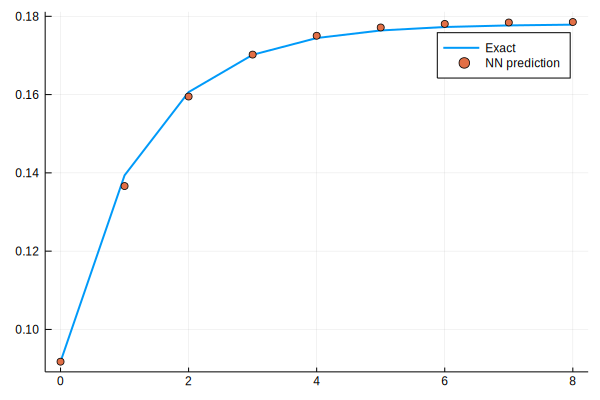

loss: 4.95e-05:  82%|█████████████████████████████████▍       |  ETA: 0:00:01

4.8978545f-5

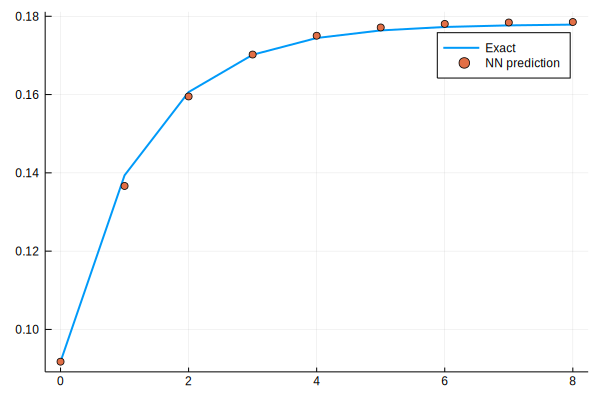

4.8439342f-5

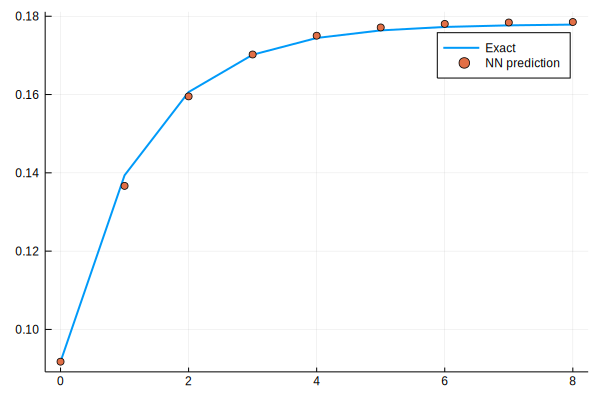

4.7903646f-5

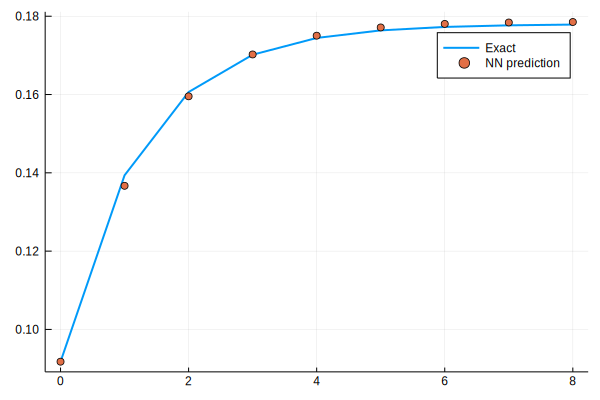

4.7371395f-5

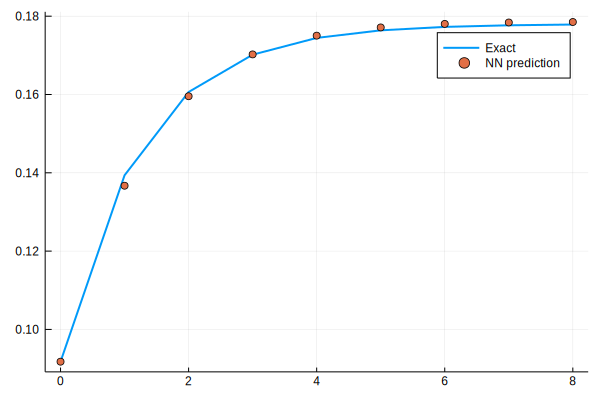

4.6847792f-5

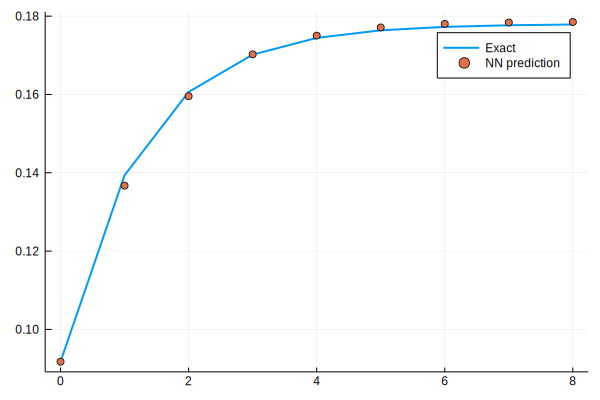

4.6333593f-5

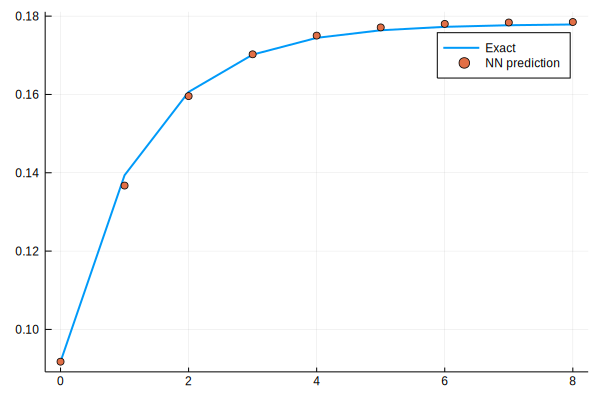

loss: 4.63e-05:  84%|██████████████████████████████████▋      |  ETA: 0:00:01

4.5820616f-5

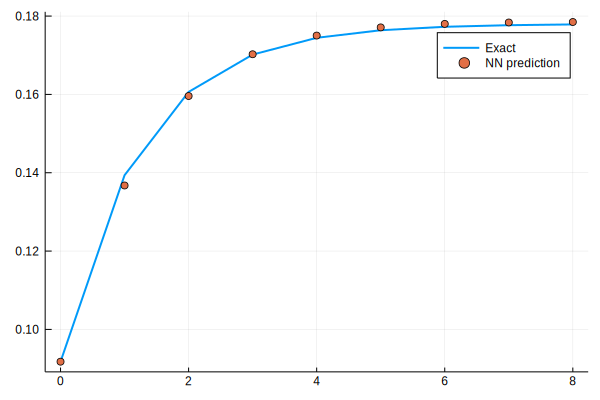

4.5317225f-5

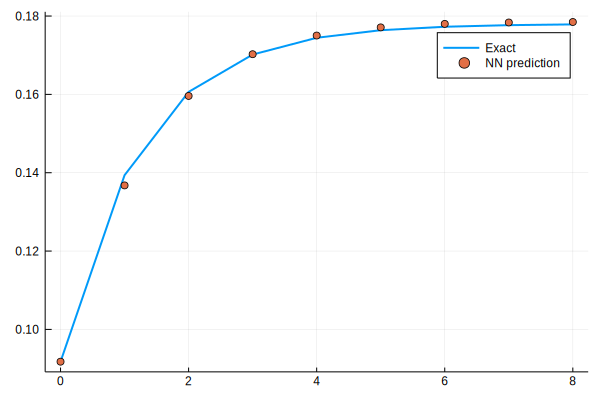

4.481781f-5

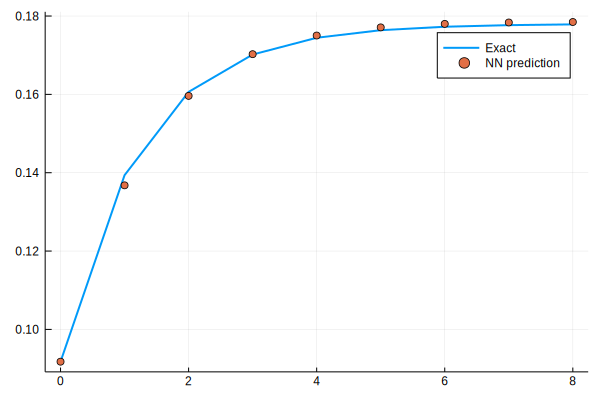

4.432957f-5

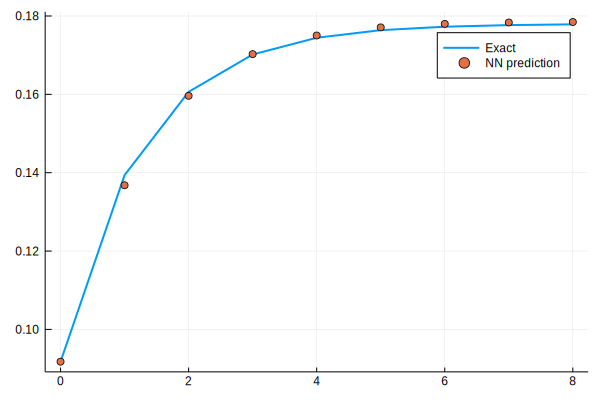

4.3845244f-5

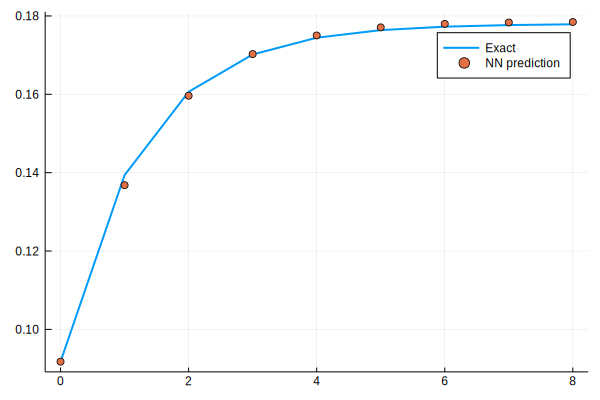

loss: 4.38e-05:  87%|███████████████████████████████████▋     |  ETA: 0:00:01

4.336376f-5

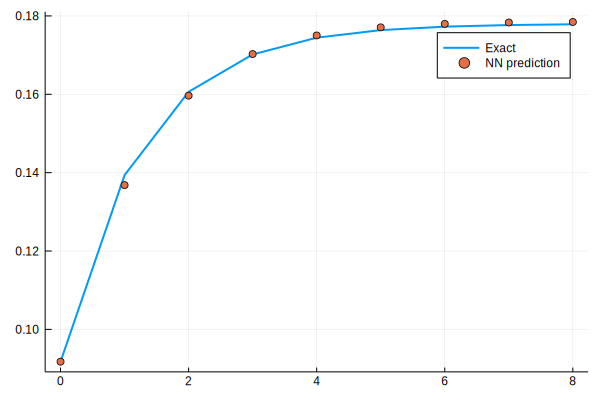

4.289125f-5

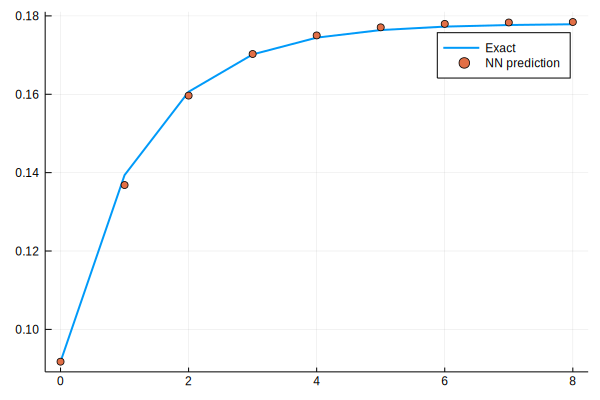

4.242238f-5

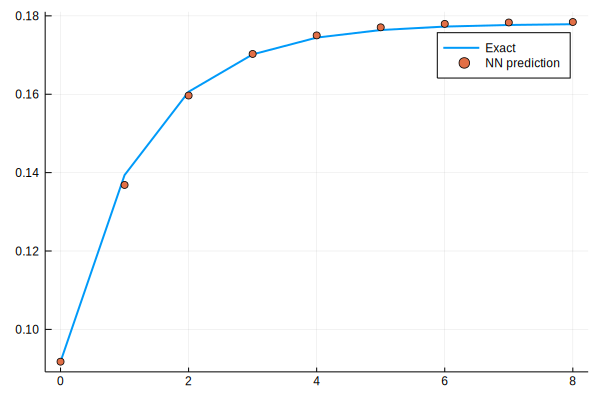

4.196234f-5

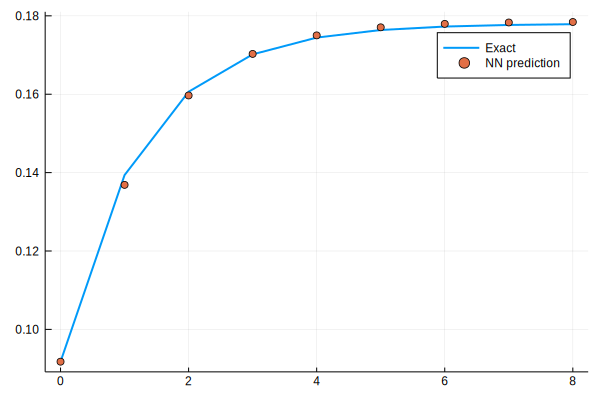

4.150243f-5

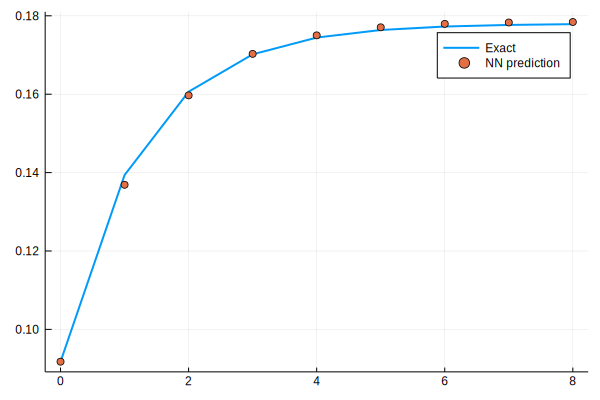

loss: 4.15e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:00

4.105786f-5

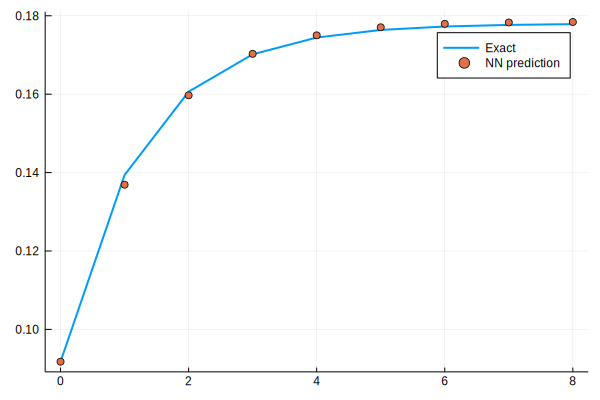

4.0613337f-5

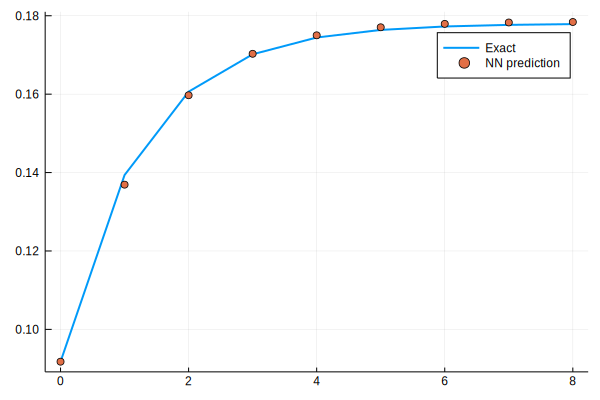

4.017365f-5

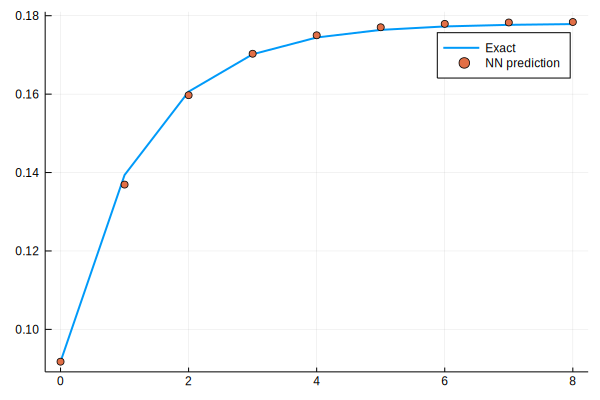

3.973895f-5

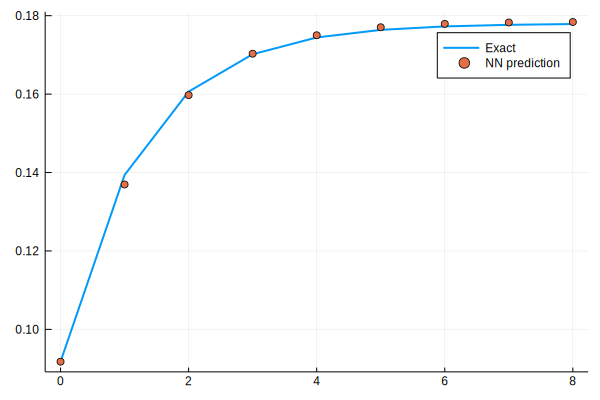

3.9313065f-5

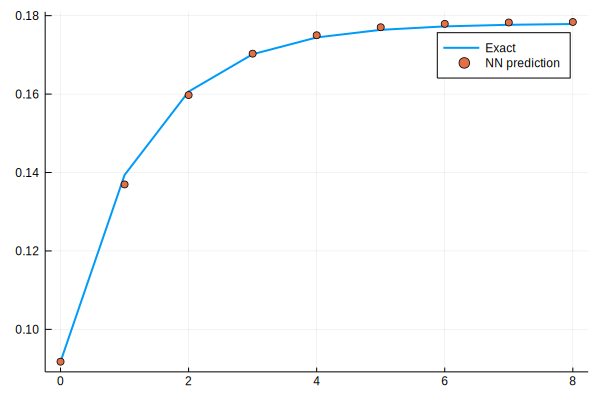

loss: 3.93e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

3.8891038f-5

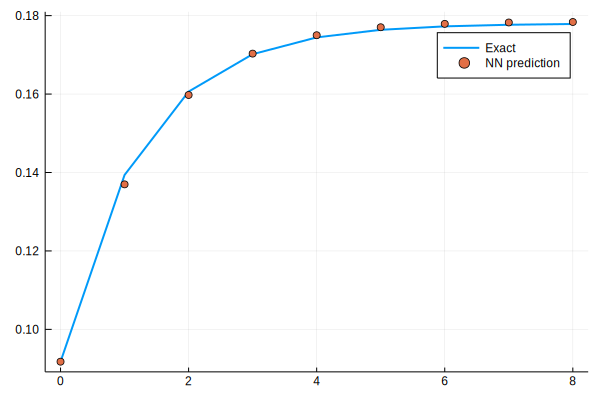

3.8472248f-5

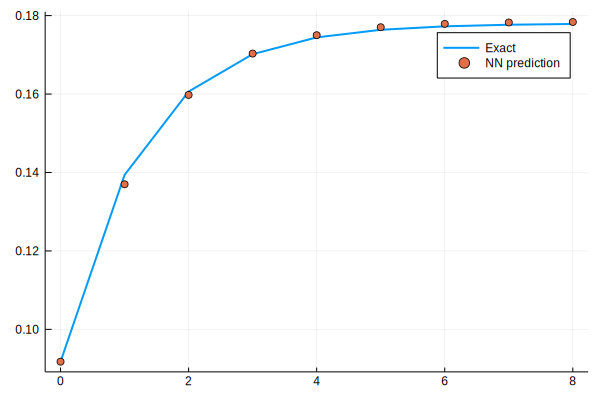

3.8059115f-5

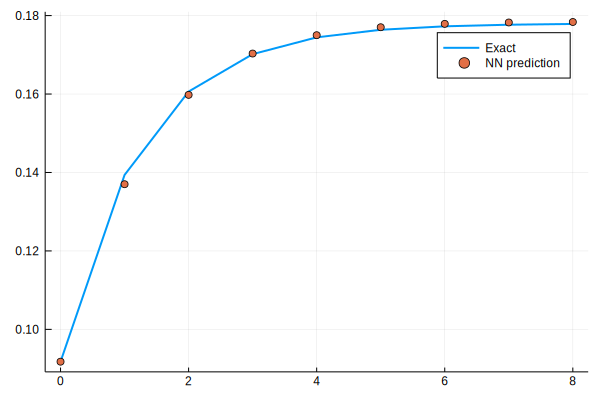

3.7653026f-5

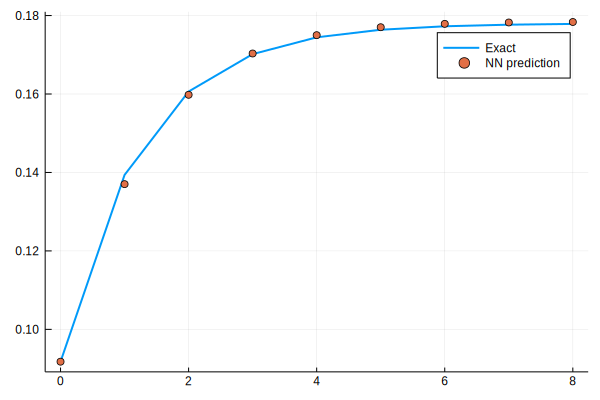

3.725401f-5

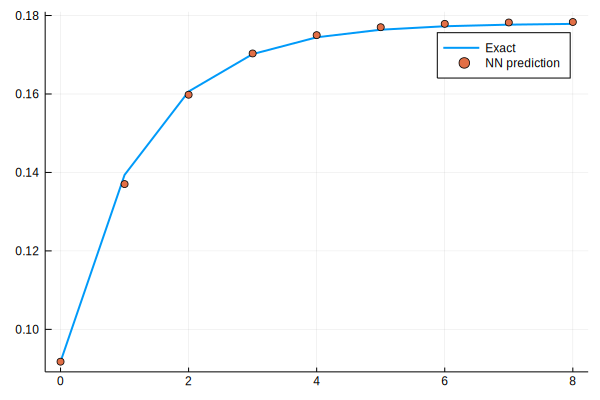

3.685294f-5

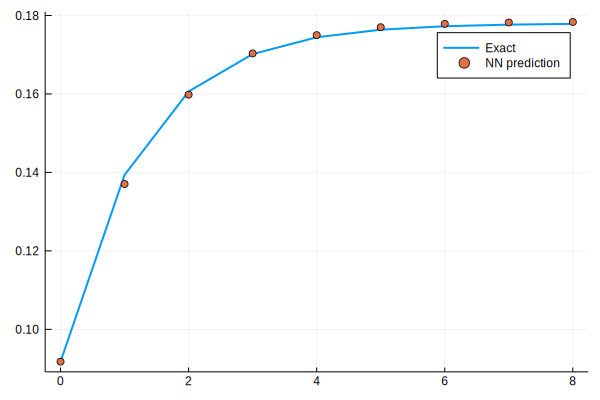

loss: 3.69e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:00

3.646596f-5

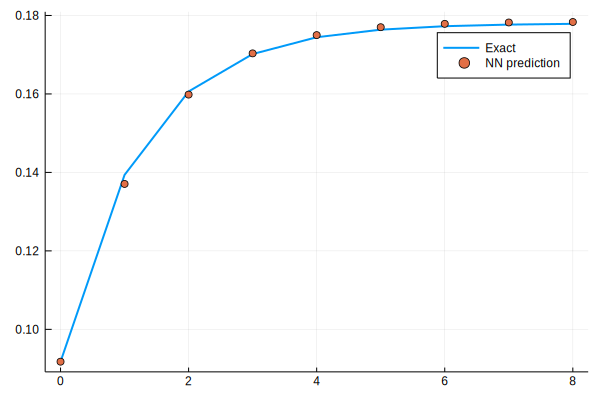

3.607871f-5

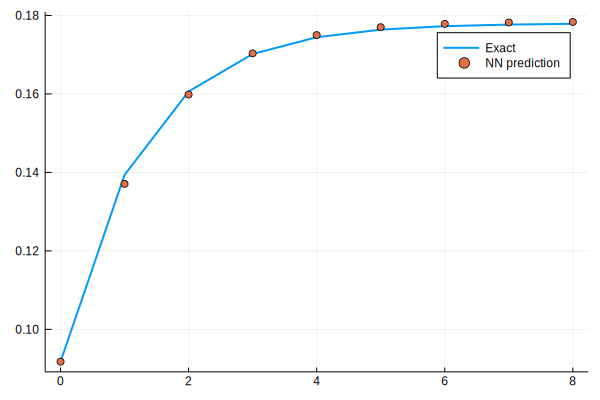

3.569833f-5

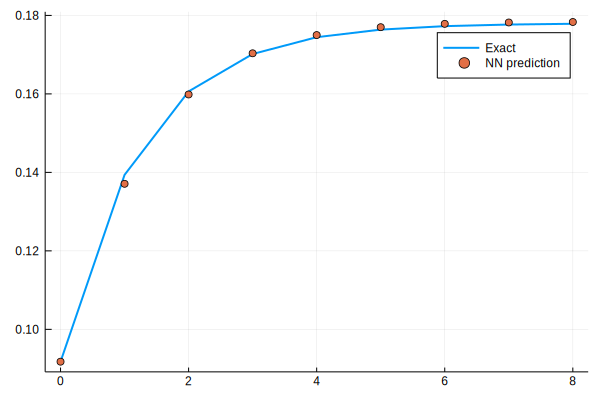

3.5323657f-5

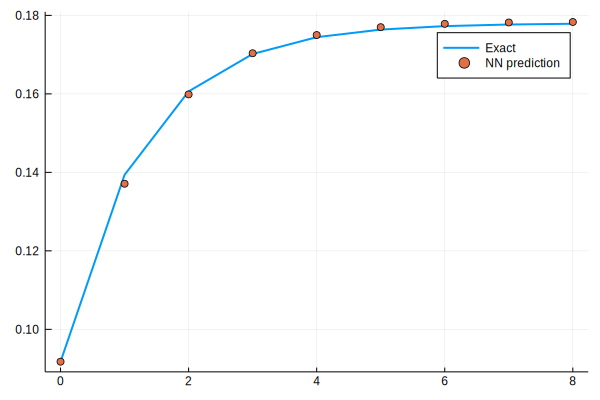

3.4952176f-5

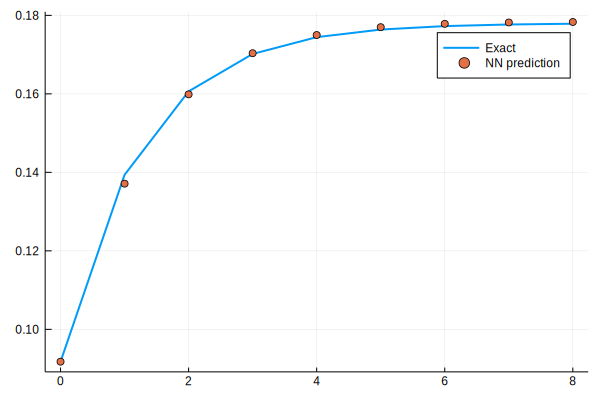

3.4585402f-5

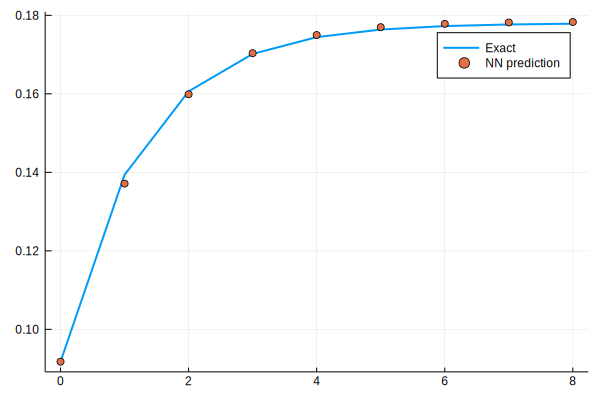

loss: 3.46e-05:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

3.4222427f-5

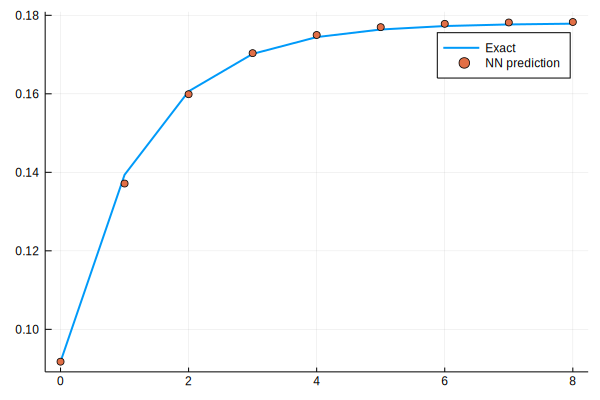

3.386618f-5

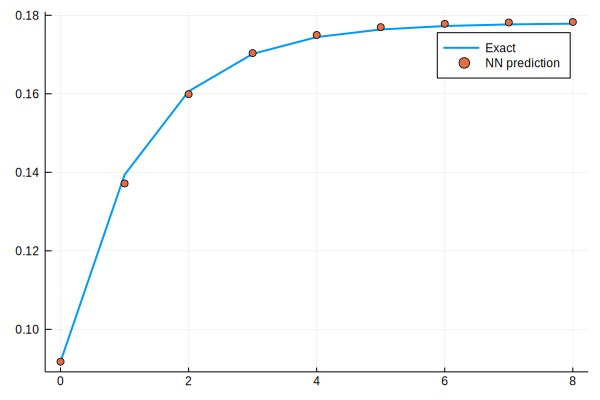

3.3514465f-5

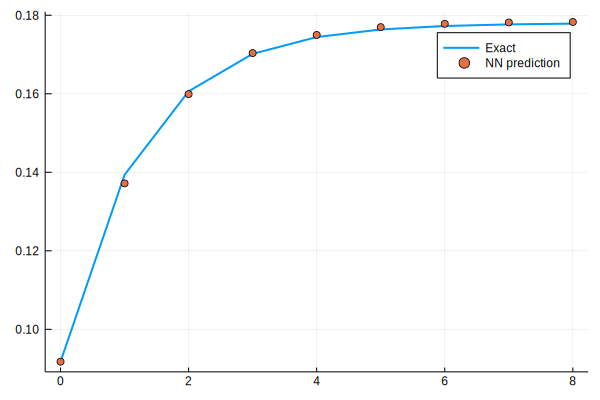

3.316236f-5

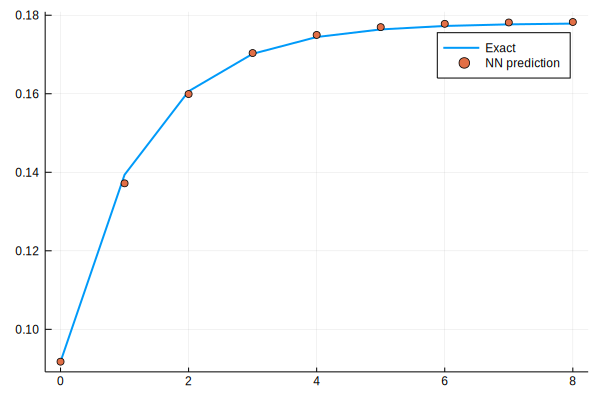

loss: 3.32e-05: 100%|█████████████████████████████████████████| Time: 0:00:04


3.316236f-5

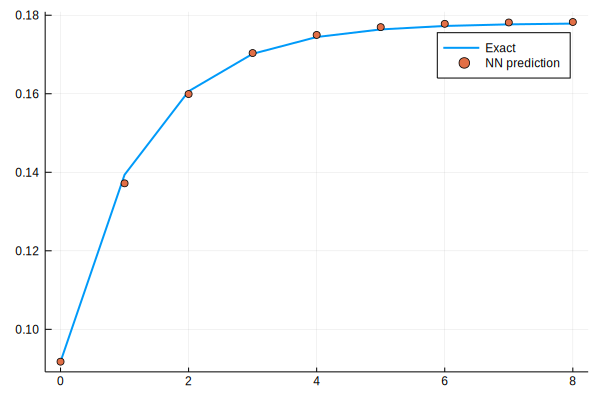

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [7.96e-02, 1.82e-01, -1.18e-01,  ...]
    Minimum:   3.316236e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [8.44e-02, 1.84e-01, -1.19e-01,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [14]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, ADAM(), cb=cb, maxiters=200)

PDF at final instant

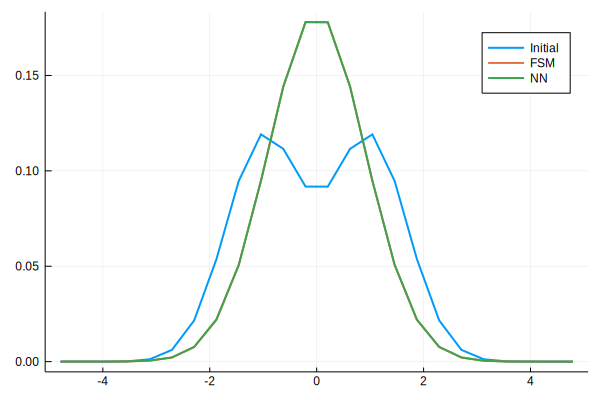

In [18]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,end], lw=2, label="FSM")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], n_ode(f0_1D, res.minimizer).u[end], lw=2, label="NN")

Trajectories of PDF

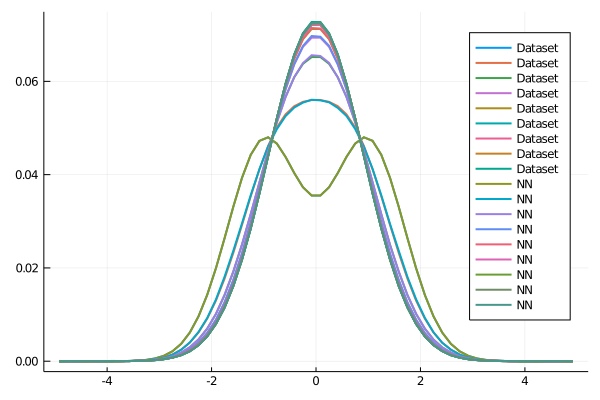

In [16]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,:], lw=2, label="Dataset")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], n_ode(f0_1D, res.minimizer).u[:], lw=2, label="NN")

From different given initial value

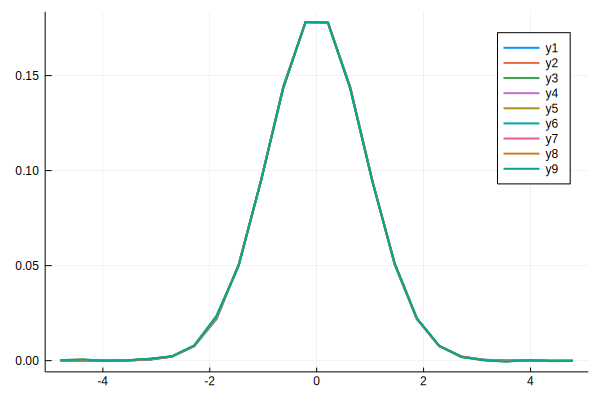

In [19]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], n_ode(M0_1D, res.minimizer).u[:], lw=2)

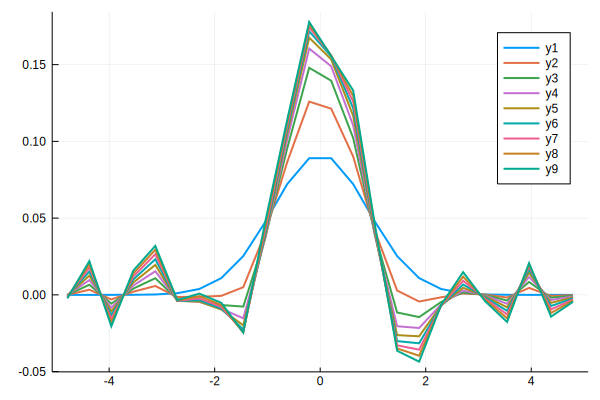

In [20]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], n_ode(M0_1D./2, res.minimizer).u[:], lw=2)

In [21]:
rand(5)

5-element Array{Float64,1}:
 0.21023712785423254
 0.47207581716170344
 0.1522837312216354 
 0.13412094242549788
 0.8674874602587797 

In [22]:
randn(5)

5-element Array{Float64,1}:
  1.235688941523508  
 -0.4425029462816983 
  0.4231324420429891 
 -0.31427886064413696
  0.5222252560050824 